This code creates and stores a single model ensemble created from a selection of models. We used a customized CNN, and pretrained models including VGG19, InceptionResnetV2 and SqueezeNet, with their ImageNet weights initialized and fine-tuned end-to-end. The optimal model ensemble is chosen and saved to make further predictions. Five fold cross validation is performed on a patient-specific case.

# Load libraries

In [11]:
import tensorflow as tf
print('Tensorflow version : {}'.format(tf.__version__))
print('GPU : {}'.format(tf.config.list_physical_devices('GPU')))
#tf.config.experimental.list_physical_devices('GPU')
from tensorflow import keras
import tensorflow.keras.backend as K

Tensorflow version : 2.4.1
GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
# Imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Concatenate, concatenate, Dense, Average, Dropout, LeakyReLU, Reshape, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Lambda, Activation, Flatten, Convolution1D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
#from tensorflow.keras.utils import np_utils
#from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import Model, Input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
#from keras_squeezenet_tf2 import SqueezeNet
from keras_squeezenet_tf2 import SqueezeNet
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [13]:
# custom function to plot confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [14]:
#%% Loading the data

img_width, img_height = 100, 100
train_data_dir = '../data/cell_images/train'
validation_data_dir = '../data/cell_images/test'
epochs = 60
batch_size = 16 
num_classes= 2

# Since the models work with the data of the same shape, we 
#define a single input layer that will be used by every model.

input_shape = (100,100,3)
model_input = Input(shape=input_shape)
print(model_input) 

KerasTensor(type_spec=TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [85]:
#%% declaring image data generators

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=2,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.5,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(100,100),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(100,100),
        batch_size=batch_size,
        class_mode='categorical',shuffle=False)

#identify the number of samples
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)

#check the class indices
train_generator.class_indices
validation_generator.class_indices

#true labels
Y_test=validation_generator.classes

Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


In [16]:
#%% assign class weights to balance model training and penalize over-represented classes

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)
print(class_weights)

[1. 1.]


In [17]:
#%% define custom model and instantiate it

def custom_cnn(model_input):
    x = BatchNormalization()(model_input)
    x = Conv2D(64, (5, 5), padding='same', activation='relu', name = 'custom_conv1')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), name = 'maxpool1')(x)
    x = Dropout(0.25, name = 'conv_dropout1')(x)
    x = BatchNormalization(name = 'custom_batchnorm1')(x)
    x = Conv2D(128, (5, 5), padding='same', activation='relu', name = 'custom_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2), name = 'maxpool2')(x)
    x = Dropout(0.25, name = 'conv_dropout2')(x)
    x = BatchNormalization(name = 'custom_batchnorm2')(x)
    x = Conv2D(256, (5, 5), padding='same', activation='relu', name = 'custom_conv3')(x)
    x = MaxPooling2D(pool_size=(2, 2), name = 'maxpool3')(x)
    x = Dropout(0.25, name = 'conv_dropout3')(x)
    x = GlobalAveragePooling2D(name = 'custom_GAP')(x)
    x = Dense(256, activation='relu', name = 'custom_dense1')(x)
    x = Dropout(0.5, name = 'dense_dropout1')(x)
    x = Dense(num_classes, activation='softmax', name = 'custom_dense2')(x)
    model = Model(inputs=model_input, outputs=x, name='custom_cnn')
    return model

#instantiate the model
custom_model = custom_cnn(model_input)

#display model summary
custom_model.summary()

#plot the model
#plot_model(custom_model, to_file='custom_model.png',show_shapes=True, show_layer_names=False)


Model: "custom_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
batch_normalization_204 (Bat (None, 100, 100, 3)       12        
_________________________________________________________________
custom_conv1 (Conv2D)        (None, 100, 100, 64)      4864      
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 50, 50, 64)        0         
_________________________________________________________________
conv_dropout1 (Dropout)      (None, 50, 50, 64)        0         
_________________________________________________________________
custom_batchnorm1 (BatchNorm (None, 50, 50, 64)        256       
_________________________________________________________________
custom_conv2 (Conv2D)        (None, 50, 50, 128)       2

In [18]:
#%% VGG19 model 

def vgg19_cnn(model_input):
    vgg19_cnn = VGG19(weights='imagenet', include_top=False, input_tensor=model_input)
    x = vgg19_cnn.layers[-2].output 
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=vgg19_cnn.input, outputs=predictions, name='vgg19_custom')
    return model

#instantiate the model
vgg19_custom_model = vgg19_cnn(model_input)

#plot model summary
vgg19_custom_model.summary()
#plot_model(vgg19_custom_model, to_file='vgg19_custom_model.png',show_shapes=True, show_layer_names=False)


Model: "vgg19_custom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)      

In [19]:
#%% SqueezeNet 

def squeeze_cnn(model_input):
    squeeze_cnn = SqueezeNet(weights='imagenet', include_top=False, input_tensor=model_input)
    x = squeeze_cnn.layers[-3].output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=squeeze_cnn.input, outputs=predictions, name='squeeze_custom')
    return model

#instantiate the model
squeeze_custom_model = squeeze_cnn(model_input)

#display model summary
squeeze_custom_model.summary()

#plot model
#plot_model(squeeze_custom_model, to_file='squeeze_custom_model.png',show_shapes=True, show_layer_names=False)


Model: "squeeze_custom"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 49, 49, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 49, 49, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 24, 24, 64)   0           relu_conv1[0][0]                 
_____________________________________________________________________________________

In [20]:
#%% Inception ResnetV2 

def incepres_cnn(model_input):
    incepres_cnn = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=model_input)
    x = incepres_cnn.layers[-3].output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=incepres_cnn.input, outputs=predictions, name='InceptionResnet_custom')
    return model

#instantiate the model
inceptionresnet_custom_model = incepres_cnn(model_input)

#display model summary
inceptionresnet_custom_model.summary()

#plot model
#plot_model(inceptionresnet_custom_model, to_file='inceptionresnet_custom_model.png',show_shapes=True, show_layer_names=False)


219062272/219055592 [==============================] - 4s 0us/step
Model: "InceptionResnet_custom"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 49, 49, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_205 (BatchN (None, 49, 49, 32)   96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 49, 49, 32)   0           batch_normalization_205[0][0]    
__________

__________________________________________________________________________________________________
batch_normalization_352 (BatchN (None, 4, 4, 192)    576         conv2d_350[0][0]                 
__________________________________________________________________________________________________
activation_347 (Activation)     (None, 4, 4, 192)    0           batch_normalization_349[0][0]    
__________________________________________________________________________________________________
activation_350 (Activation)     (None, 4, 4, 192)    0           batch_normalization_352[0][0]    
__________________________________________________________________________________________________
block17_18_mixed (Concatenate)  (None, 4, 4, 384)    0           activation_347[0][0]             
                                                                 activation_350[0][0]             
__________________________________________________________________________________________________
block17_18

In [ ]:
#%% compile and train the custom model

adam = Adam(lr=0.001)  
metric = 'val_accuracy'
custom_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) 
checkpoint = ModelCheckpoint(filepath='weights/' + custom_model.name + '.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
checkpoint2 = ModelCheckpoint(filepath='weights/checkpoints/' + custom_model.name + '_epoch{epoch:02d}_valaccuracy_{val_accuracy:.2f}.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
reduce_lr = ReduceLROnPlateau(monitor=metric, factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0)
callbacks_list = [checkpoint, checkpoint2, tensor_board, reduce_lr]
history = custom_model.fit(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  #class_weight = class_weights,
                                  callbacks=callbacks_list, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1) 


In [ ]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_accuracy")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("logs/custom_plot.png")

In [ ]:
#%% compile and train the VGG19 model

adam = Adam(lr=0.0001)
metric = 'val_accuracy'
vgg19_custom_model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy']) 
checkpoint = ModelCheckpoint(filepath='weights/' + vgg19_custom_model.name + '.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
checkpoint2 = ModelCheckpoint(filepath='weights/checkpoints/' + vgg19_custom_model.name + '_epoch{epoch:02d}_valaccuracy_{val_accuracy:.2f}.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0)
callbacks_list = [checkpoint, checkpoint2, tensor_board, reduce_lr]
history = vgg19_custom_model.fit(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  #class_weight = class_weights,
                                  callbacks=callbacks_list, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)    


In [ ]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_accuracy")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("logs/VGG19_custom_plot.png")

In [150]:
#%% compile and train the squeezenet model

adam = Adam(lr=0.0001) 
squeeze_custom_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) 
checkpoint = ModelCheckpoint(filepath='weights/' + squeeze_custom_model.name + '.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
checkpoint2 = ModelCheckpoint(filepath='weights/checkpoints/' + squeeze_custom_model.name + '_epoch{epoch:02d}_valaccuracy_{val_accuracy:.2f}.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0)
callbacks_list = [checkpoint, checkpoint2, tensor_board, reduce_lr]
history = squeeze_custom_model.fit(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  #class_weight = class_weights,
                                  callbacks=callbacks_list, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)    

Epoch 1/60
1377/1377 [==============================] - 65s 46ms/step - loss: 0.3090 - accuracy: 0.8704 - val_loss: 0.1357 - val_accuracy: 0.9571
Epoch 2/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.2006 - accuracy: 0.9290 - val_loss: 0.1346 - val_accuracy: 0.9582
Epoch 3/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1941 - accuracy: 0.9307 - val_loss: 0.1309 - val_accuracy: 0.9578
Epoch 4/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1875 - accuracy: 0.9310 - val_loss: 0.1279 - val_accuracy: 0.9597
Epoch 5/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1876 - accuracy: 0.9294 - val_loss: 0.1099 - val_accuracy: 0.9582
Epoch 6/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1751 - accuracy: 0.9357 - val_loss: 0.1050 - val_accuracy: 0.9626
Epoch 7/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1711 - accuracy: 0.9372 - val_loss: 0.1077 -

Epoch 55/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1254 - accuracy: 0.9522 - val_loss: 0.0847 - val_accuracy: 0.9717
Epoch 56/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1248 - accuracy: 0.9527 - val_loss: 0.0852 - val_accuracy: 0.9713
Epoch 57/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1179 - accuracy: 0.9557 - val_loss: 0.0853 - val_accuracy: 0.9695
Epoch 58/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1276 - accuracy: 0.9519 - val_loss: 0.0880 - val_accuracy: 0.9695
Epoch 59/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1257 - accuracy: 0.9529 - val_loss: 0.0830 - val_accuracy: 0.9713
Epoch 60/60
1377/1377 [==============================] - 63s 46ms/step - loss: 0.1289 - accuracy: 0.9509 - val_loss: 0.0828 - val_accuracy: 0.9717


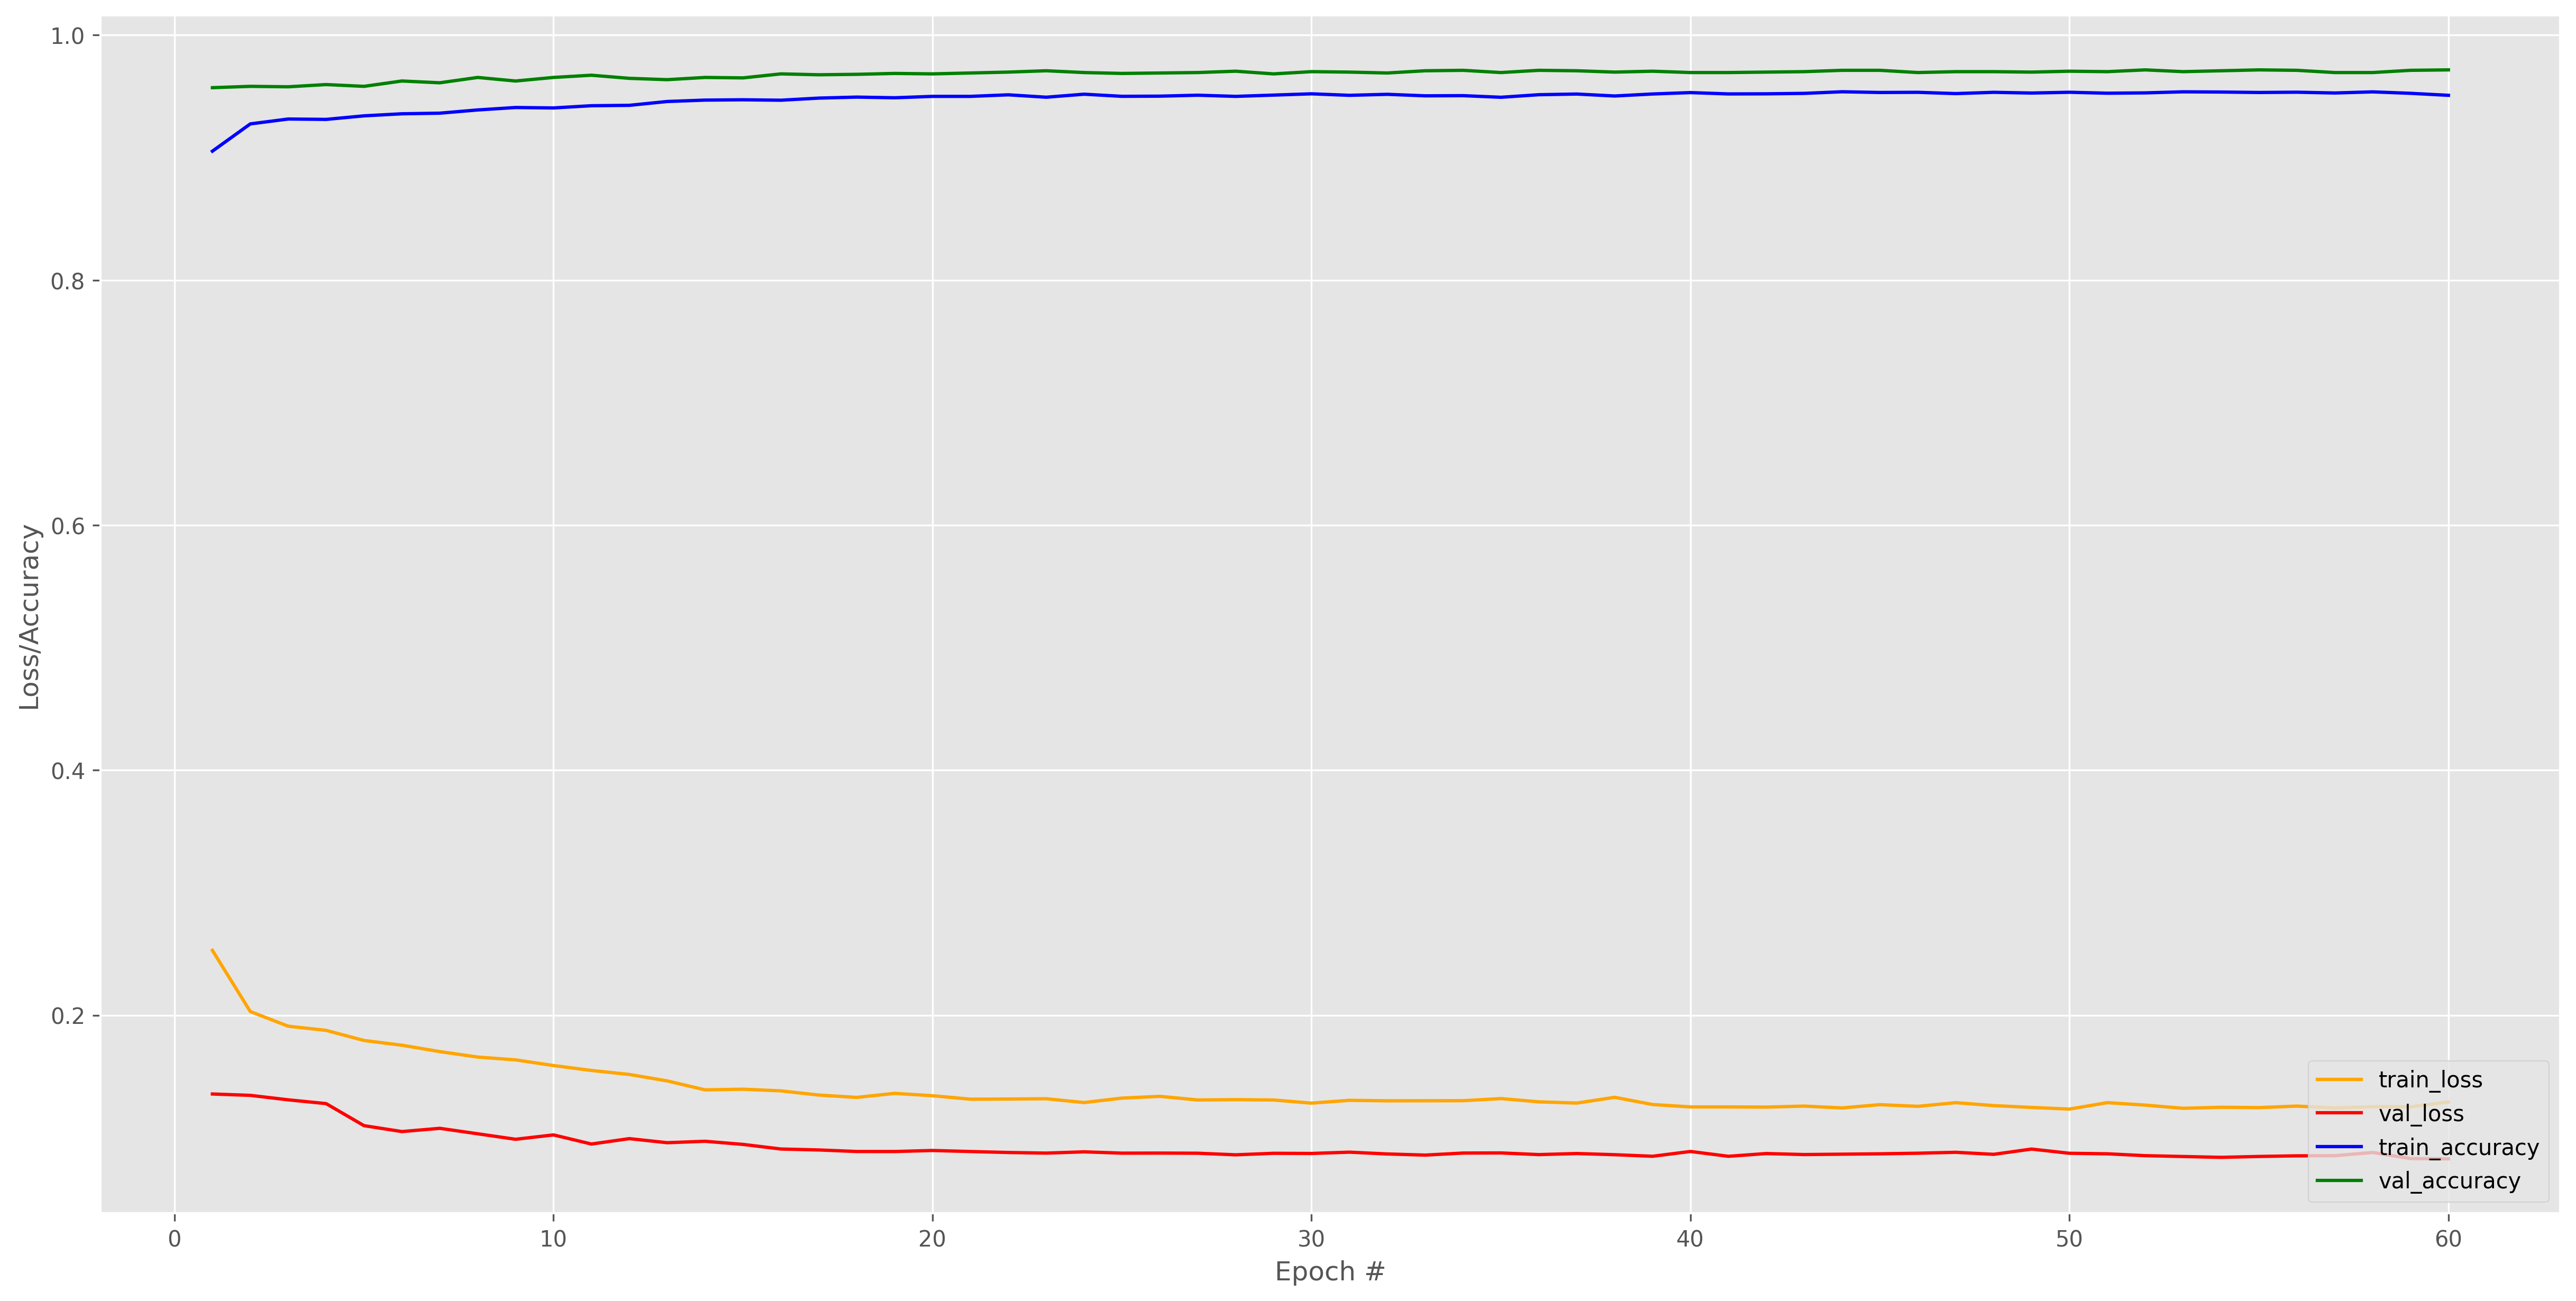

In [151]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_accuracy")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("logs/SqueezeNet_custom_plot.png")

In [152]:
#%% compile and train the InceptionResnetV2 model

adam = Adam(lr=0.0001)  
inceptionresnet_custom_model.compile(optimizer=adam,
                                     loss='categorical_crossentropy', metrics=['accuracy']) 
checkpoint = ModelCheckpoint(filepath='weights/' + inceptionresnet_custom_model.name + '.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
checkpoint2 = ModelCheckpoint(filepath='weights/checkpoints/' + inceptionresnet_custom_model.name + '_epoch{epoch:02d}_valaccuracy_{val_accuracy:.2f}.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0)
callbacks_list = [checkpoint, checkpoint2, tensor_board, reduce_lr]
history = inceptionresnet_custom_model.fit(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  #class_weight = class_weights,
                                  callbacks=callbacks_list, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)    

Epoch 1/60
1377/1377 [==============================] - 158s 104ms/step - loss: 0.3733 - accuracy: 0.8378 - val_loss: 0.1406 - val_accuracy: 0.9568
Epoch 2/60
1377/1377 [==============================] - 138s 100ms/step - loss: 0.2002 - accuracy: 0.9258 - val_loss: 0.1198 - val_accuracy: 0.9571
Epoch 3/60
1377/1377 [==============================] - 138s 100ms/step - loss: 0.1800 - accuracy: 0.9346 - val_loss: 0.1218 - val_accuracy: 0.9622
Epoch 4/60
1377/1377 [==============================] - 138s 100ms/step - loss: 0.1620 - accuracy: 0.9391 - val_loss: 0.1035 - val_accuracy: 0.9629
Epoch 5/60
1377/1377 [==============================] - 138s 100ms/step - loss: 0.1495 - accuracy: 0.9448 - val_loss: 0.1036 - val_accuracy: 0.9655
Epoch 6/60
1377/1377 [==============================] - 138s 100ms/step - loss: 0.1458 - accuracy: 0.9468 - val_loss: 0.0871 - val_accuracy: 0.9713
Epoch 7/60
1377/1377 [==============================] - 138s 100ms/step - loss: 0.1407 - accuracy: 0.9484 - val_

Epoch 54/60
1377/1377 [==============================] - 138s 100ms/step - loss: 0.0812 - accuracy: 0.9701 - val_loss: 0.1022 - val_accuracy: 0.9724
Epoch 55/60
1377/1377 [==============================] - 138s 100ms/step - loss: 0.0823 - accuracy: 0.9698 - val_loss: 0.0975 - val_accuracy: 0.9753
Epoch 56/60
1377/1377 [==============================] - 138s 100ms/step - loss: 0.0777 - accuracy: 0.9717 - val_loss: 0.0956 - val_accuracy: 0.9731
Epoch 57/60
1377/1377 [==============================] - 138s 100ms/step - loss: 0.0790 - accuracy: 0.9700 - val_loss: 0.0998 - val_accuracy: 0.9731
Epoch 58/60
1377/1377 [==============================] - 138s 100ms/step - loss: 0.0826 - accuracy: 0.9690 - val_loss: 0.0972 - val_accuracy: 0.9775
Epoch 59/60
1377/1377 [==============================] - 138s 100ms/step - loss: 0.0836 - accuracy: 0.9706 - val_loss: 0.0933 - val_accuracy: 0.9742
Epoch 60/60
1377/1377 [==============================] - 138s 100ms/step - loss: 0.0745 - accuracy: 0.9726

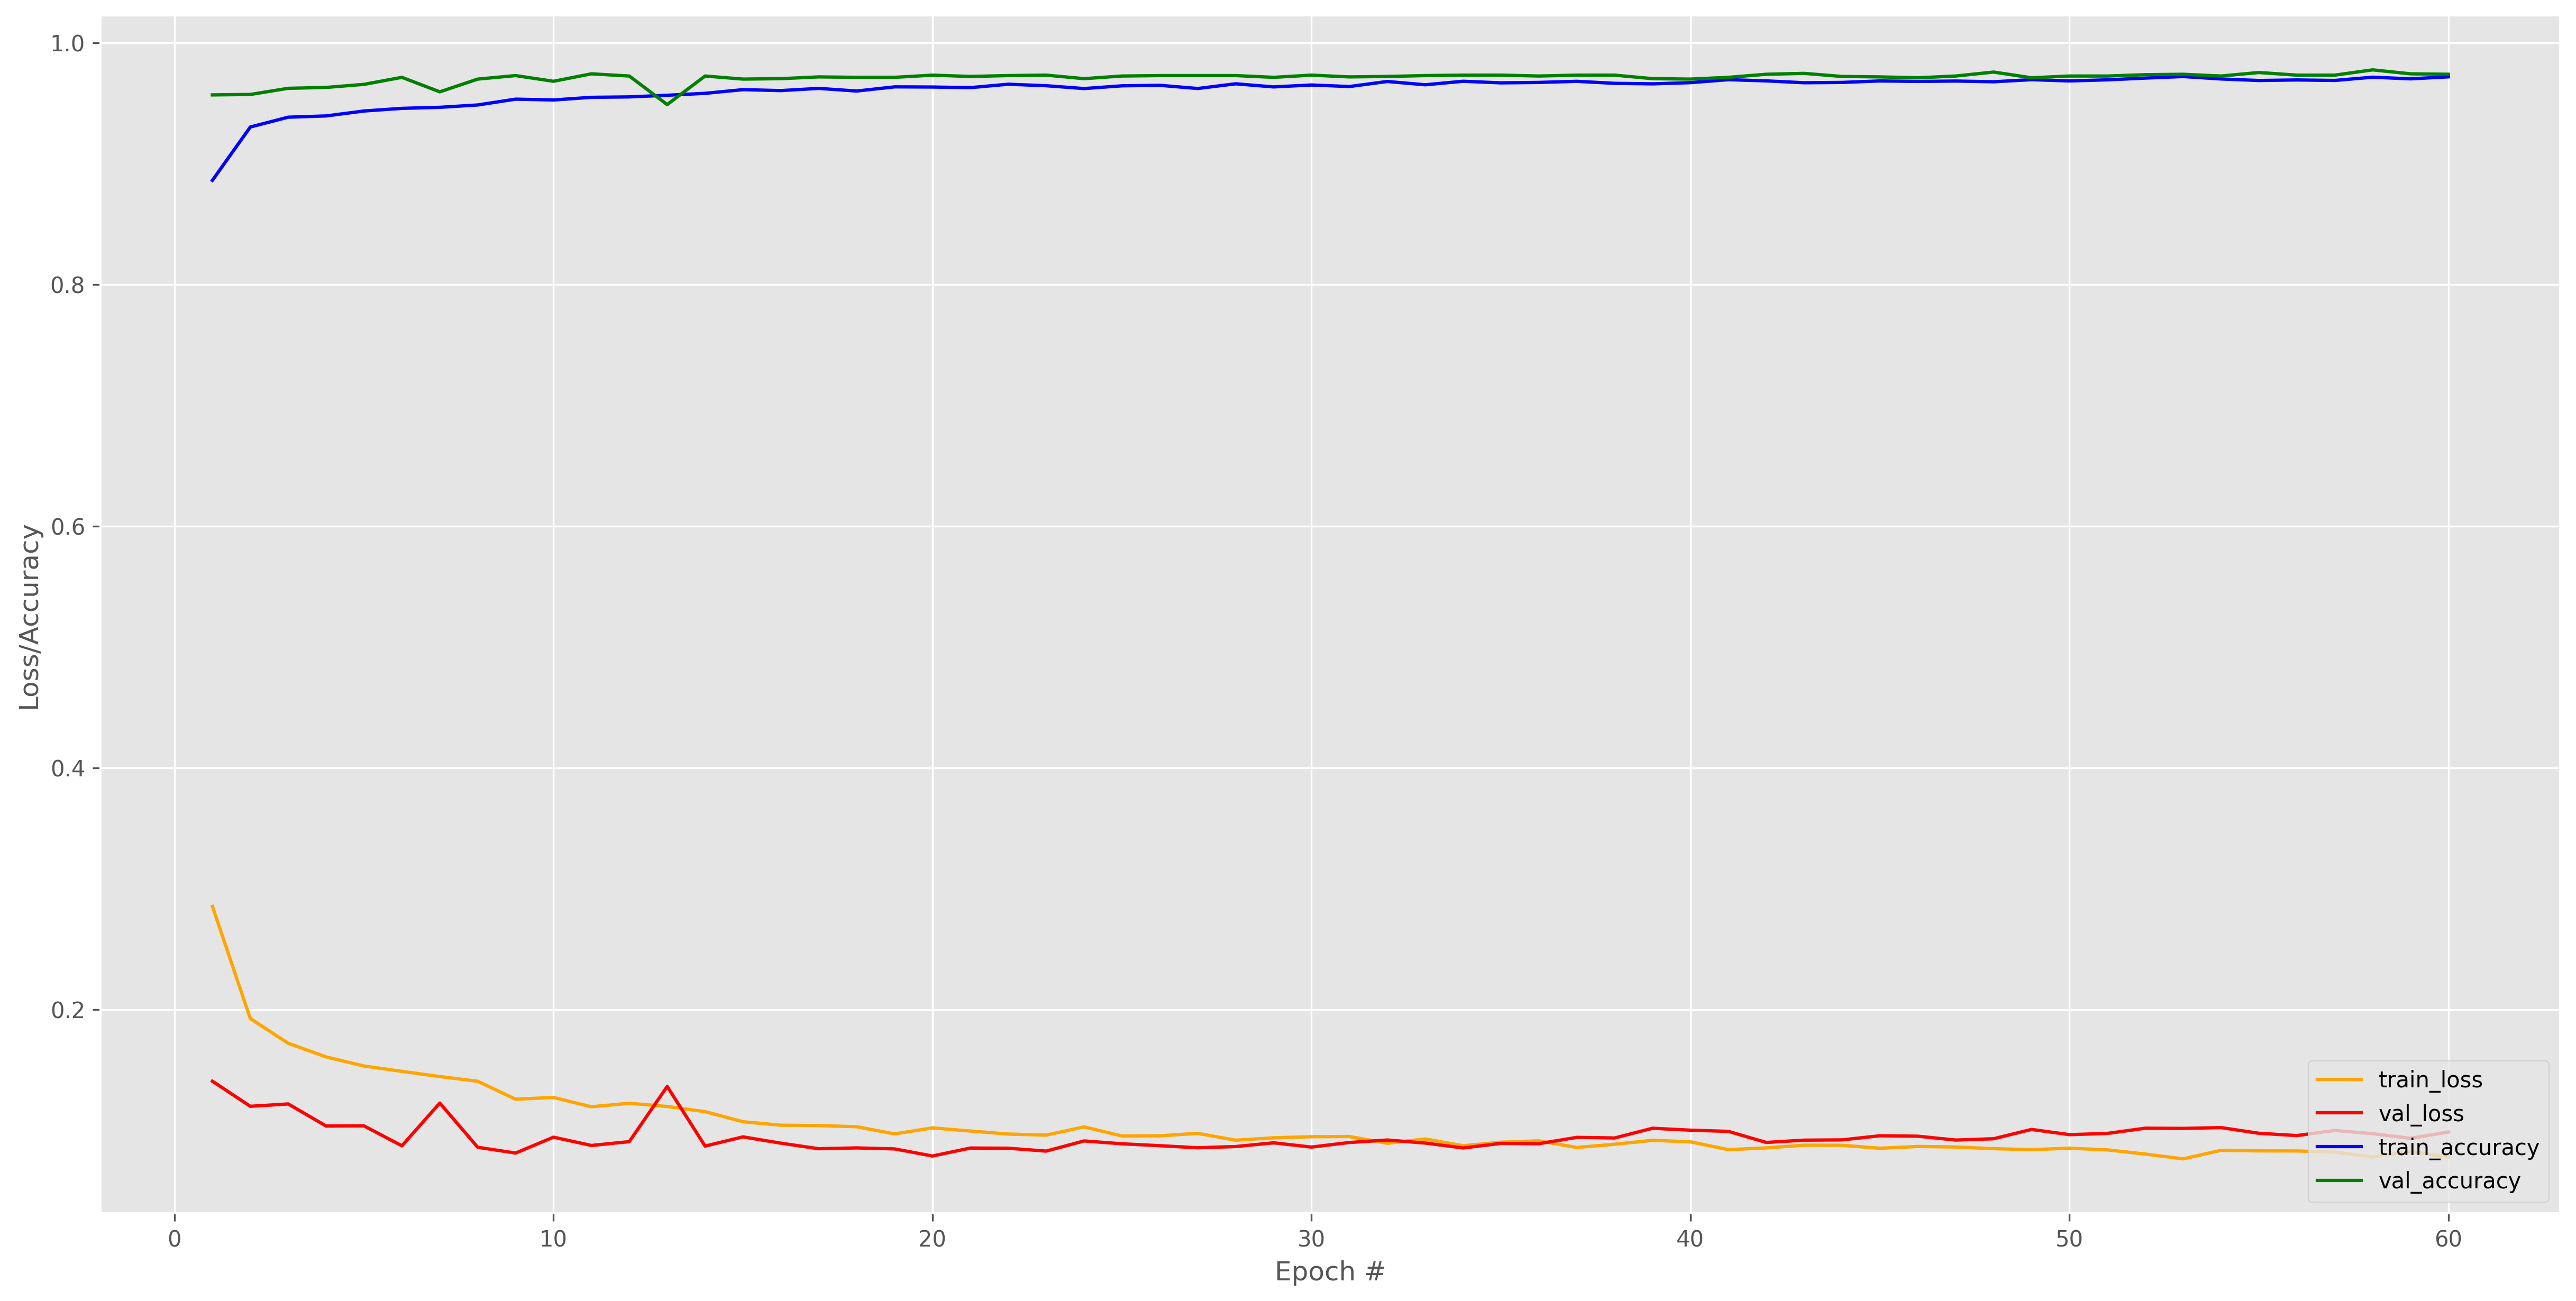

In [153]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_accuracy")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("logs/InceptionResnet_custom_plot.png")

In [154]:
#Evaluate the model by loading the best weights
custom_model.load_weights('weights/custom_cnn.h5')

#evaluate accuracy
custom_y_pred = custom_model.predict(validation_generator,
                                               nb_validation_samples/batch_size, workers=1)
accuracy = accuracy_score(Y_test,custom_y_pred.argmax(axis=-1))
print('The accuracy of the Custom model is: ', accuracy)

#evaluate mean squared error
custom_mse = mean_squared_error(Y_test,custom_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Custom model is: ', custom_mse)

#evaluate mean squared log error
custom_msle = mean_squared_log_error(Y_test,custom_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Custom model is: ', custom_msle)

The accuracy of the Custom model is:  0.9615384615384616
The Mean Squared Error of the Custom model is:  0.038461538461538464
The Mean Squared Log Error of the Custom model is:  0.018478962073776976


                   precision    recall  f1-score   support

class 0(abnormal)     0.9760    0.9463    0.9609      1378
  class 1(normal)     0.9479    0.9768    0.9621      1378

         accuracy                         0.9615      2756
        macro avg     0.9620    0.9615    0.9615      2756
     weighted avg     0.9620    0.9615    0.9615      2756

Confusion matrix, without normalization
[[1304   74]
 [  32 1346]]


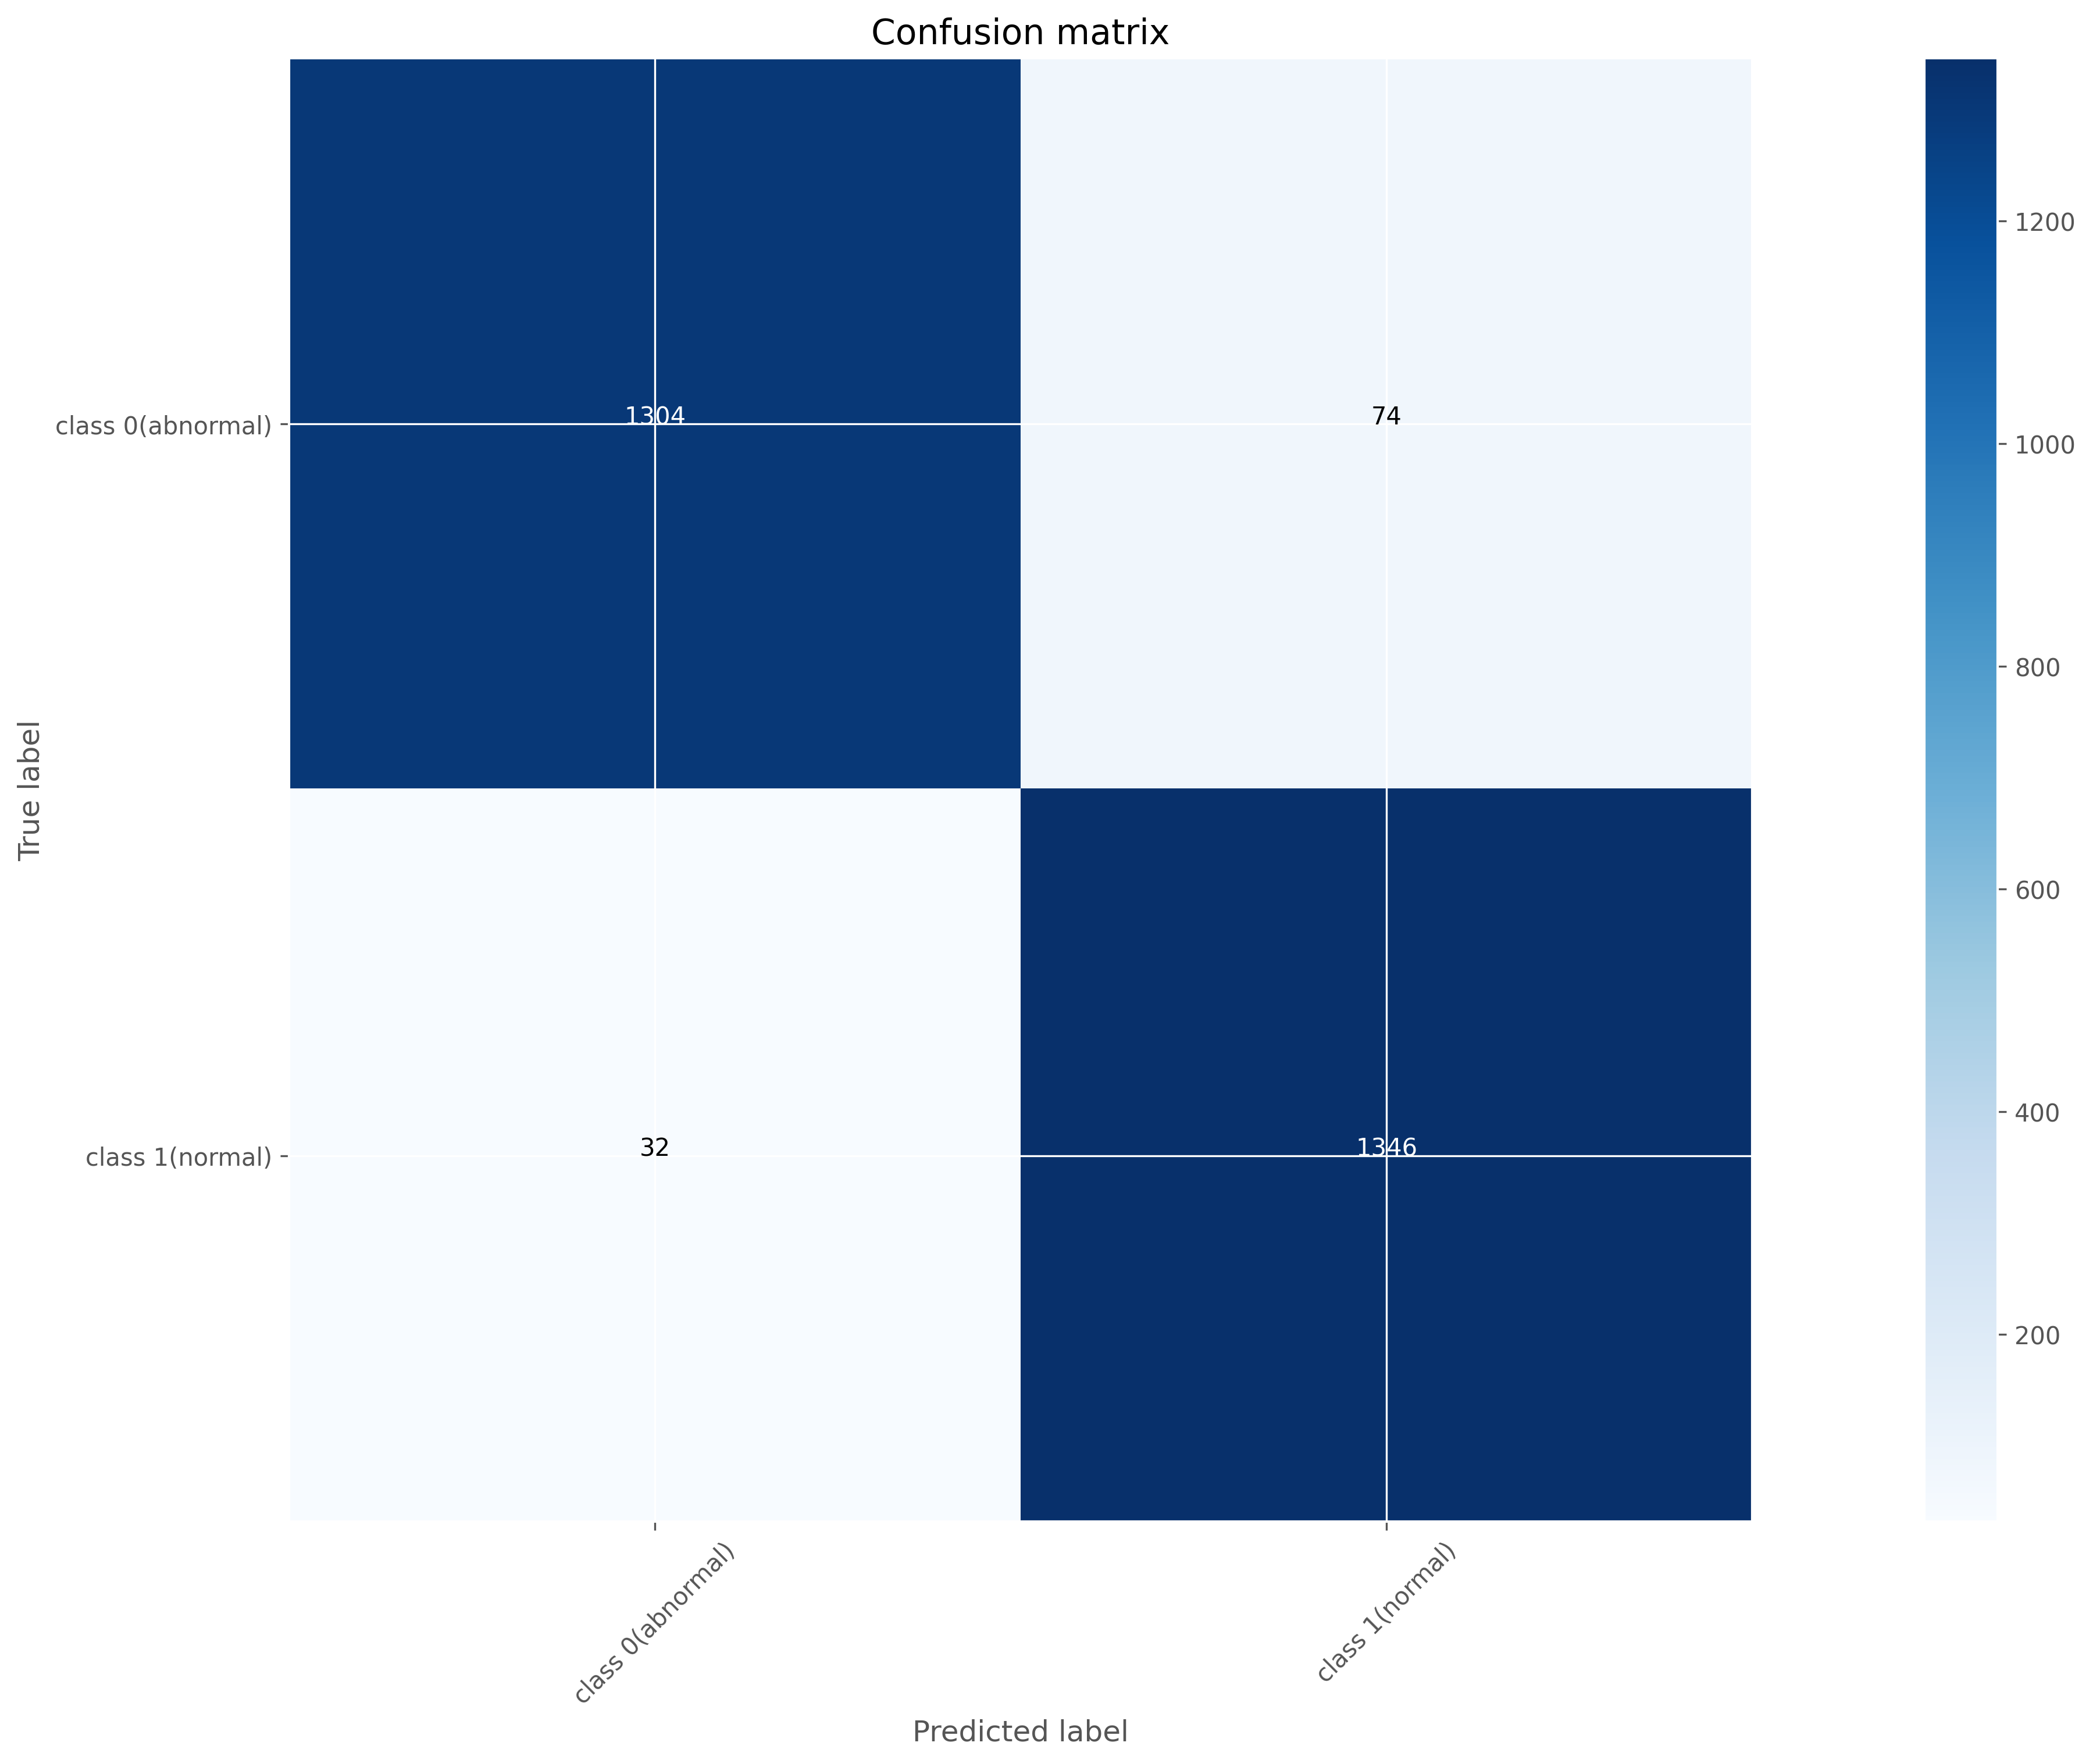

In [155]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,custom_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,custom_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


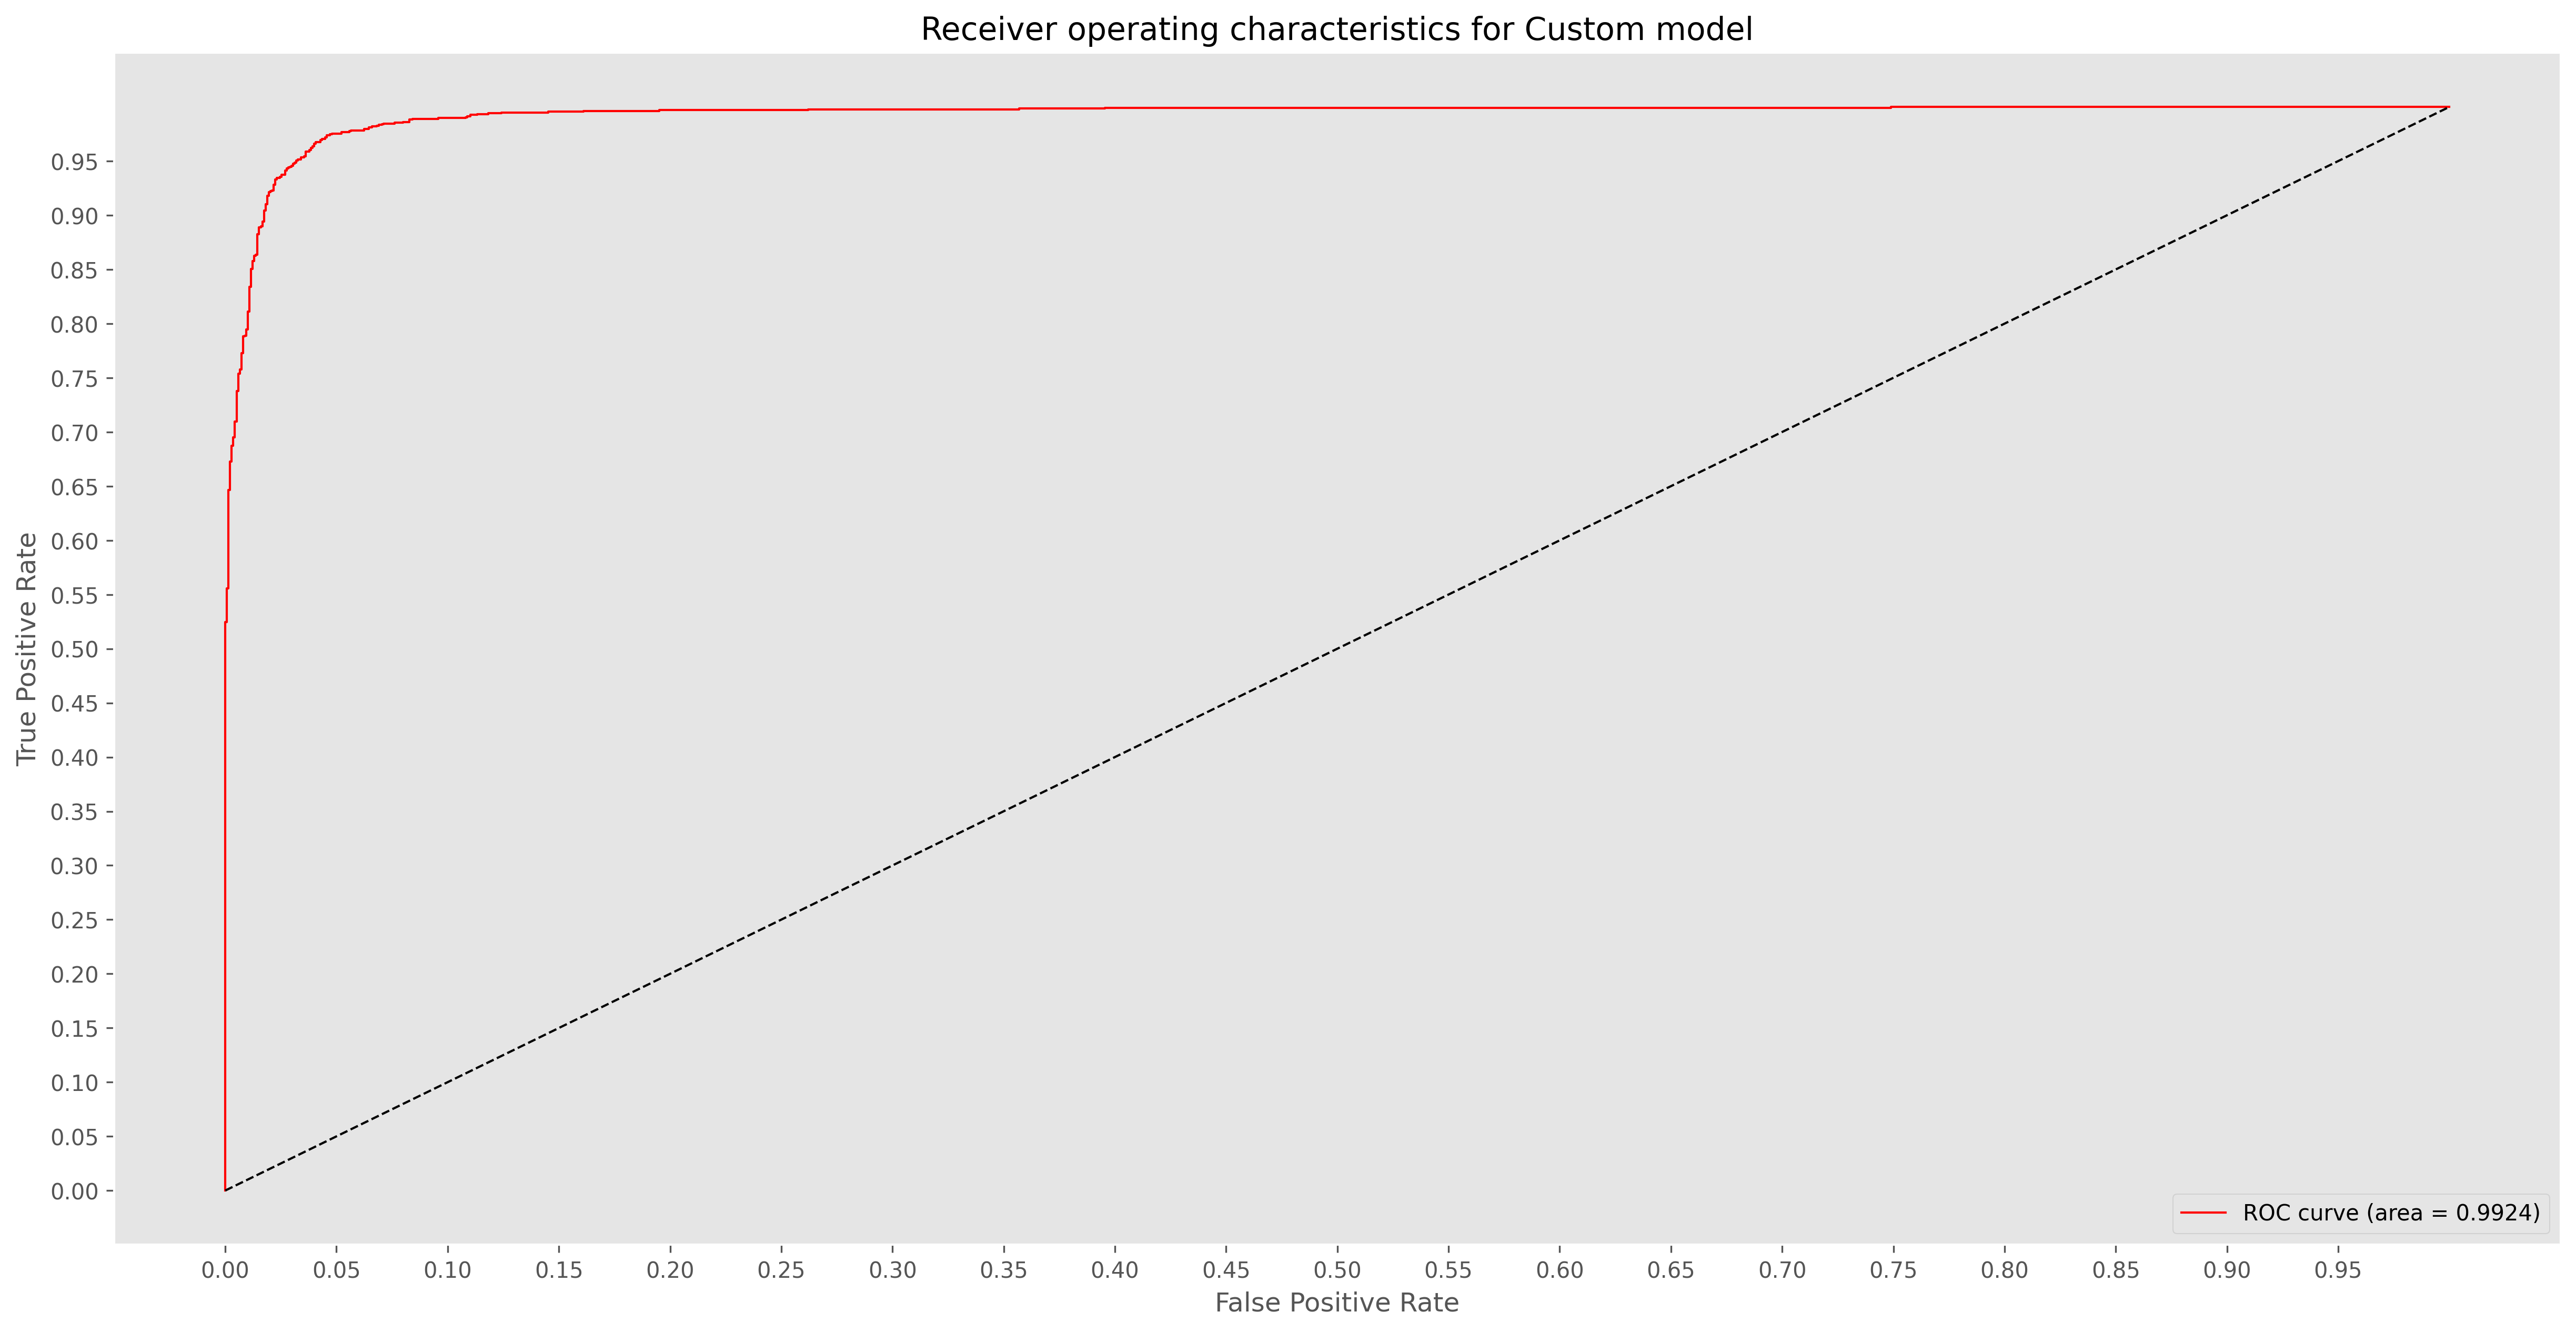

In [156]:
#%% compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, custom_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for Custom model')
plt.legend(loc="lower right")
plt.show()

In [157]:
#Evaluate the model by loading the best weights 
vgg19_custom_model.load_weights('weights/vgg19_custom.h5')

#evaluate accuracy
vgg19_custom_y_pred = vgg19_custom_model.predict(validation_generator,
                                                           nb_validation_samples/batch_size, workers=1)
vgg19_accuracy = accuracy_score(Y_test,vgg19_custom_y_pred.argmax(axis=-1))
print('The accuracy of the VGG19 Custom model is: ', vgg19_accuracy)

#evaluate mean squared error
vgg19_custom_mse = mean_squared_error(Y_test,vgg19_custom_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the VGG19 Custom model is: ', vgg19_custom_mse)

#evaluate mean squared log error
vgg19_custom_msle = mean_squared_log_error(Y_test,vgg19_custom_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the VGG19 Custom model is: ', vgg19_custom_msle)

The accuracy of the VGG19 Custom model is:  0.9749637155297532
The Mean Squared Error of the VGG19 Custom model is:  0.025036284470246733
The Mean Squared Log Error of the VGG19 Custom model is:  0.012028758331043502


                   precision    recall  f1-score   support

class 0(abnormal)     0.9816    0.9681    0.9748      1378
  class 1(normal)     0.9685    0.9819    0.9751      1378

         accuracy                         0.9750      2756
        macro avg     0.9751    0.9750    0.9750      2756
     weighted avg     0.9751    0.9750    0.9750      2756

Confusion matrix, without normalization
[[1334   44]
 [  25 1353]]


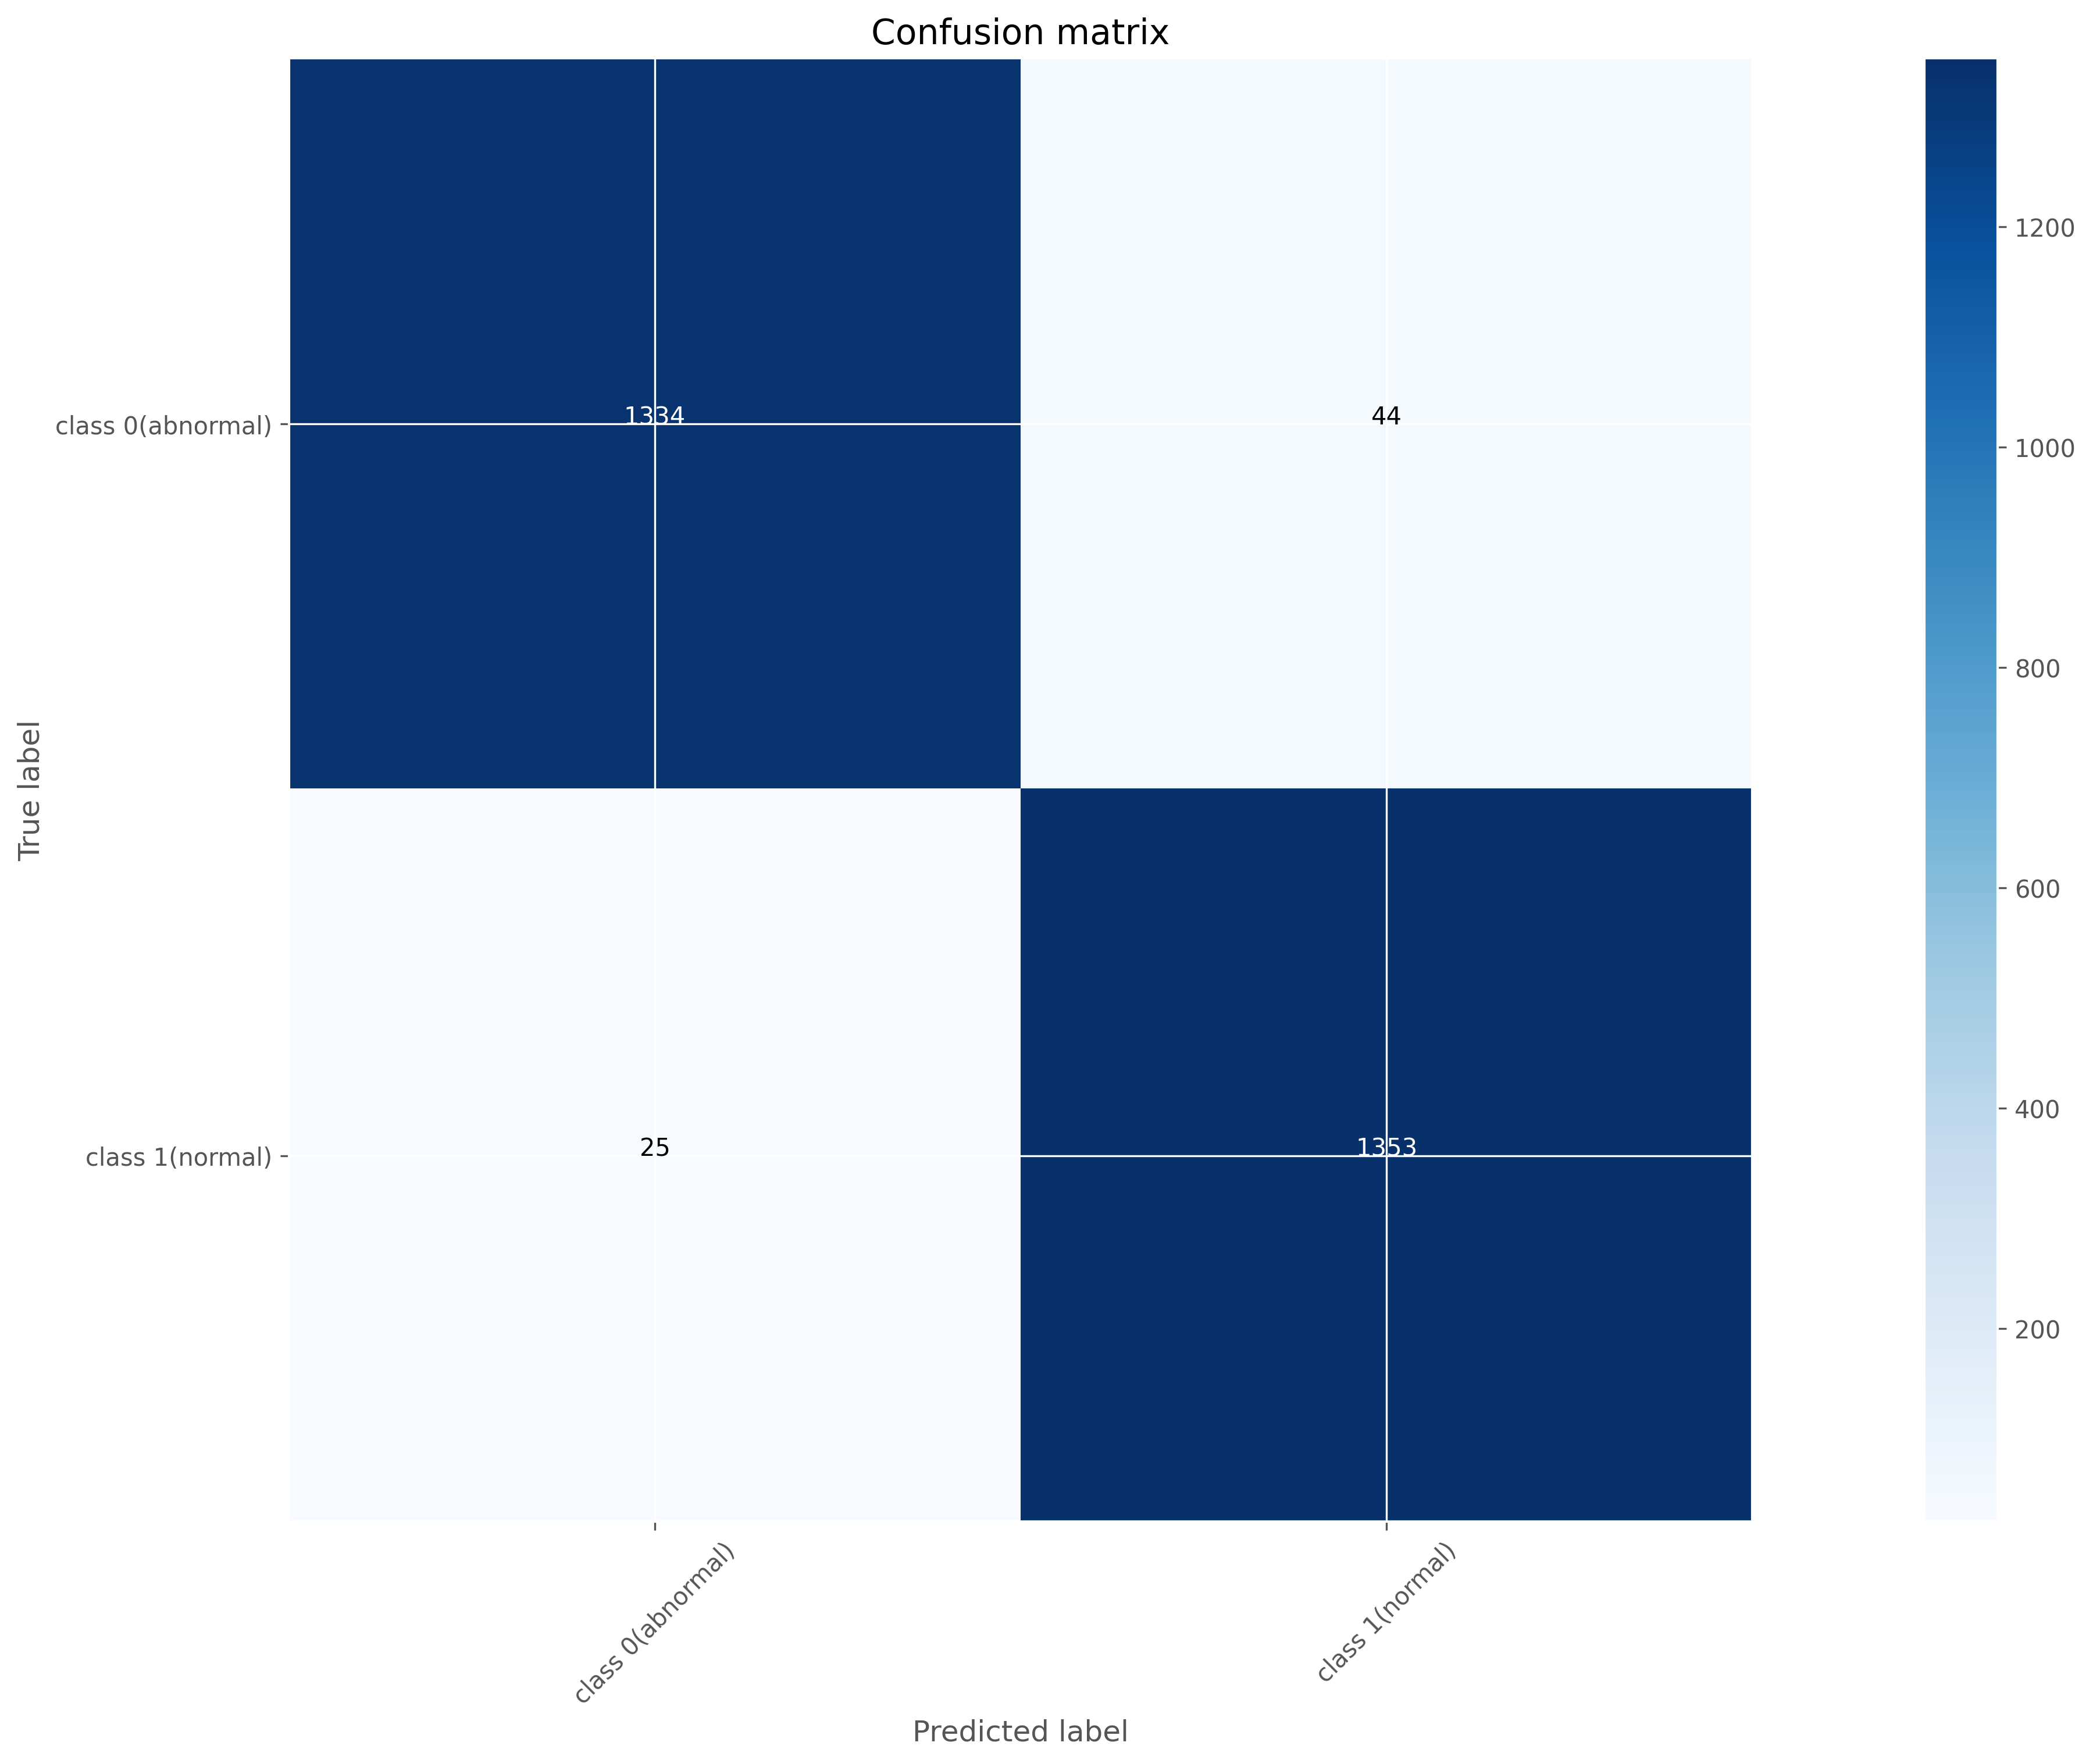

In [158]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,vgg19_custom_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,vgg19_custom_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


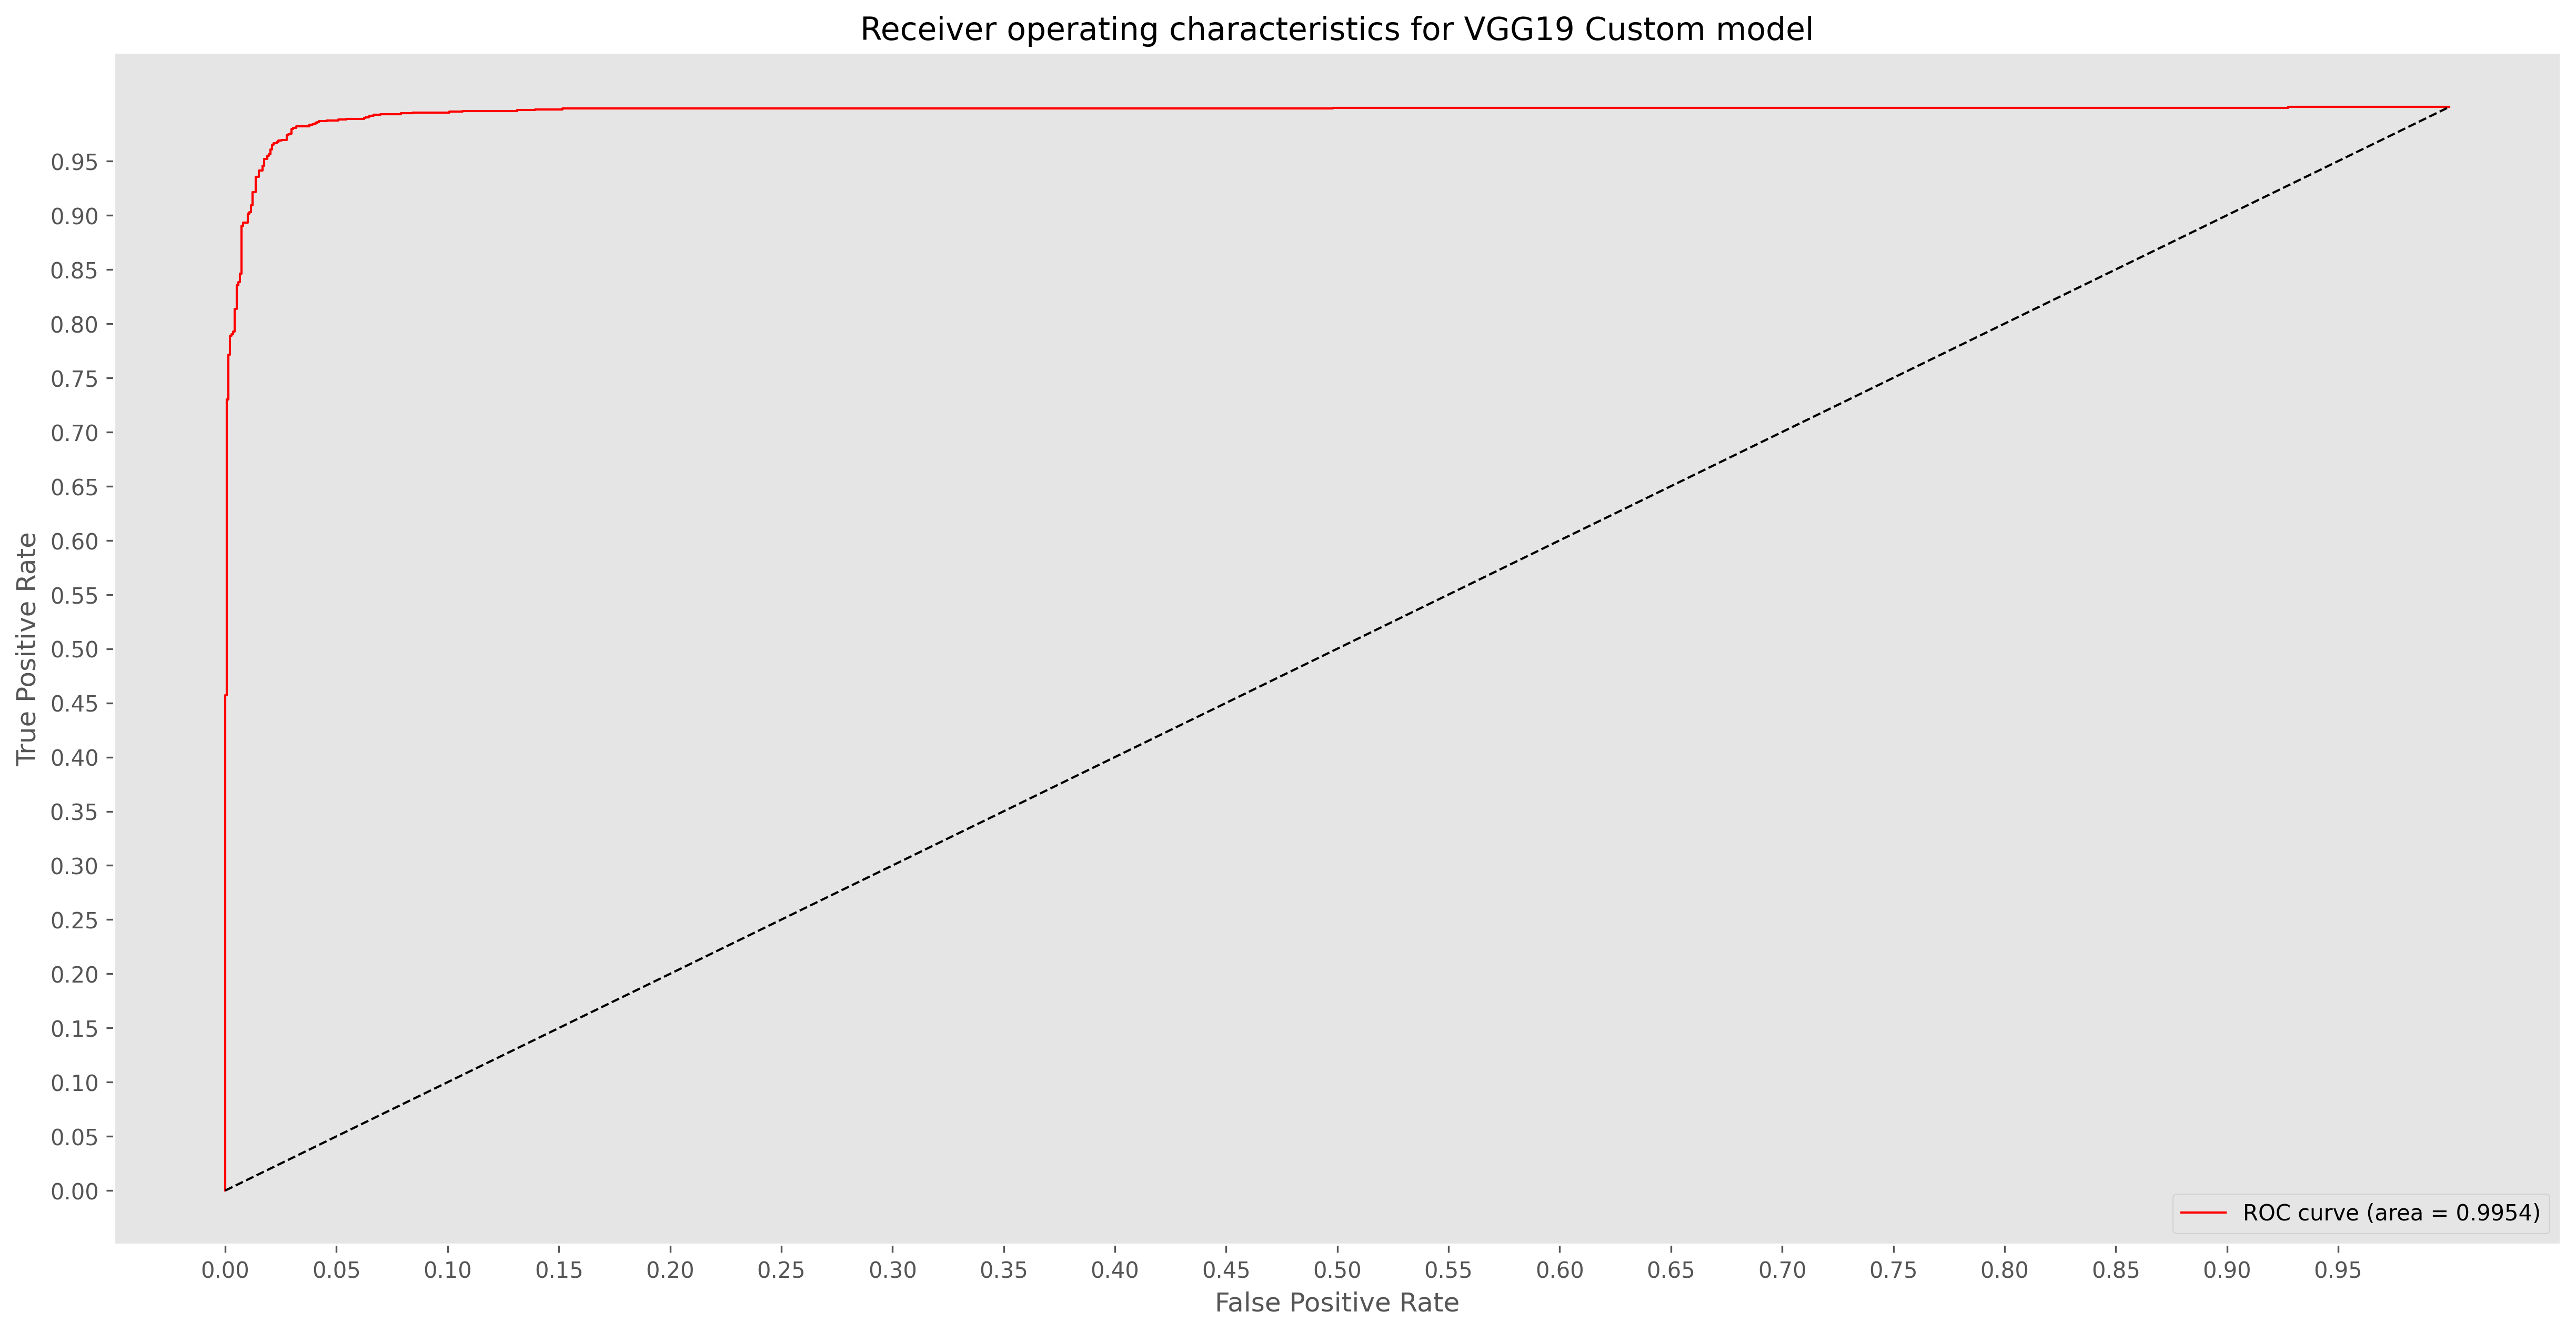

In [159]:
#%% compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, vgg19_custom_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for VGG19 Custom model')
plt.legend(loc="lower right")
plt.show()


In [160]:
#Evaluate the model by loading the best weights 
squeeze_custom_model.load_weights('weights/squeeze_custom.h5')

#evaluate accuracy

squeeze_y_pred = squeeze_custom_model.predict(validation_generator,
                                                        nb_validation_samples/batch_size, workers=1)
squeeze_accuracy = accuracy_score(Y_test,squeeze_y_pred.argmax(axis=-1))
print('The accuracy of the SqueezeNet Custom model is: ', squeeze_accuracy)

#evaluate mean squared error

squeeze_custom_mse = mean_squared_error(Y_test,squeeze_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the SqueezeNet Custom model is: ', squeeze_custom_mse)

#evaluate mean squared log error

squeeze_custom_msle = mean_squared_log_error(Y_test,squeeze_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the SqueezeNet Custom model is: ', squeeze_custom_msle)

The accuracy of the SqueezeNet Custom model is:  0.9716981132075472
The Mean Squared Error of the SqueezeNet Custom model is:  0.02830188679245283
The Mean Squared Log Error of the SqueezeNet Custom model is:  0.0135977268090057


                   precision    recall  f1-score   support

class 0(abnormal)     0.9786    0.9644    0.9715      1378
  class 1(normal)     0.9649    0.9790    0.9719      1378

         accuracy                         0.9717      2756
        macro avg     0.9718    0.9717    0.9717      2756
     weighted avg     0.9718    0.9717    0.9717      2756

Confusion matrix, without normalization
[[1329   49]
 [  29 1349]]


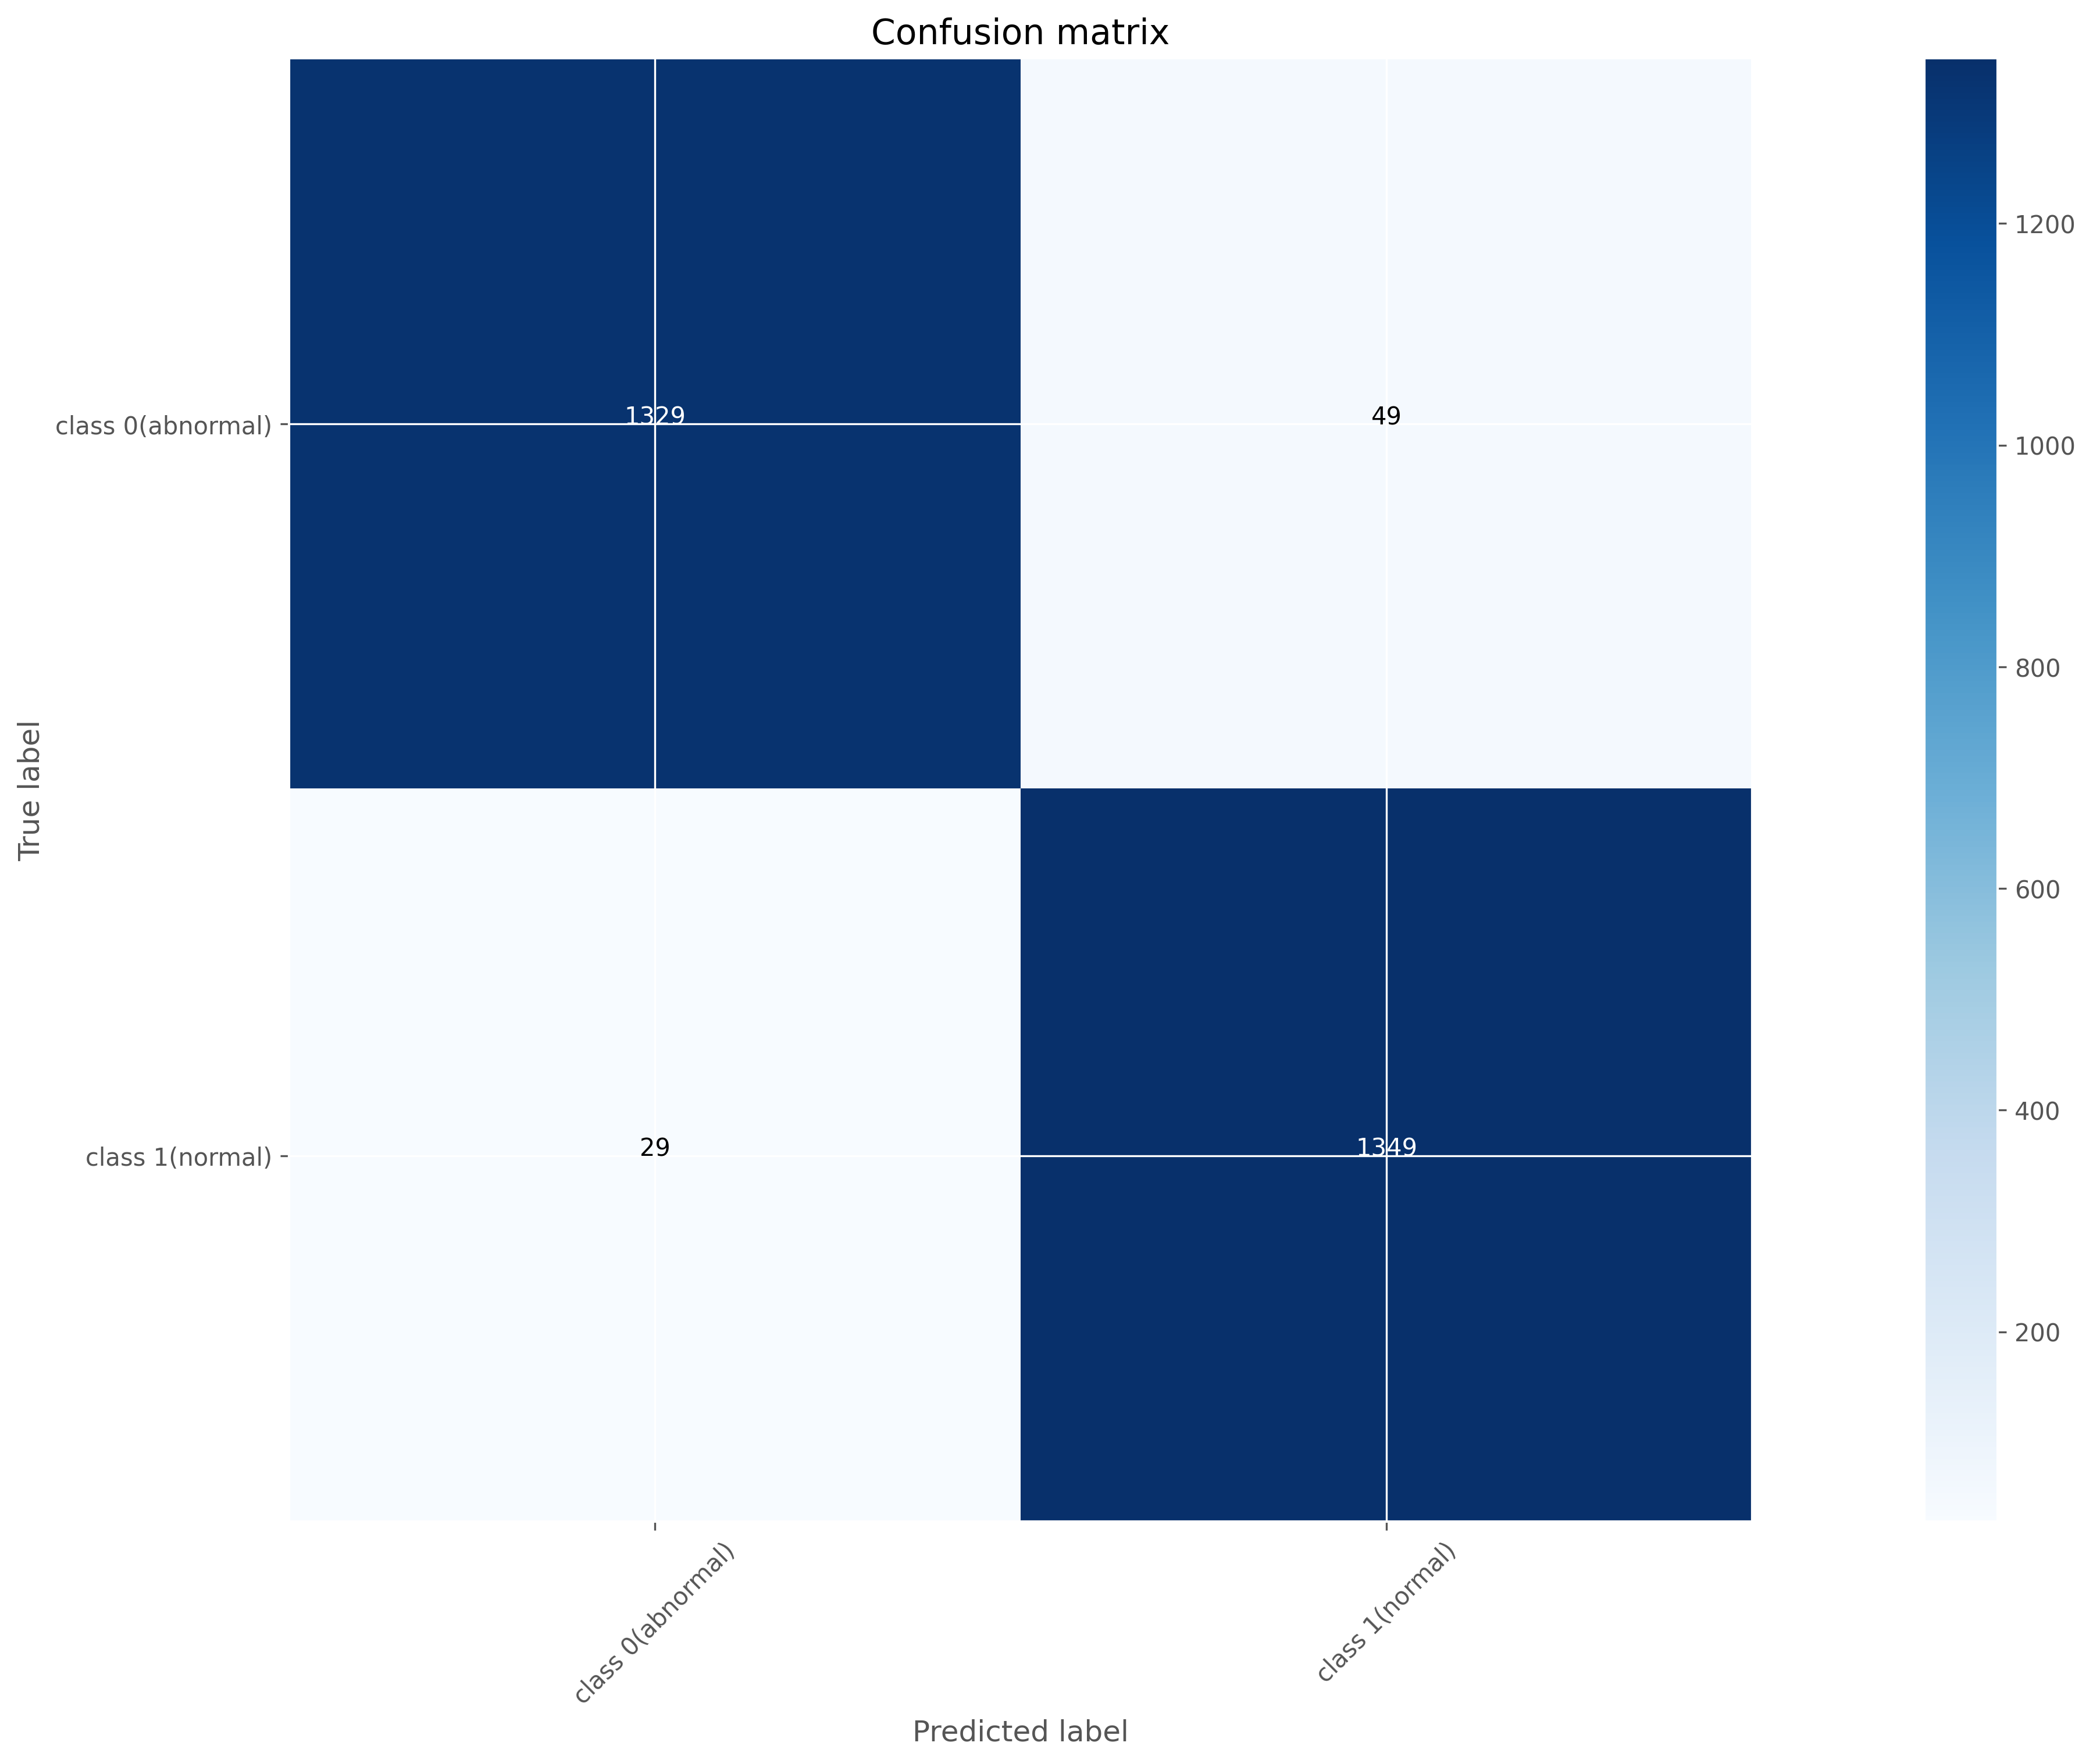

In [161]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,squeeze_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,squeeze_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


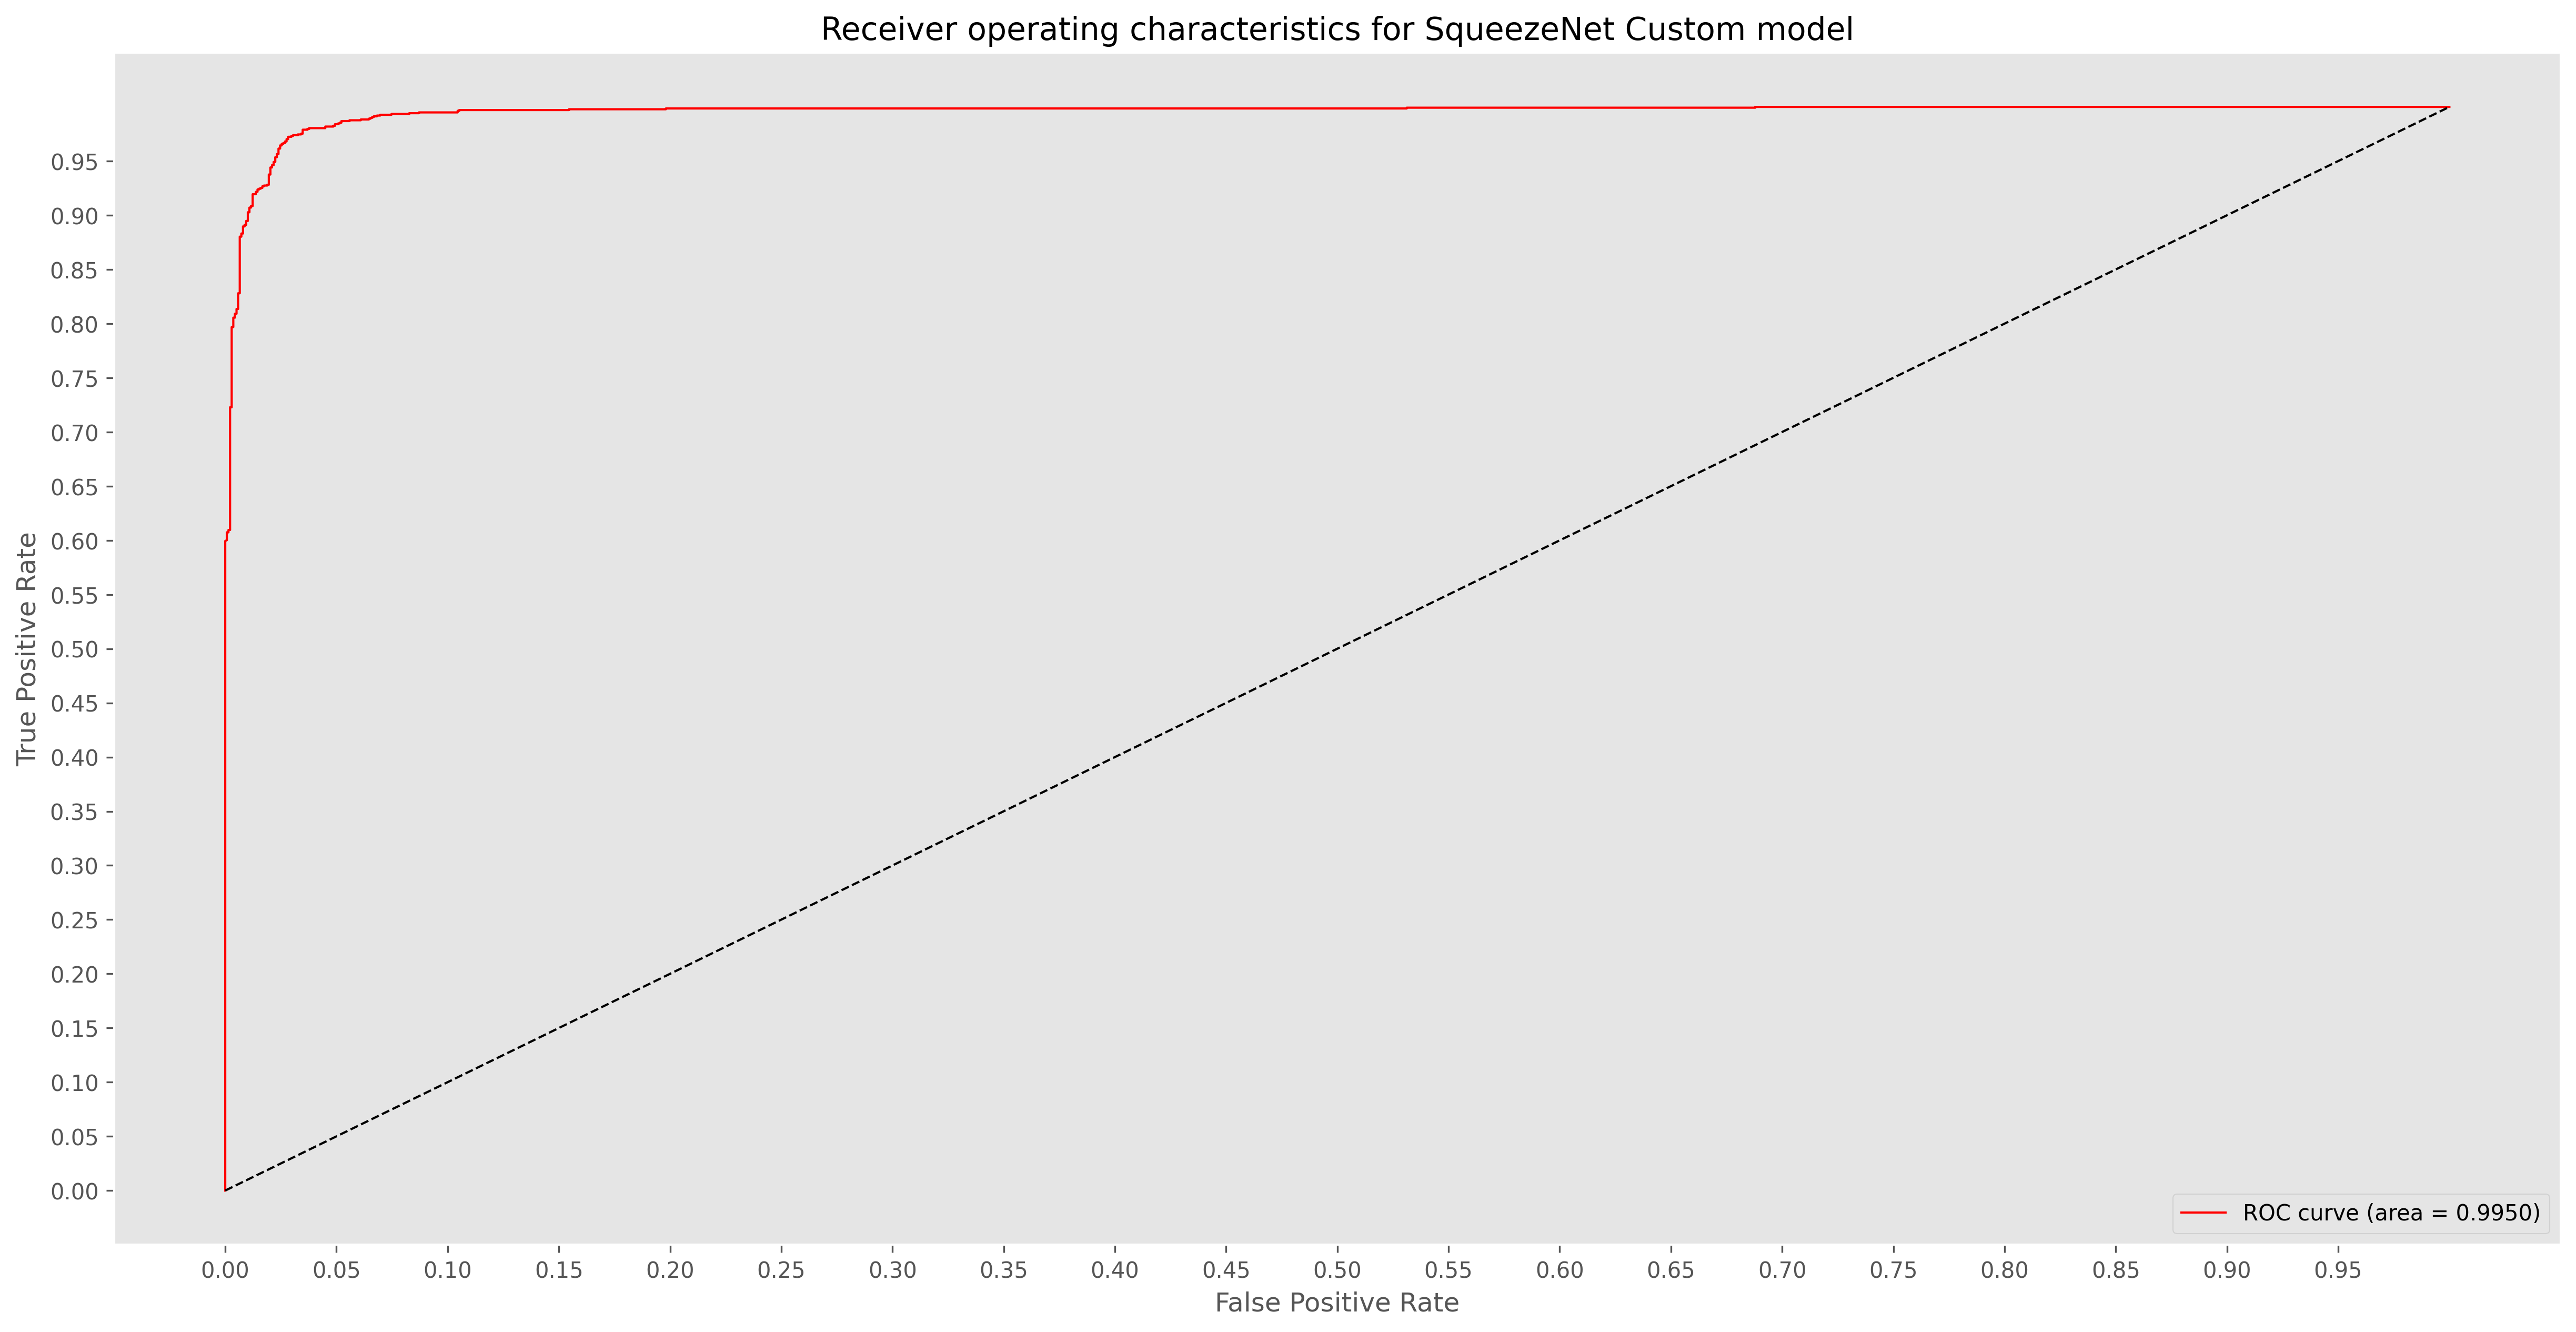

In [162]:
#%% compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, squeeze_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for SqueezeNet Custom model')
plt.legend(loc="lower right")
plt.show()


In [163]:
#Evaluate the model by loading the best weights 
inceptionresnet_custom_model.load_weights('weights/InceptionResnet_custom.h5')

#evaluate accuracy
incepres_y_pred = inceptionresnet_custom_model.predict(validation_generator,
                                                                 nb_validation_samples/batch_size, workers=1)
incepres_accuracy = accuracy_score(Y_test,incepres_y_pred.argmax(axis=-1))
print('The accuracy of the InceptionResNetV2 Custom model is: ', incepres_accuracy)

#evaluate mean squared error
incepres_custom_mse = mean_squared_error(Y_test,incepres_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the InceptionResNetv2 Custom model is: ', incepres_custom_mse)

#evaluate mean squared log error
incepres_custom_msle = mean_squared_log_error(Y_test,incepres_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the InceptionResNetv2 Custom model is: ', incepres_custom_msle)

The accuracy of the InceptionResNetV2 Custom model is:  0.9775036284470247
The Mean Squared Error of the InceptionResNetv2 Custom model is:  0.022496371552975326
The Mean Squared Log Error of the InceptionResNetv2 Custom model is:  0.010808449514850684


                   precision    recall  f1-score   support

class 0(abnormal)     0.9860    0.9688    0.9773      1378
  class 1(normal)     0.9693    0.9862    0.9777      1378

         accuracy                         0.9775      2756
        macro avg     0.9776    0.9775    0.9775      2756
     weighted avg     0.9776    0.9775    0.9775      2756

Confusion matrix, without normalization
[[1335   43]
 [  19 1359]]


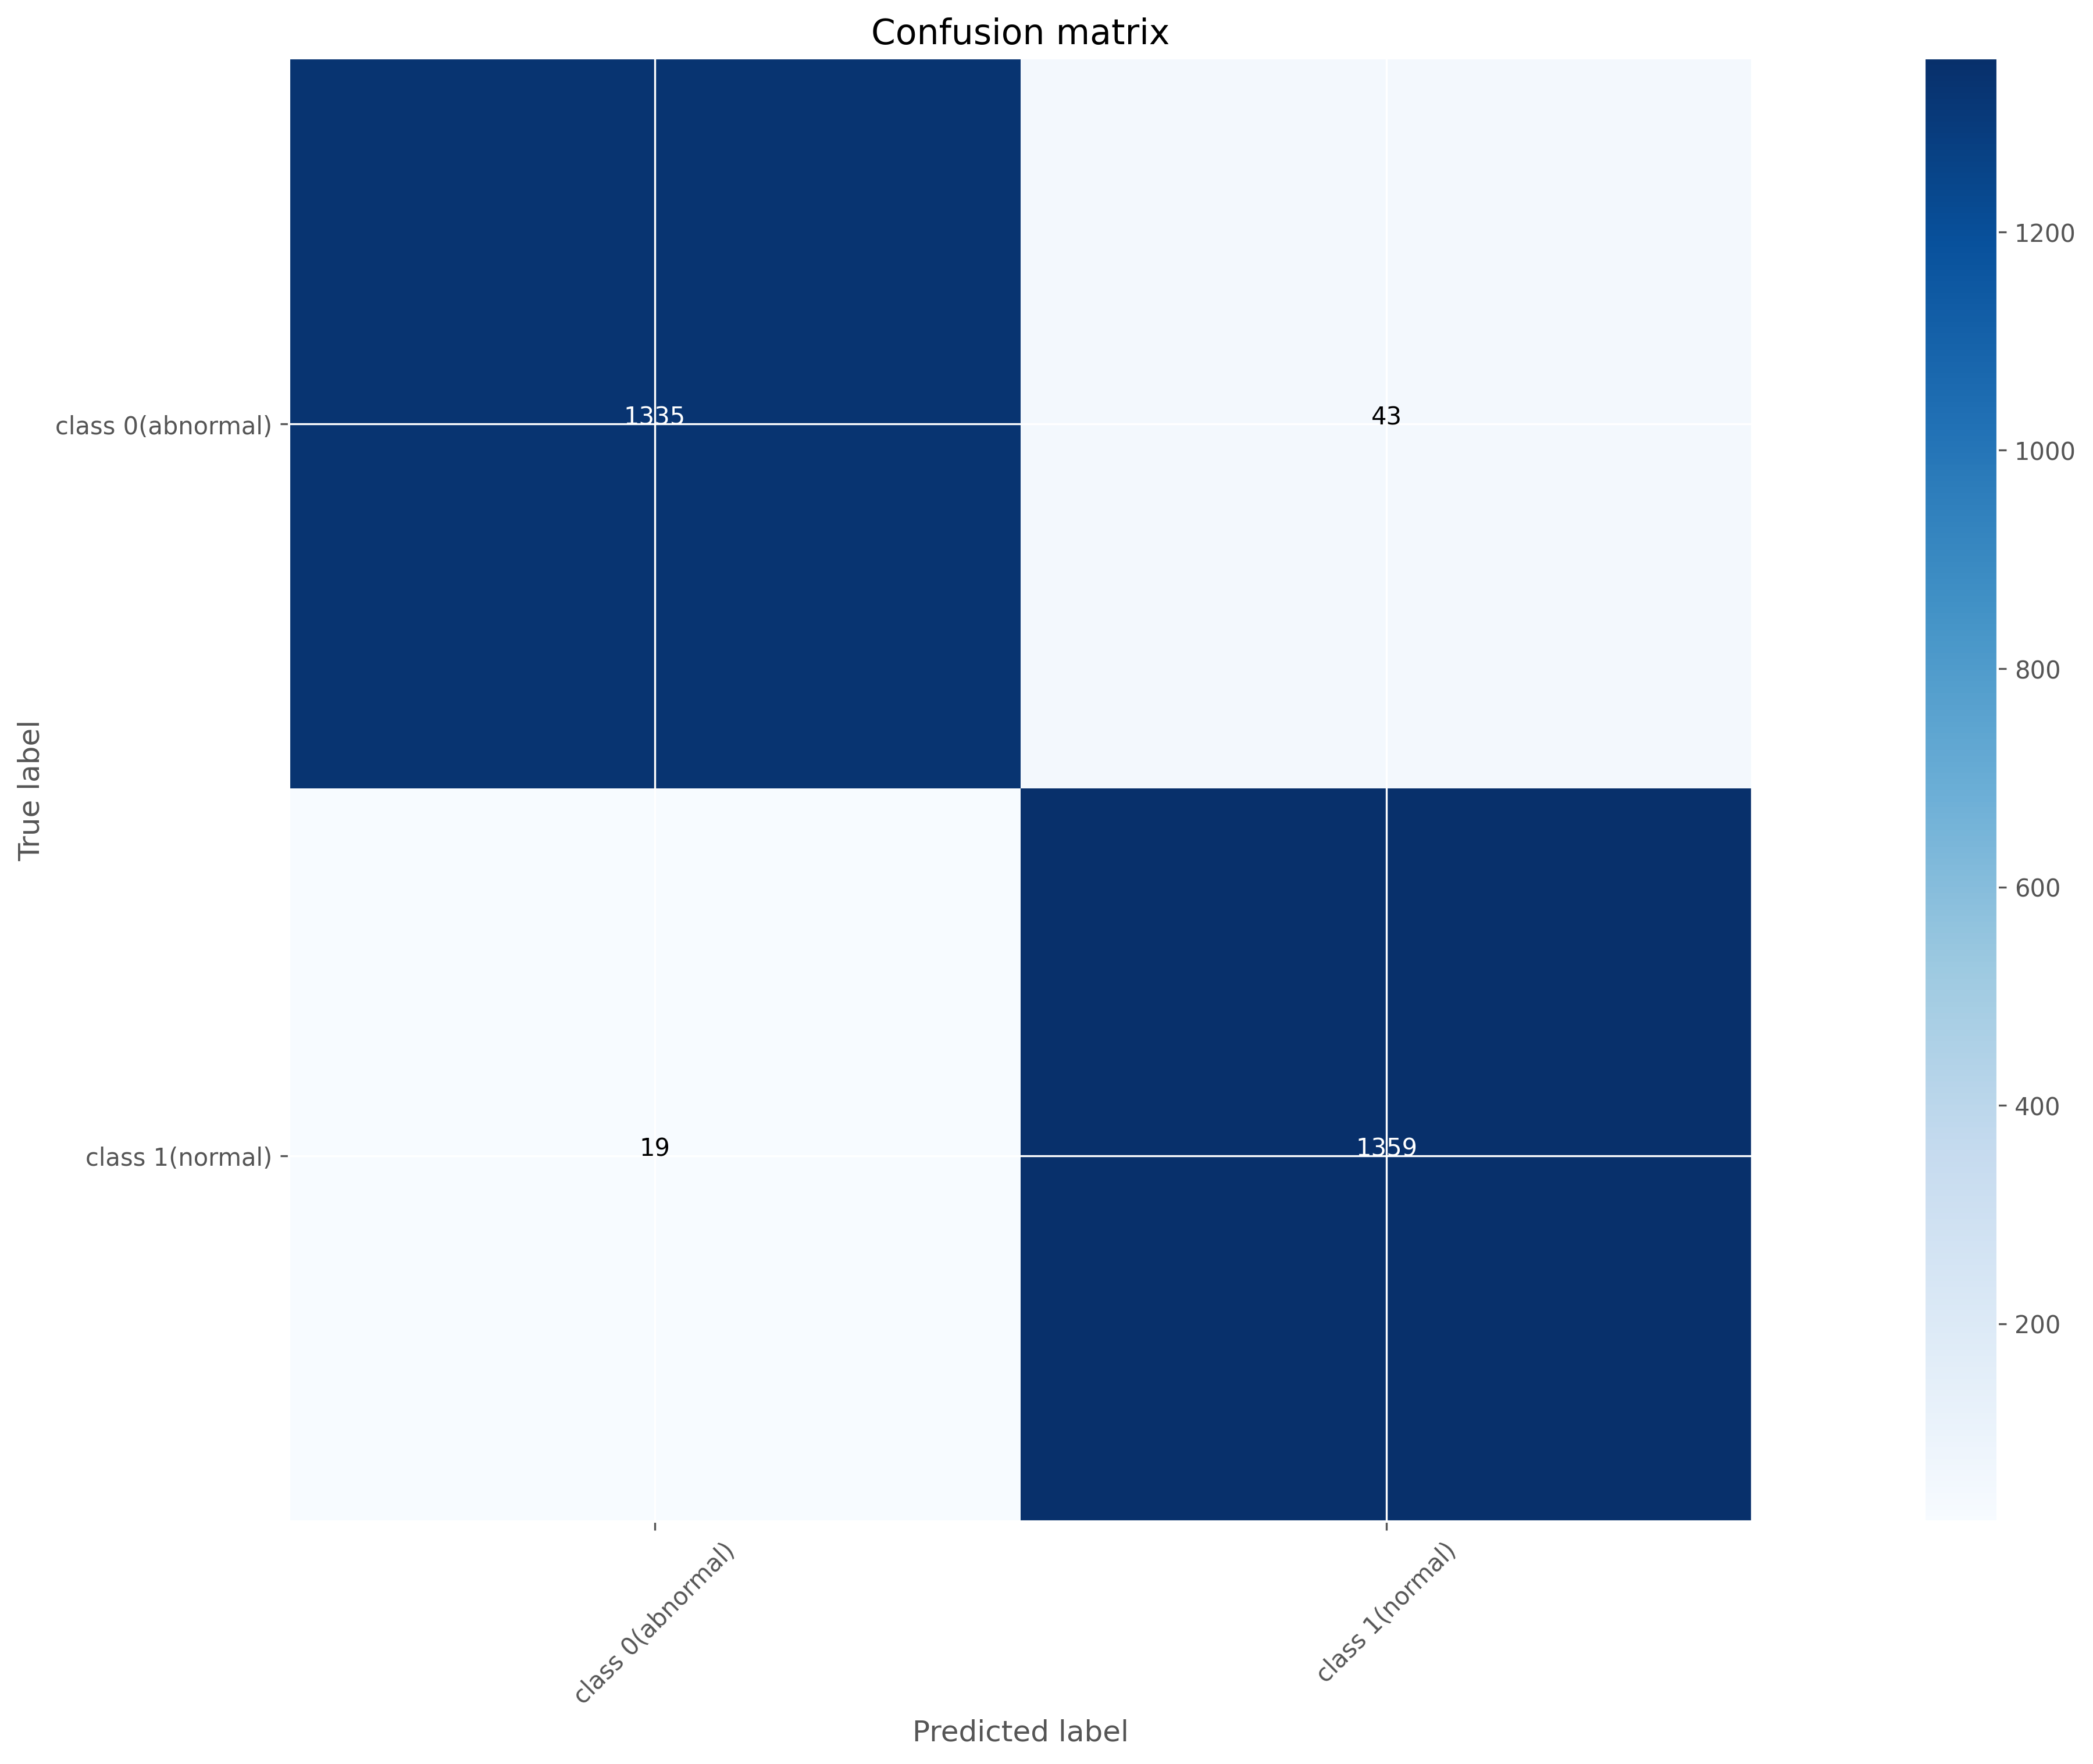

In [164]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,incepres_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,incepres_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


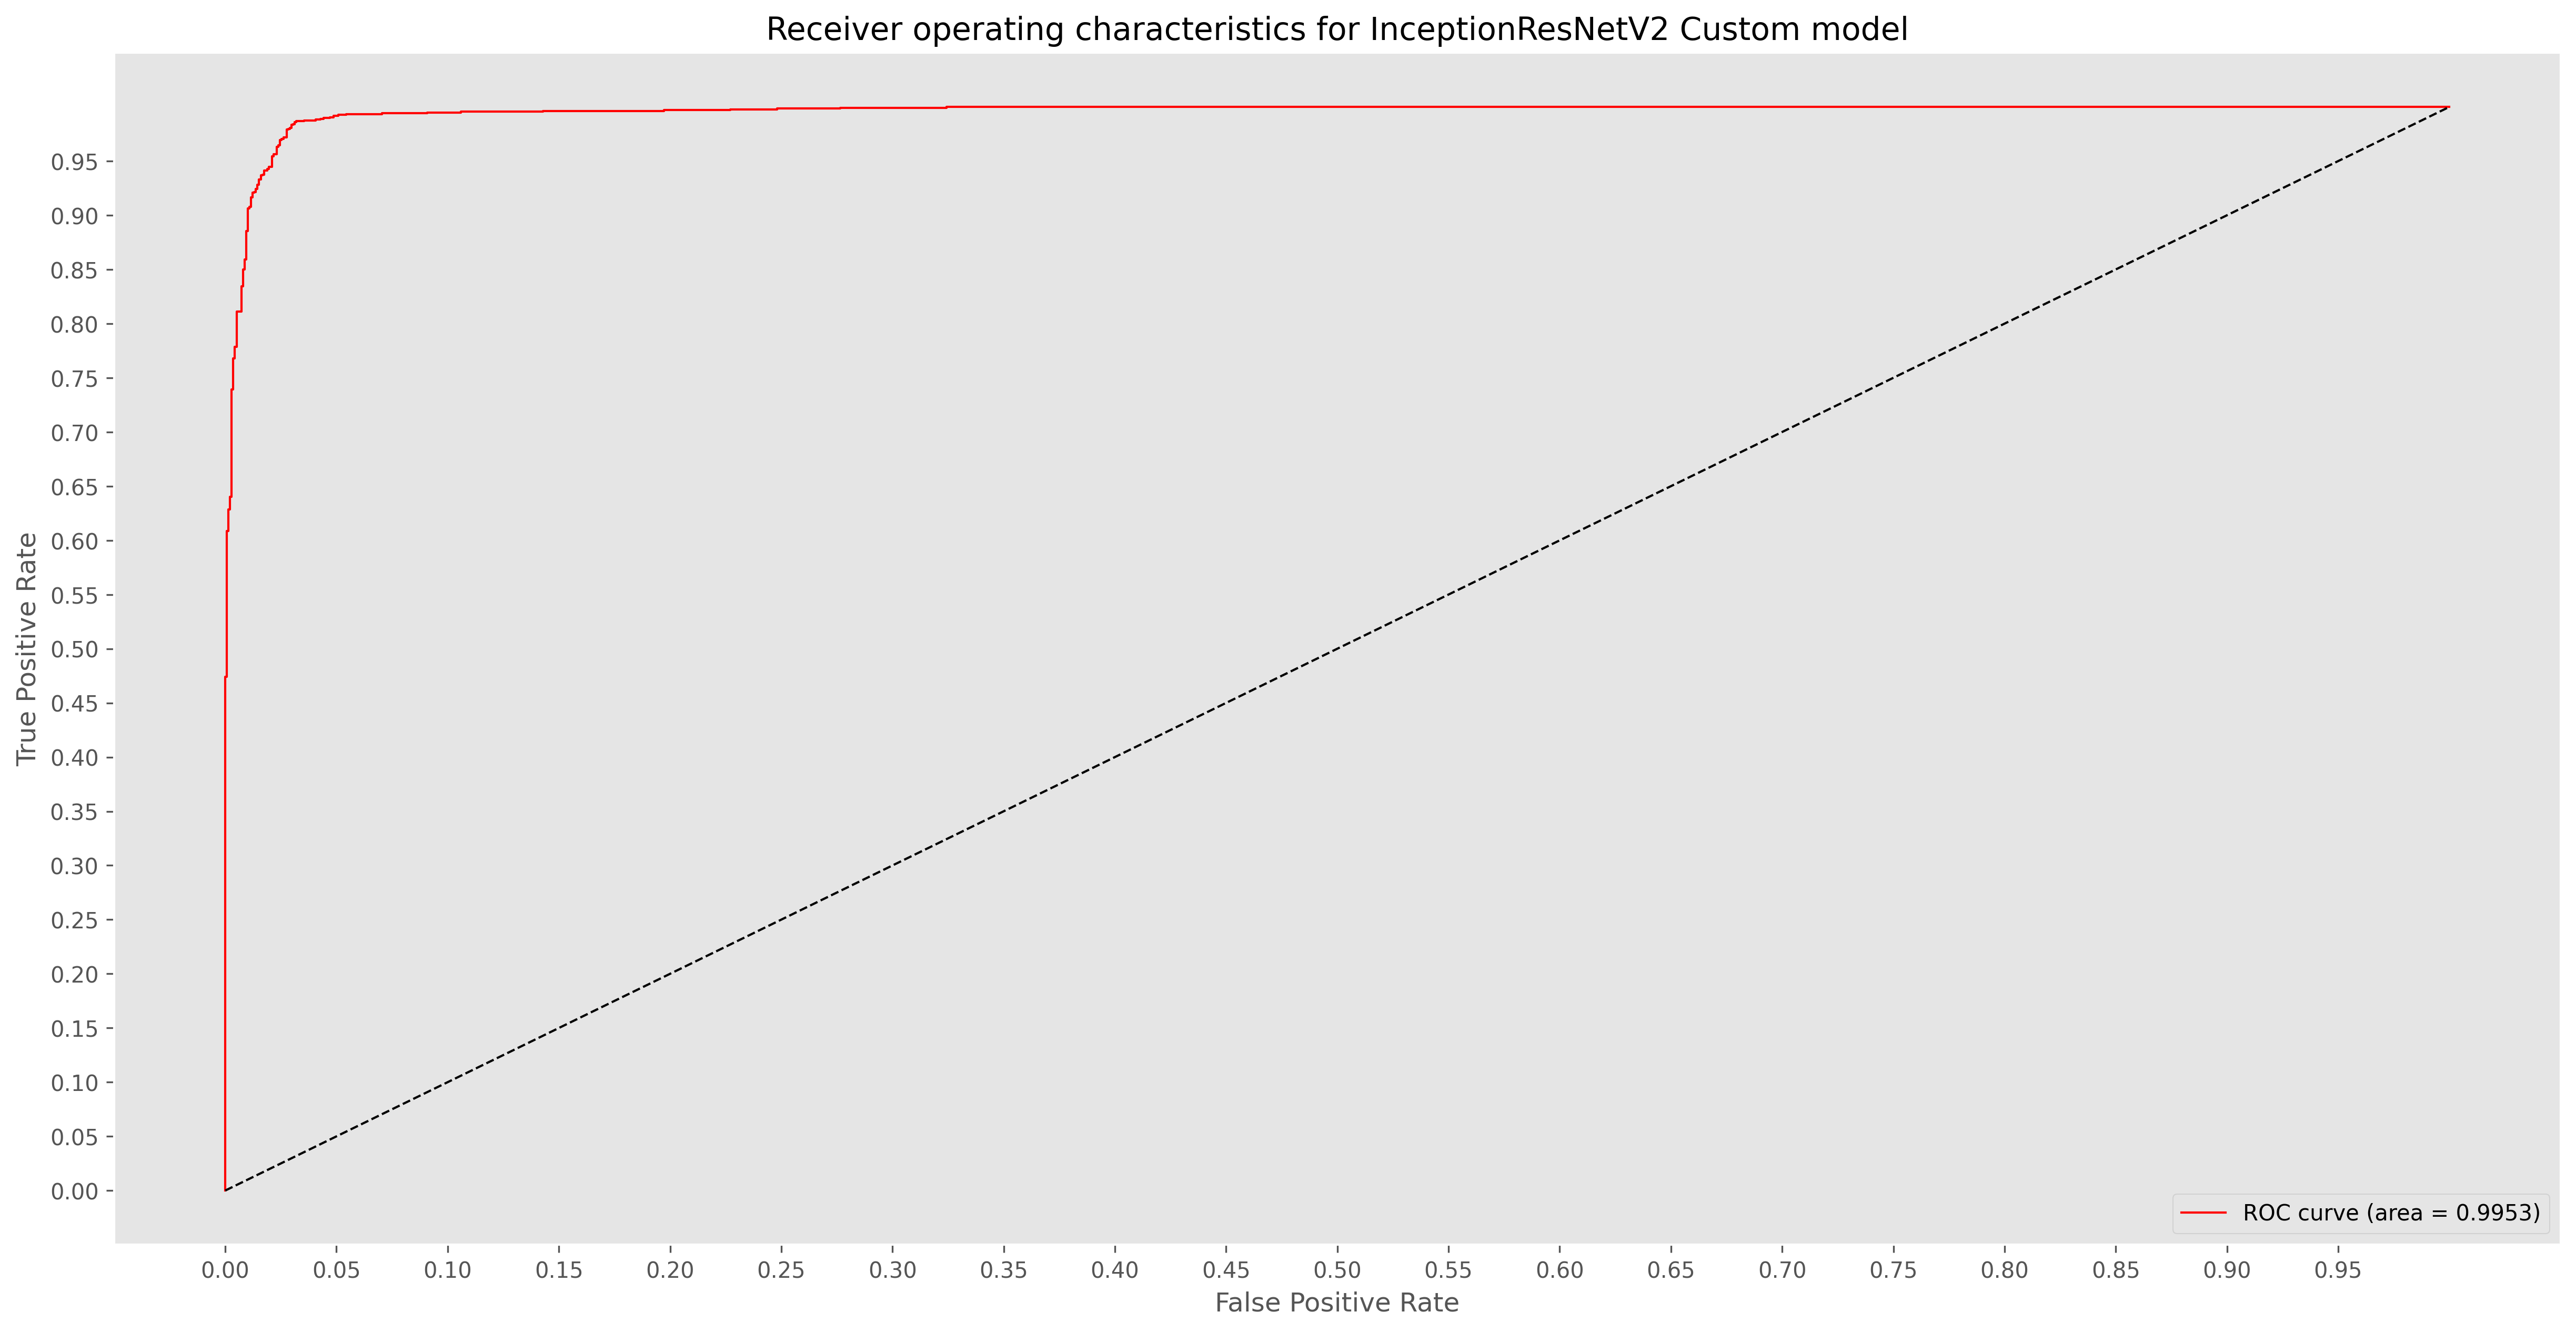

In [165]:
#%% compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, incepres_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for InceptionResNetV2 Custom model')
plt.legend(loc="lower right")
plt.show()


In [21]:
#%% construct the ensemble model
custom_model = custom_cnn(model_input)
vgg19_custom_model = vgg19_cnn(model_input)
squeeze_custom_model = squeeze_cnn(model_input)
inceptionresnet_custom_model = incepres_cnn(model_input)

#load the best weights
custom_model.load_weights('weights/custom_cnn.h5')
vgg19_custom_model.load_weights('weights/vgg19_custom.h5')
squeeze_custom_model.load_weights('weights/squeeze_custom.h5')
inceptionresnet_custom_model.load_weights('weights/InceptionResnet_custom.h5')

In [22]:
#append the models to the list

models = [custom_model, vgg19_custom_model, squeeze_custom_model, inceptionresnet_custom_model]

Ensemble model definition is very straightforward. It uses the same input layer thas is shared between all previous models. 
In the top layer, the ensemble computes the average of three models' outputs (predictions) by using Average() layer. The ensemble is expected to have a lower error rate than any single model and better accuracy.

In [23]:
def ensemble(models, model_input):
    
    outputs = [m.output for m in models]
    print(outputs)
    y = Average()(outputs) 
    model = Model(model_input, y, name='ensemble')
    return model

#istantitate the ensemble model and report the summary
ensemble_model = ensemble(models,model_input)

#save the ensemble model with the architecture and the weights together
ensemble_model.save('weights/ensemblemodel.h5')
print('The Ensemble Model is Saved')

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_5')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_6')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_7')>]
The Ensemble Model is Saved


In [24]:
#%% load the ensemble model and make predictions on the test data
ensemble_model=load_model('weights/ensemblemodel.h5')
ensemble_model.summary()
#plot_model(ensemble_model, to_file='ensemble_model.png',show_shapes=True, show_layer_names=False)

Model: "ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_406 (Conv2D)             (None, 49, 49, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_409 (BatchN (None, 49, 49, 32)   96          conv2d_406[0][0]                 
__________________________________________________________________________________________________
activation_406 (Activation)     (None, 49, 49, 32)   0           batch_normalization_409[0][0]    
___________________________________________________________________________________________

conv2d_559 (Conv2D)             (None, 4, 4, 128)    139264      block17_19_ac[0][0]              
__________________________________________________________________________________________________
batch_normalization_562 (BatchN (None, 4, 4, 128)    384         conv2d_559[0][0]                 
__________________________________________________________________________________________________
activation_559 (Activation)     (None, 4, 4, 128)    0           batch_normalization_562[0][0]    
__________________________________________________________________________________________________
conv2d_560 (Conv2D)             (None, 4, 4, 160)    143360      activation_559[0][0]             
__________________________________________________________________________________________________
batch_normalization_563 (BatchN (None, 4, 4, 160)    480         conv2d_560[0][0]                 
__________________________________________________________________________________________________
activation

block8_1_conv (Conv2D)          (None, 1, 1, 2080)   933920      block8_1_mixed[0][0]             
__________________________________________________________________________________________________
block8_1 (Lambda)               (None, 1, 1, 2080)   0           mixed_7a[0][0]                   
                                                                 block8_1_conv[0][0]              
__________________________________________________________________________________________________
block8_1_ac (Activation)        (None, 1, 1, 2080)   0           block8_1[0][0]                   
__________________________________________________________________________________________________
conv2d_574 (Conv2D)             (None, 1, 1, 192)    399360      block8_1_ac[0][0]                
__________________________________________________________________________________________________
batch_normalization_577 (BatchN (None, 1, 1, 192)    576         conv2d_574[0][0]                 
__________

In [25]:
#evaluate accuracy
ensem_y_pred = ensemble_model.predict(validation_generator,
                                                nb_validation_samples/batch_size, workers=1)
ensemble_model_accuracy = accuracy_score(Y_test,ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Ensemble model is: ', ensemble_model_accuracy)

#evaluate mean squared error
ensemble_model_custom_mse = mean_squared_error(Y_test,ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Ensemble model is: ', ensemble_model_custom_mse)

#evaluate mean squared log error
ensemble_model_custom_msle = mean_squared_log_error(Y_test,ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Ensemble model is: ', ensemble_model_custom_msle)

The accuracy of the Ensemble model is:  0.9735123367198839
The Mean Squared Error of the Ensemble model is:  0.02648766328011611
The Mean Squared Log Error of the Ensemble model is:  0.012726077654582257


                   precision    recall  f1-score   support

class 0(abnormal)     0.9830    0.9637    0.9733      1378
  class 1(normal)     0.9644    0.9833    0.9738      1378

         accuracy                         0.9735      2756
        macro avg     0.9737    0.9735    0.9735      2756
     weighted avg     0.9737    0.9735    0.9735      2756

Confusion matrix, without normalization
[[1328   50]
 [  23 1355]]


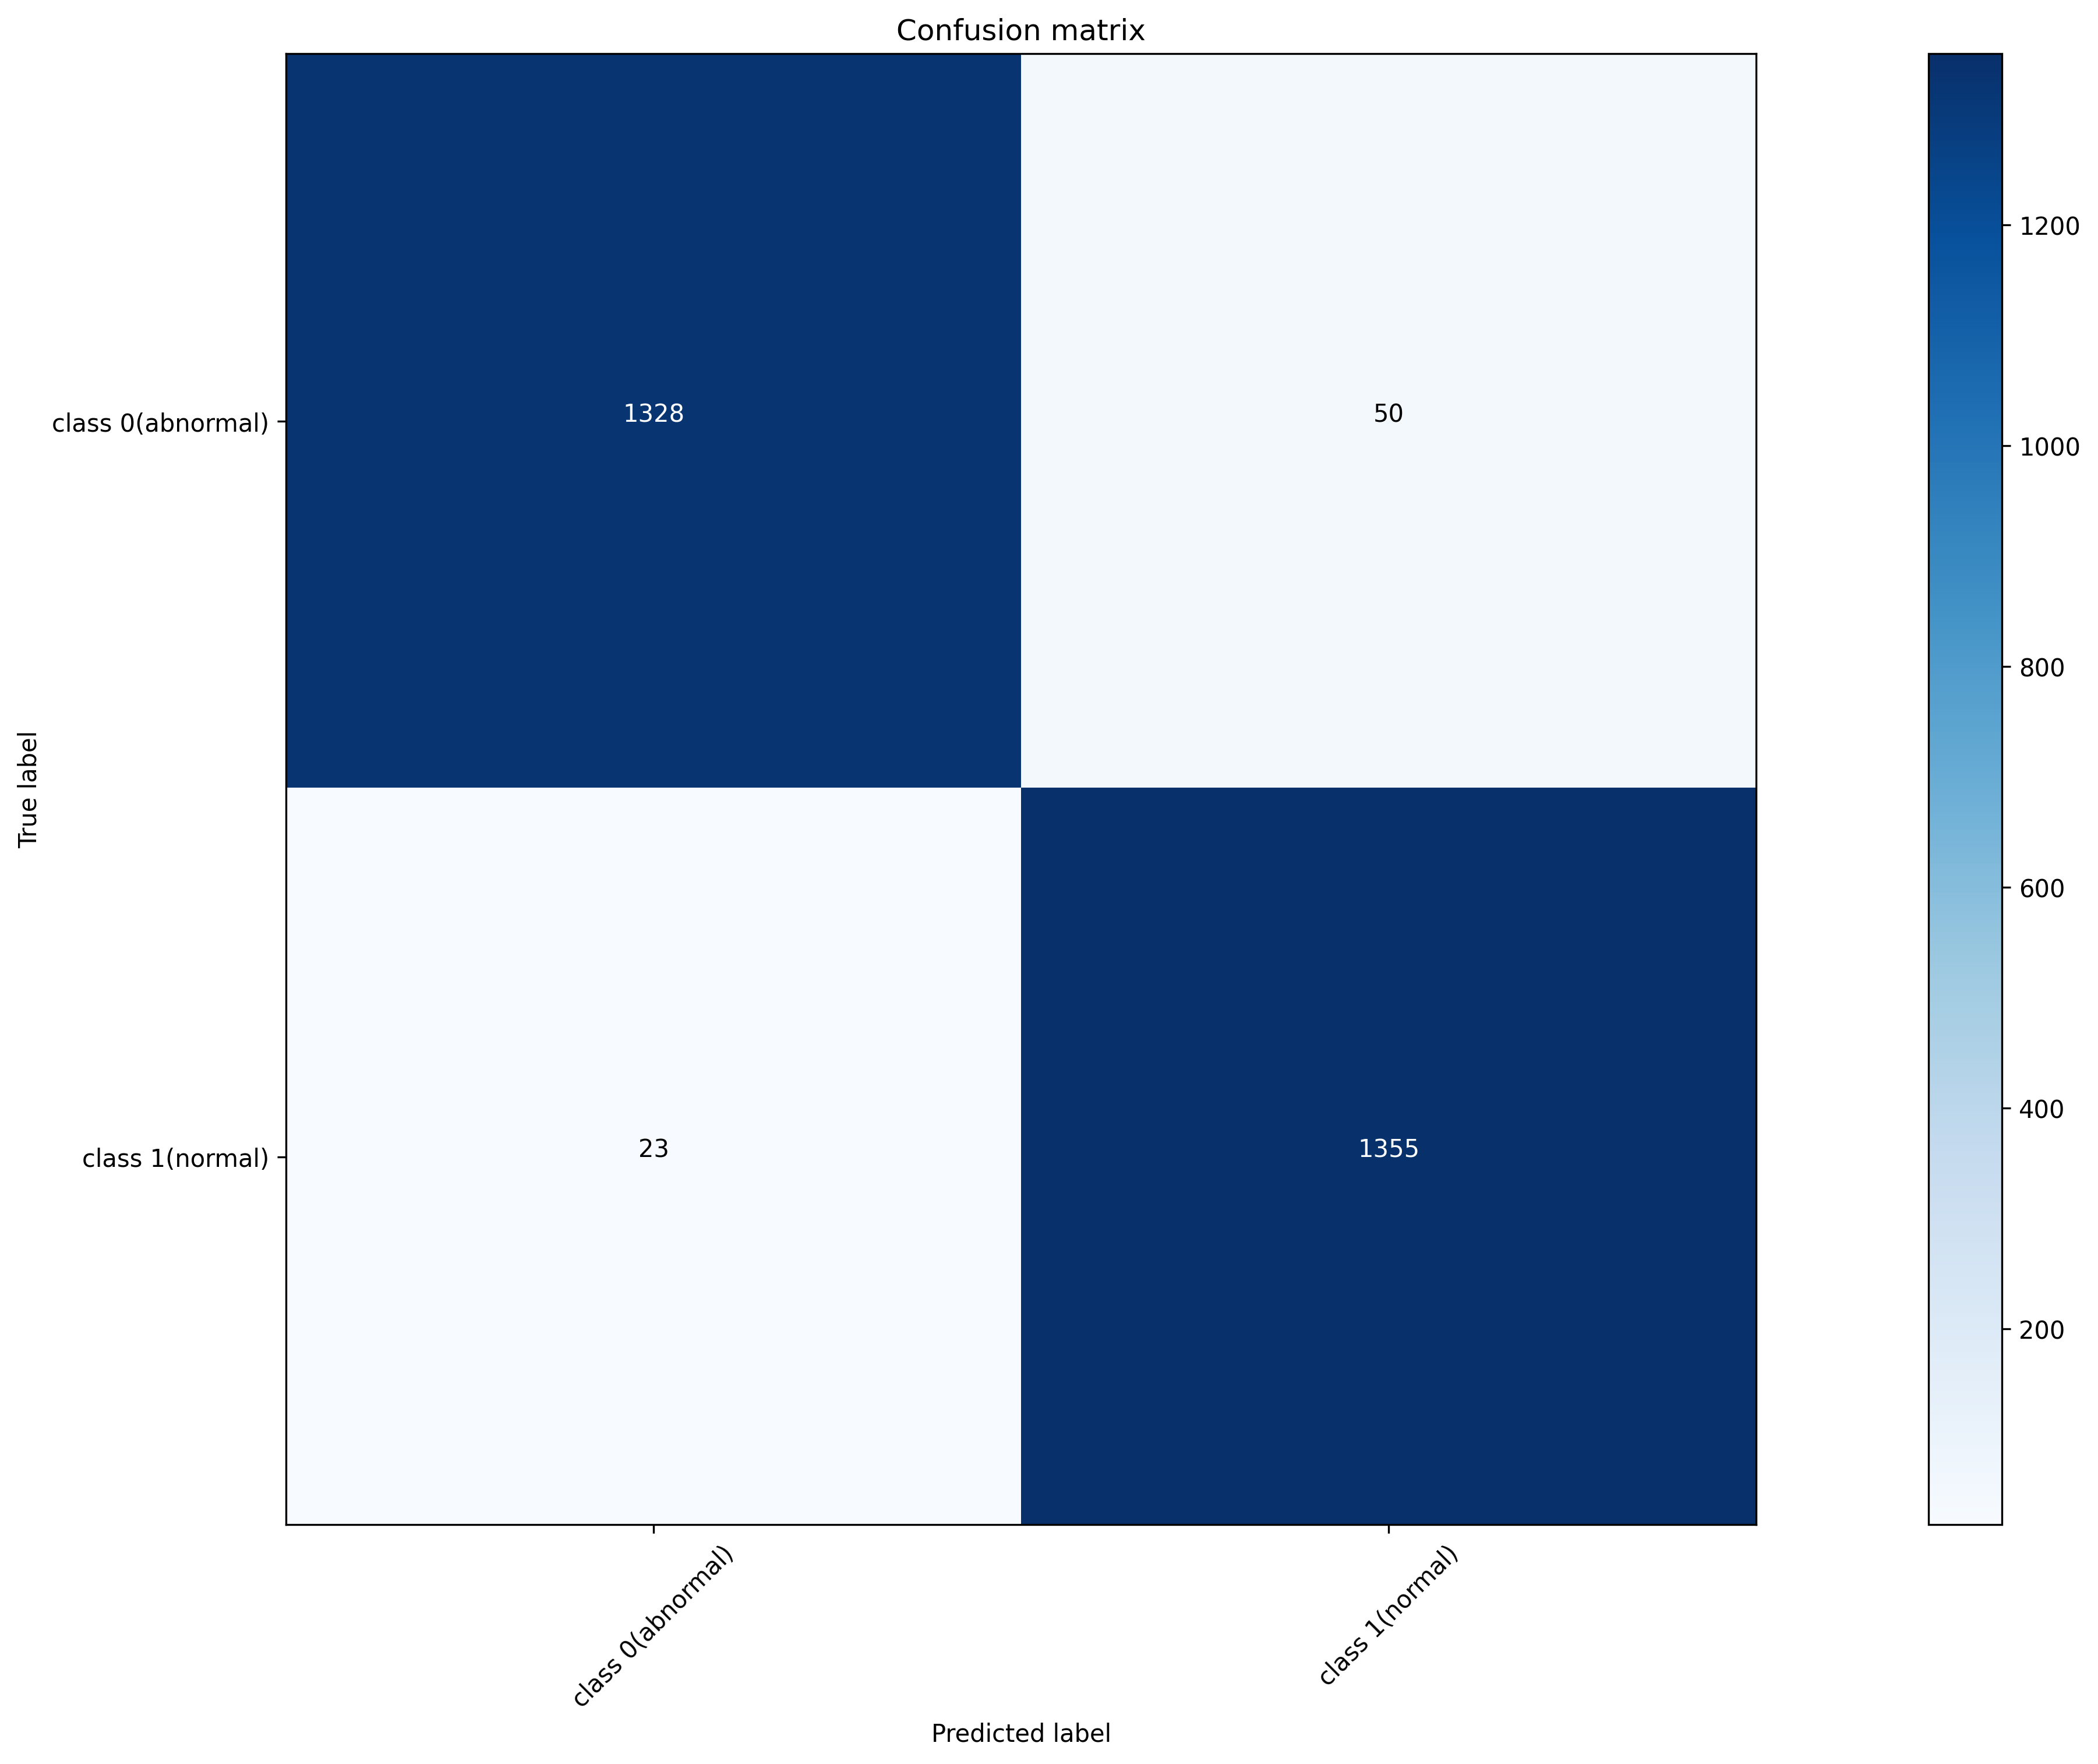

In [26]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)

plt.show()


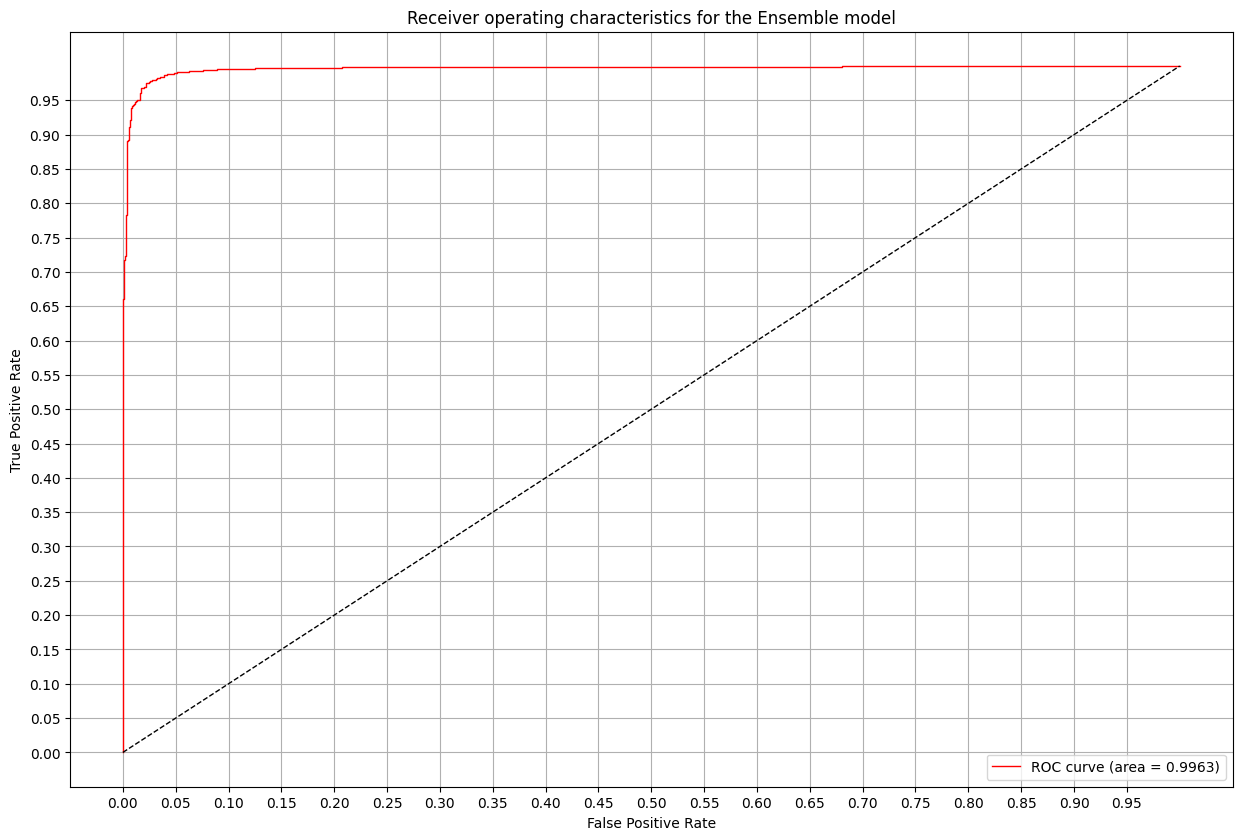

In [27]:
#%% compute the ROC-AUC values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for the Ensemble model')
plt.legend(loc="lower right")
plt.show()


In [28]:
#%% Other Possible Ensembles: 
# We can select the optimal ensemble from the collection of model combinations

pair_A = [custom_model, vgg19_custom_model]
pair_B = [custom_model, squeeze_custom_model]
pair_C = [custom_model, inceptionresnet_custom_model]
pair_D = [vgg19_custom_model, squeeze_custom_model]
pair_E = [vgg19_custom_model, inceptionresnet_custom_model]
pair_F = [squeeze_custom_model, inceptionresnet_custom_model]
pair_G = [custom_model, vgg19_custom_model, squeeze_custom_model]
pair_H = [custom_model, vgg19_custom_model, inceptionresnet_custom_model]
pair_I = [vgg19_custom_model, squeeze_custom_model, inceptionresnet_custom_model]

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_5')>]
The Ensemble Model is Saved
The accuracy of the Pair A Ensemble model is:  0.9677068214804064
The Mean Squared Error of the Pair A Ensemble model is:  0.03229317851959362
The Mean Squared Log Error of the Pair A Ensemble model is:  0.015515354948737271
                   precision    recall  f1-score   support

class 0(abnormal)     0.9785    0.9565    0.9673      1378
  class 1(normal)     0.9574    0.9790    0.9681      1378

         accuracy                         0.9677      2756
        macro avg     0.9679    0.9677    0.9677      2756
     weighted avg     0.9679    0.9677    0.9677      2756

Confusion matrix, without normalization
[[1318   60]
 [  29 1349]]


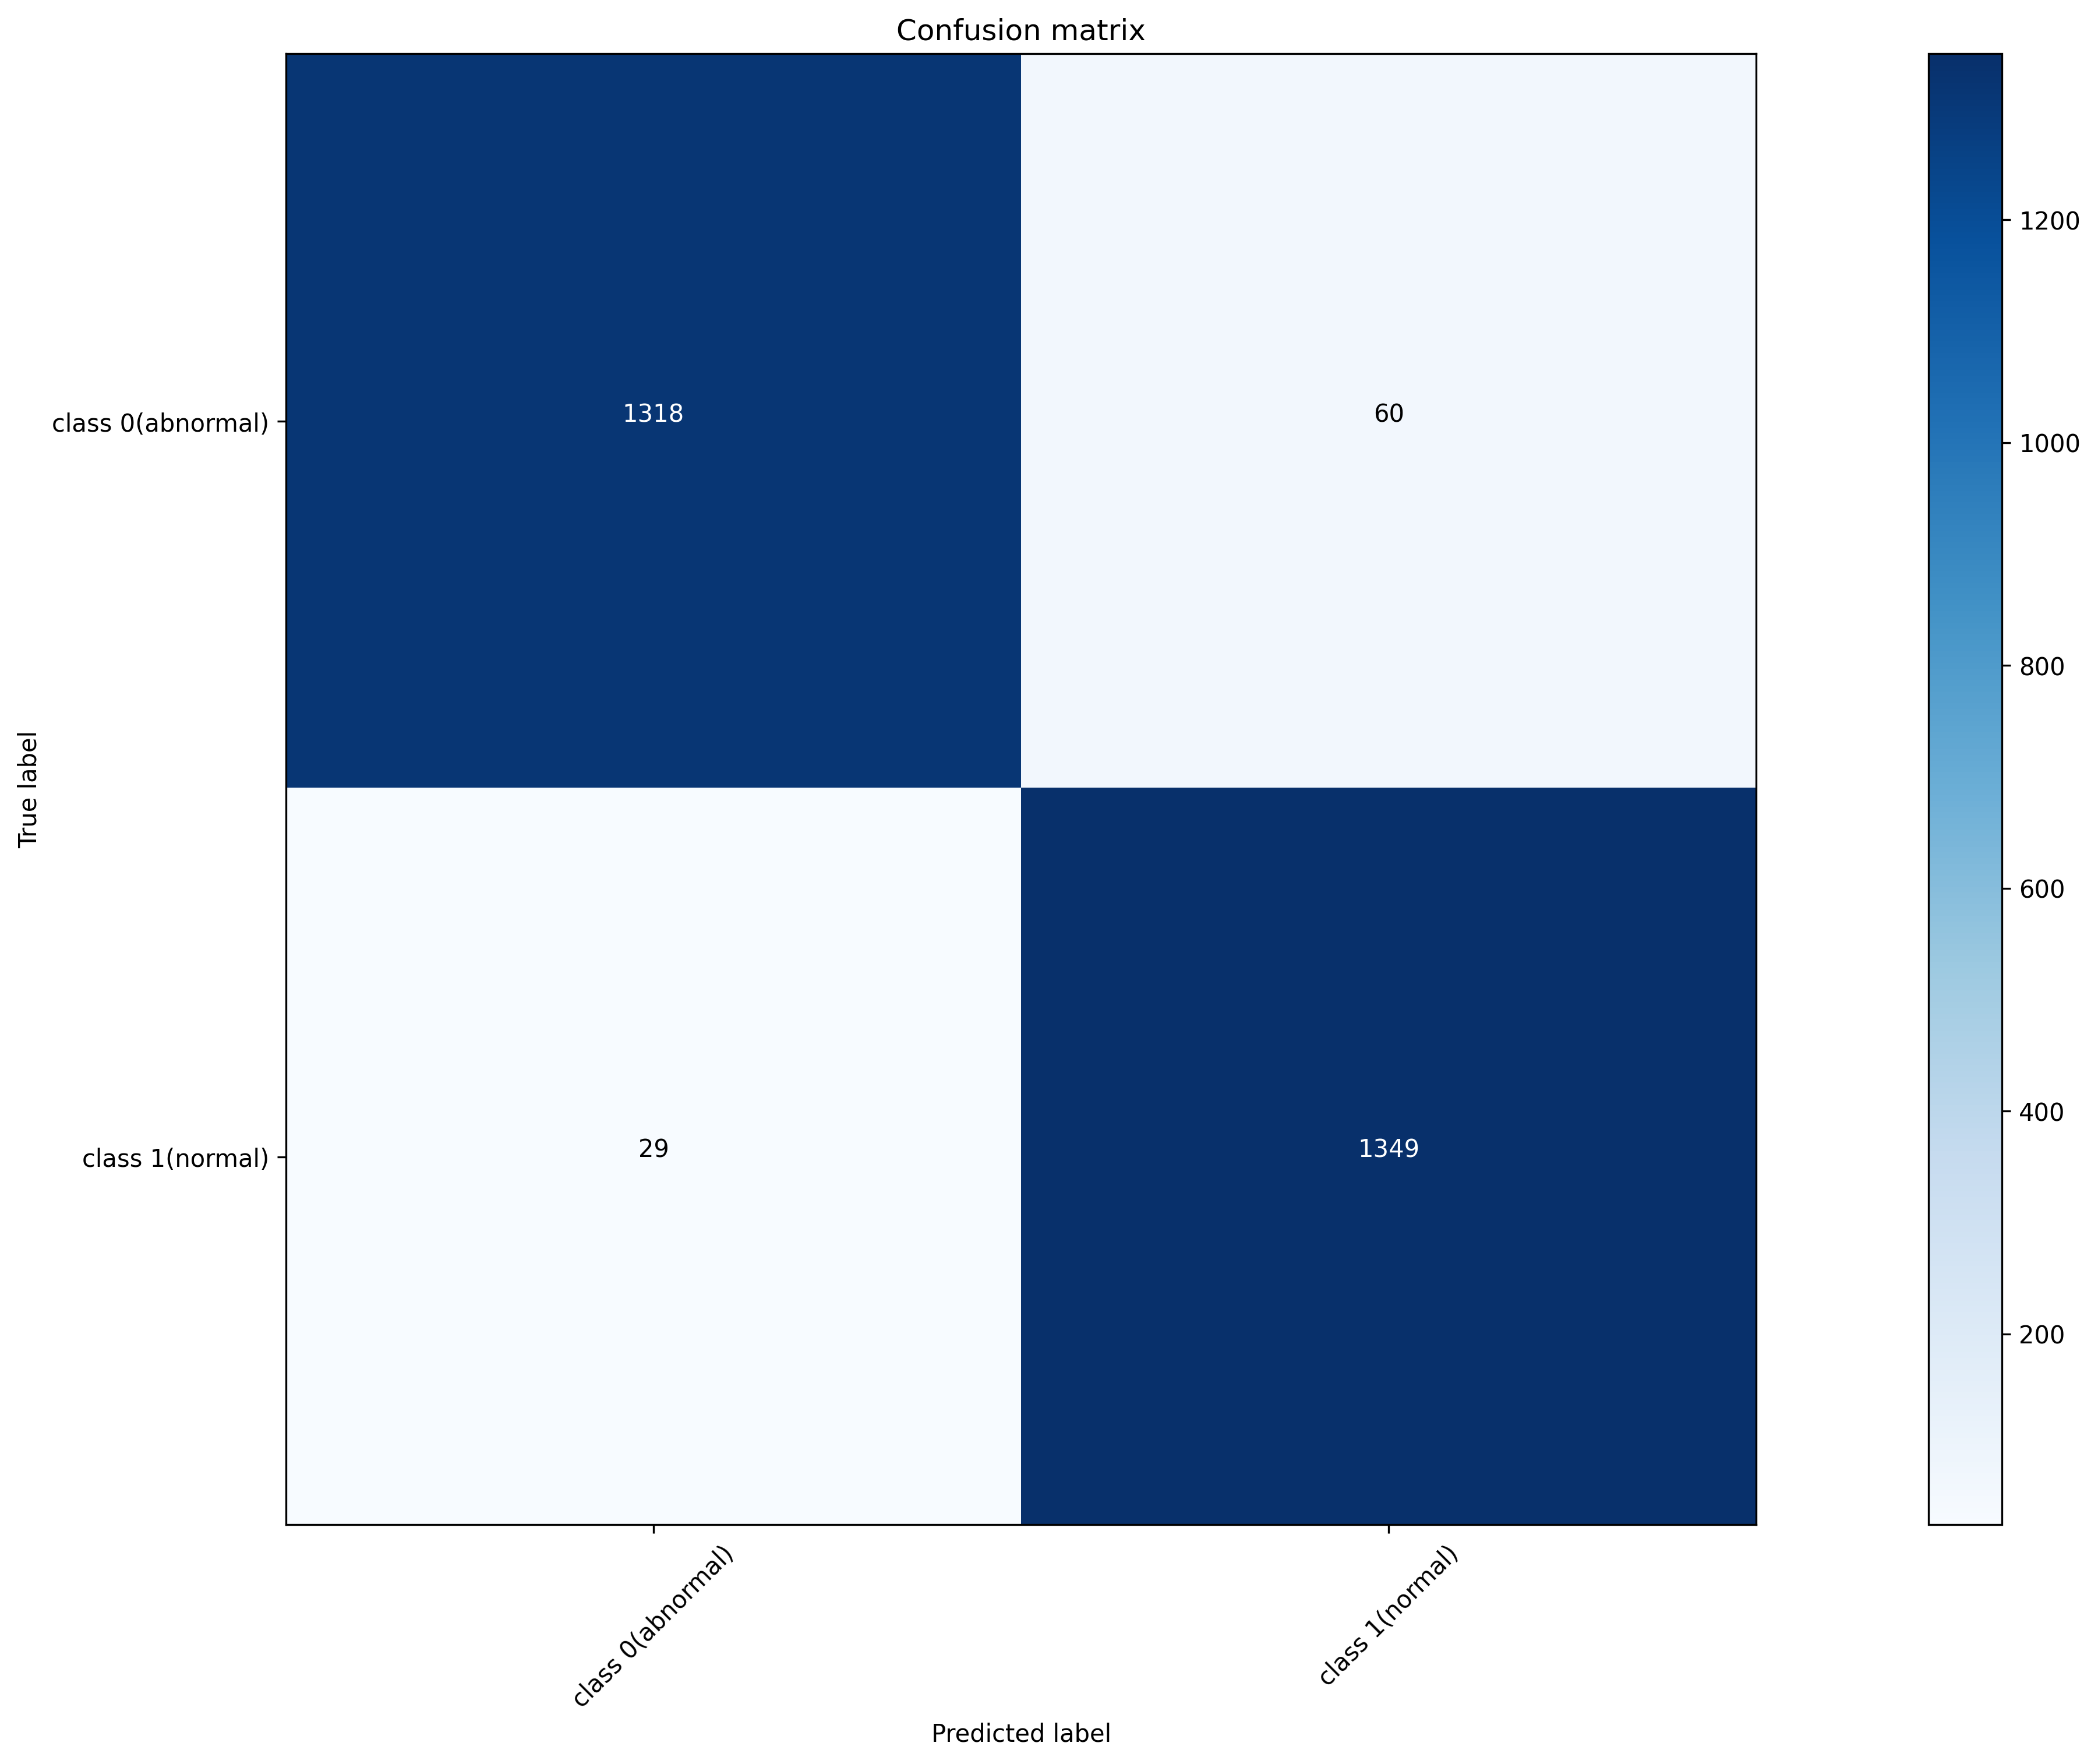

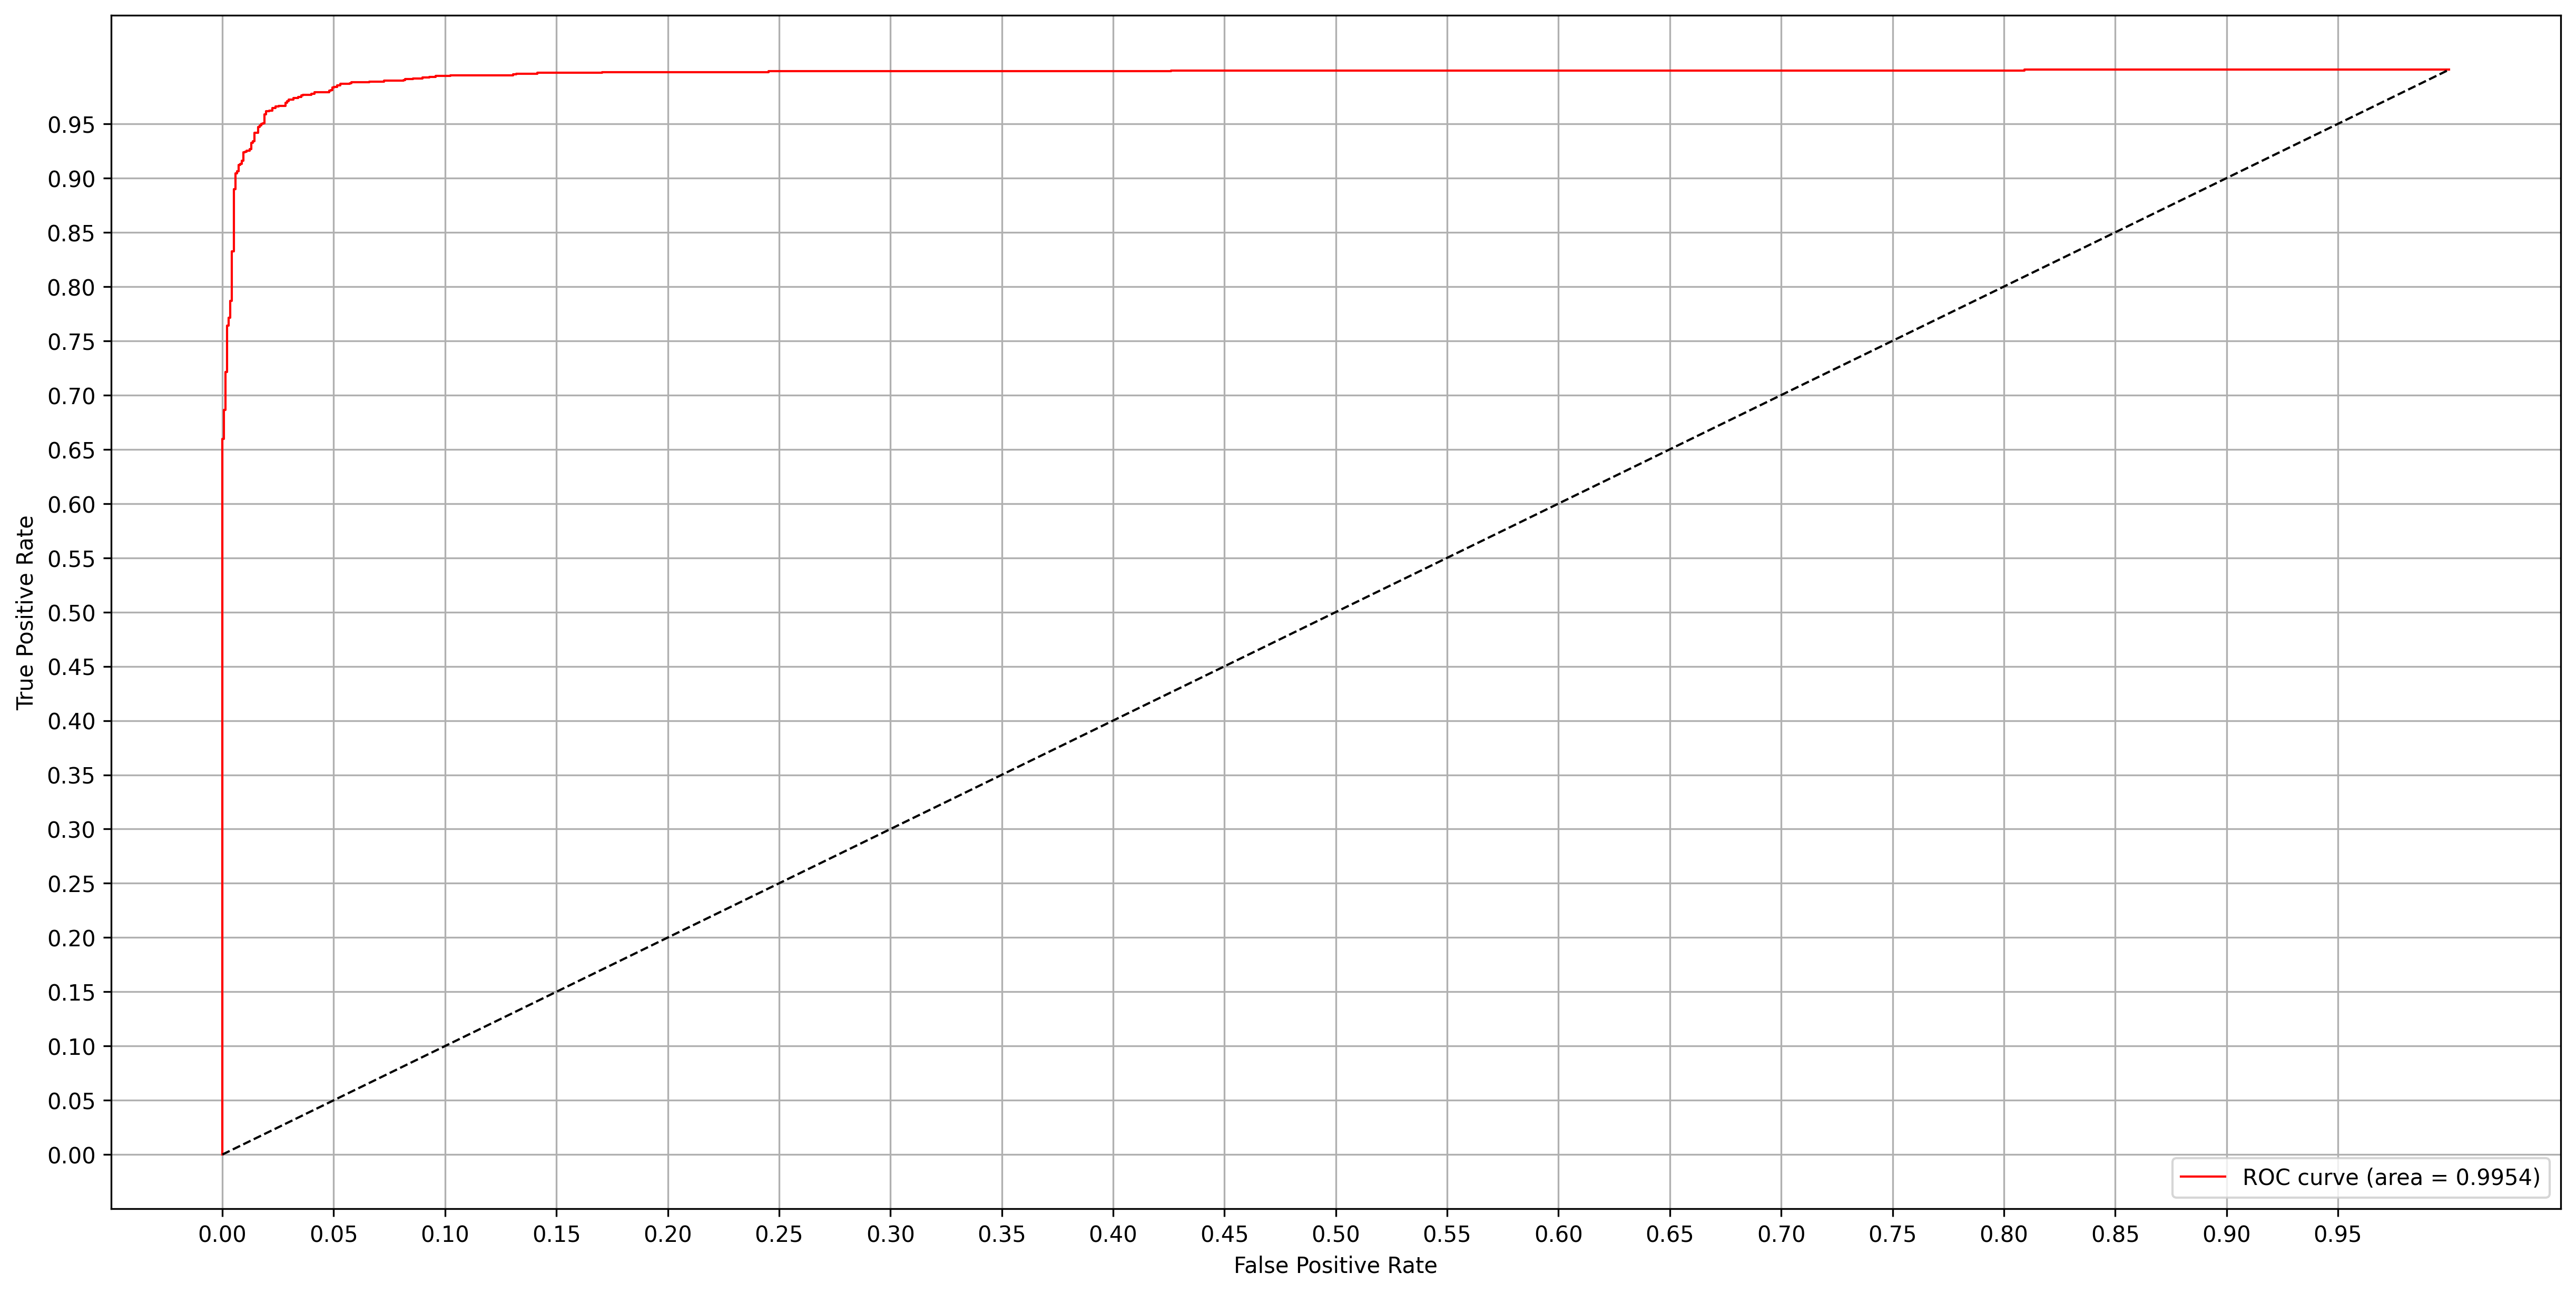

In [29]:
#%% evaluate the performance of these paired ensembles

pair_A_ensemble_model = ensemble(pair_A, model_input)
pair_A_ensemble_model.save('weights/ensemblemodel_pairA.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
A_ensem_y_pred = pair_A_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
A_ensemble_model_accuracy = accuracy_score(Y_test,A_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair A Ensemble model is: ', A_ensemble_model_accuracy)

#evaluate mean squared error
A_ensemble_model_custom_mse = mean_squared_error(Y_test,A_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair A Ensemble model is: ', A_ensemble_model_custom_mse)

#evaluate mean squared log error
A_ensemble_model_custom_msle = mean_squared_log_error(Y_test,A_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair A Ensemble model is: ', A_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)']
print(classification_report(Y_test,A_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,A_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)

plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, A_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_6')>]
The Ensemble Model is Saved
The accuracy of the Pair B Ensemble model is:  0.9684325108853411
The Mean Squared Error of the Pair B Ensemble model is:  0.031567489114658925
The Mean Squared Log Error of the Pair B Ensemble model is:  0.015166695286967895
                   precision    recall  f1-score   support

class 0(abnormal)     0.9799    0.9565    0.9680      1378
  class 1(normal)     0.9575    0.9804    0.9688      1378

         accuracy                         0.9684      2756
        macro avg     0.9687    0.9684    0.9684      2756
     weighted avg     0.9687    0.9684    0.9684      2756

Confusion matrix, without normalization
[[1318   60]
 [  27 1351]]


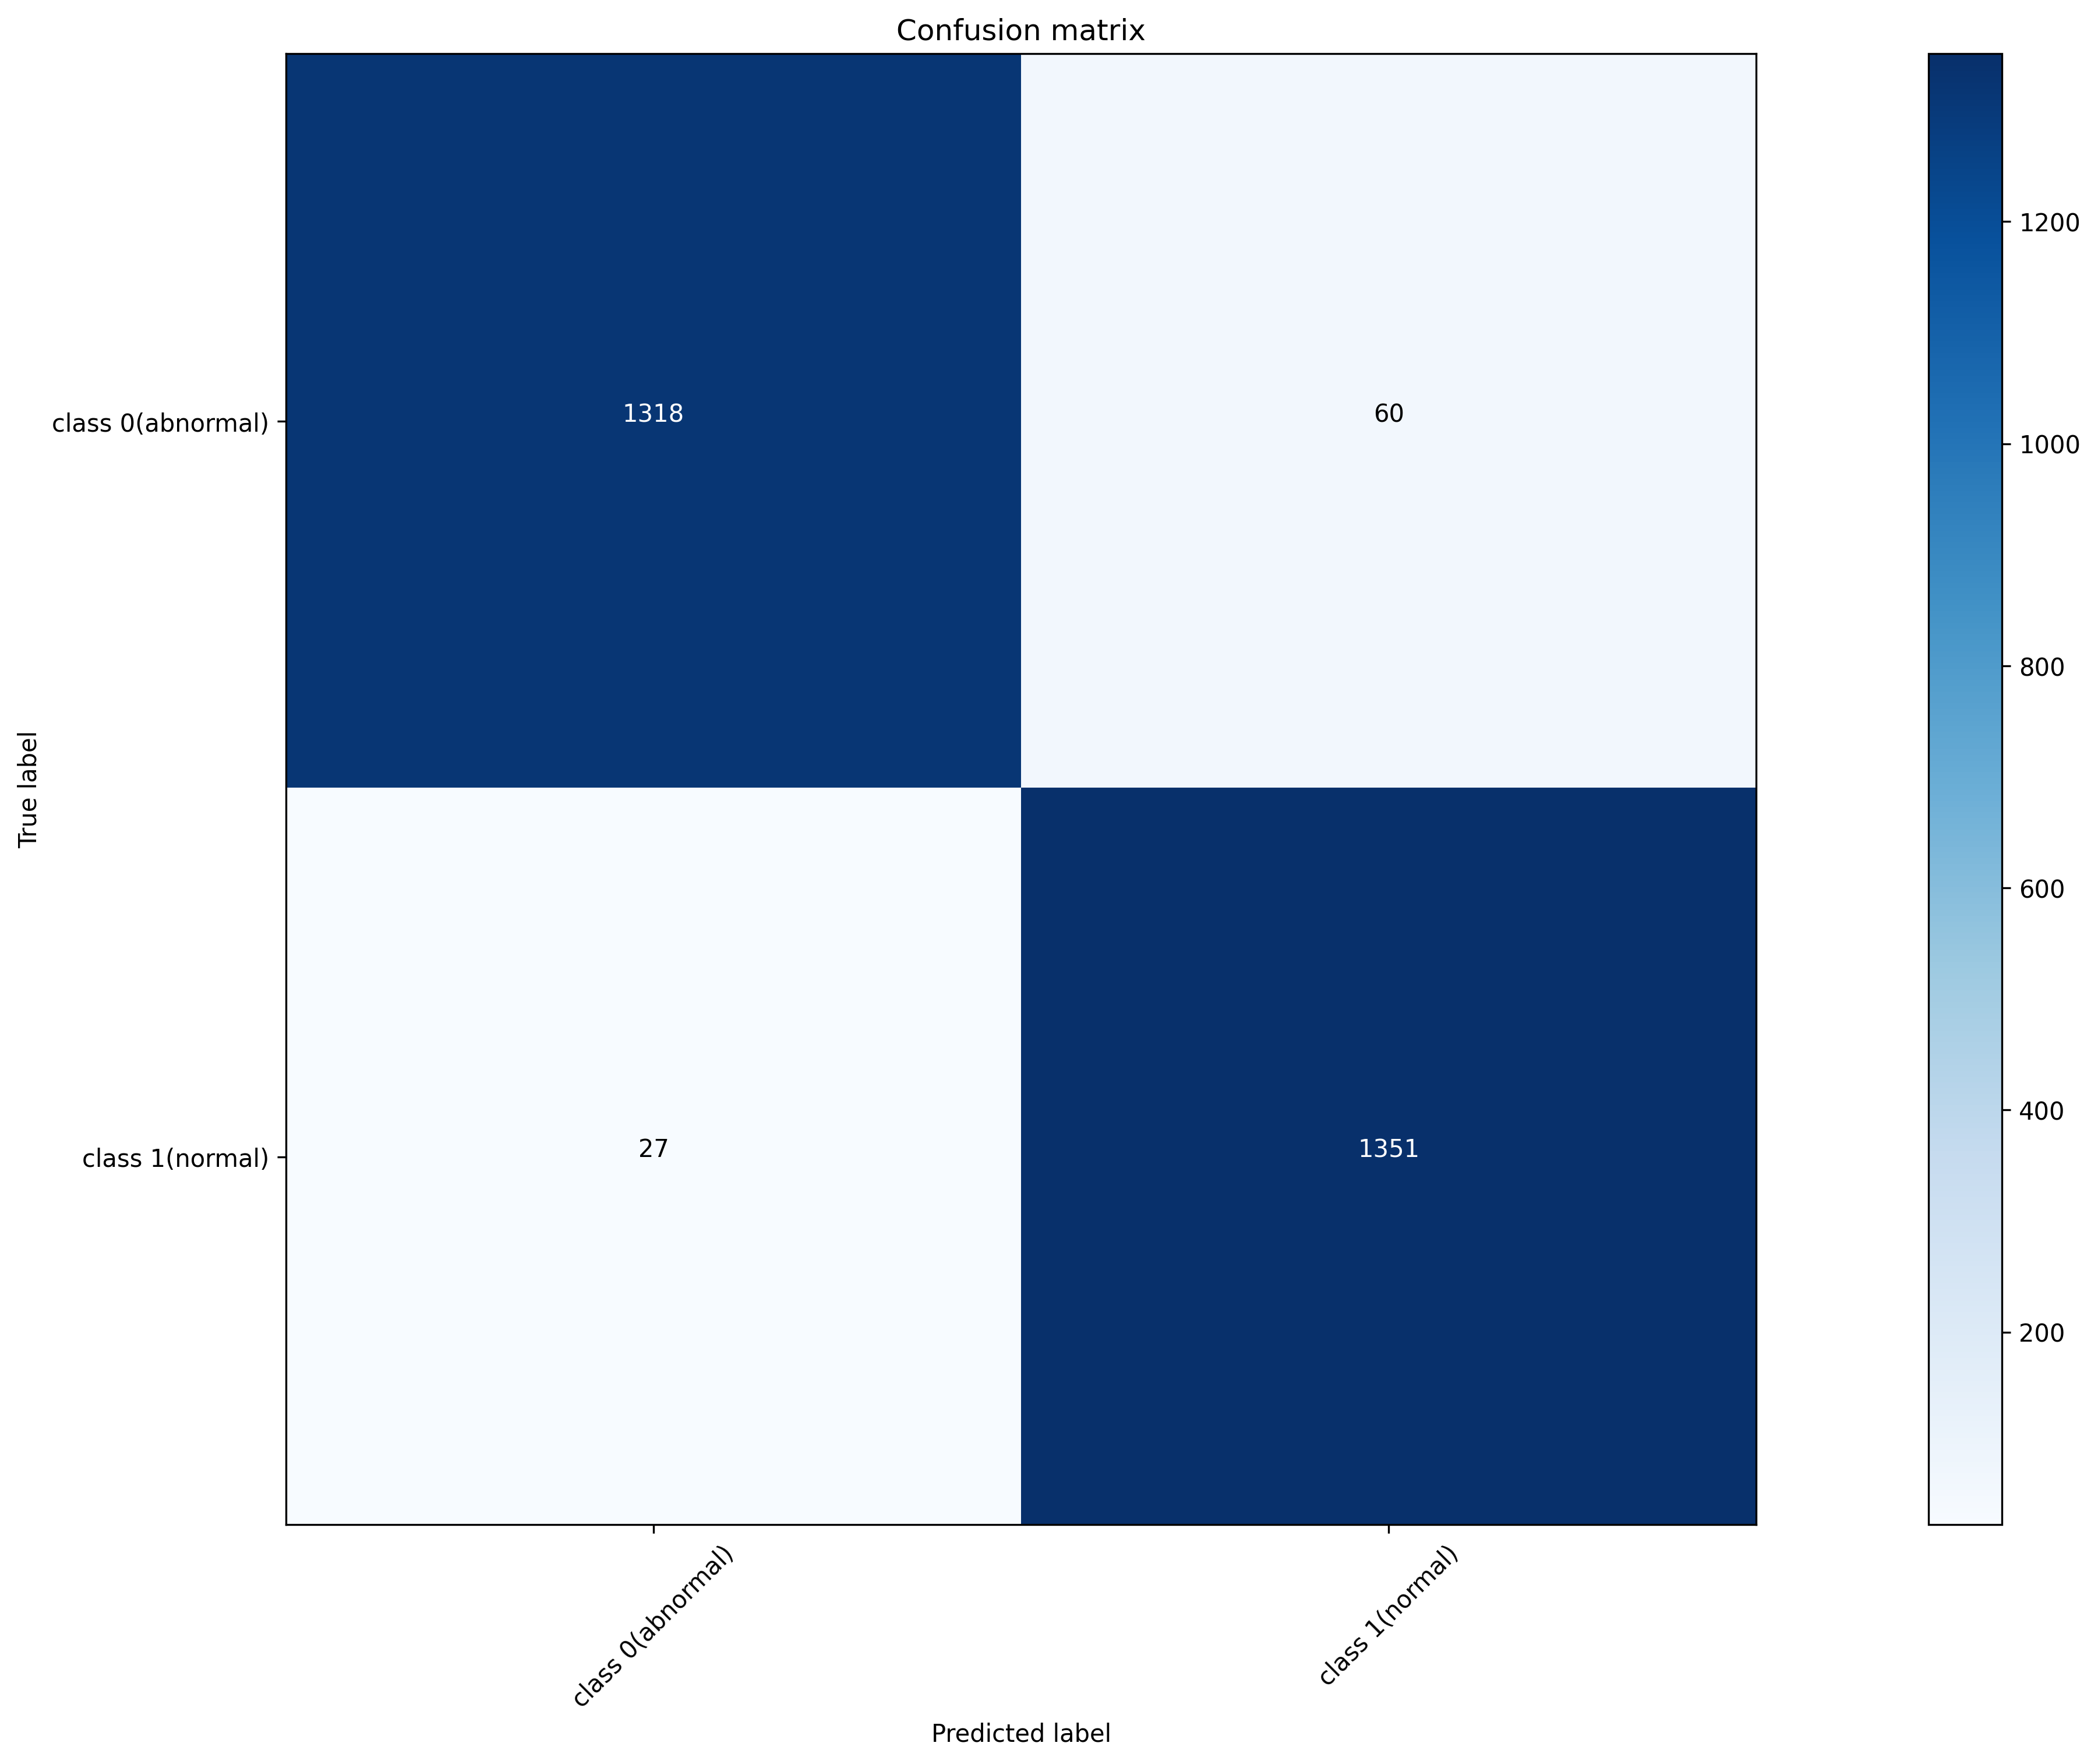

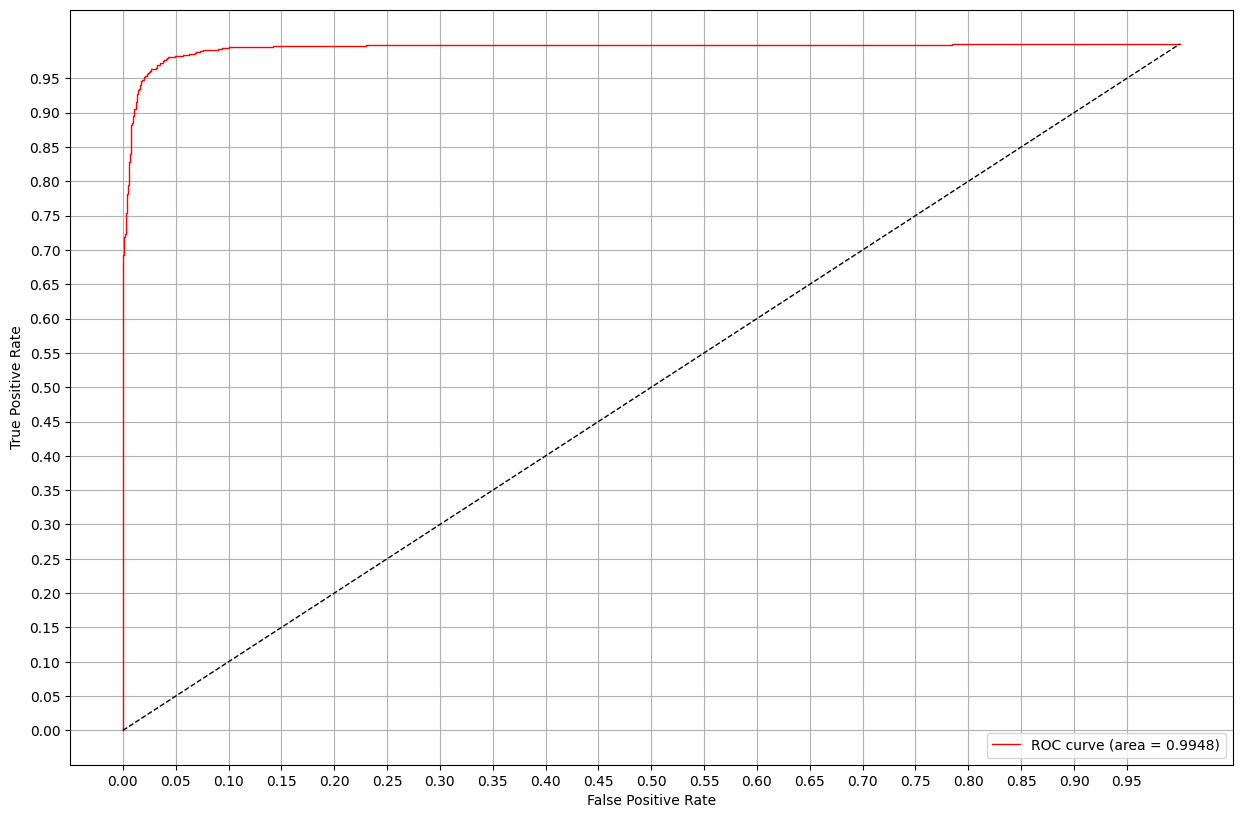

In [30]:
#%% Pair B 

pair_B_ensemble_model = ensemble(pair_B, model_input)
pair_B_ensemble_model.save('weights/ensemblemodel_pairB.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
B_ensem_y_pred = pair_B_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
B_ensemble_model_accuracy = accuracy_score(Y_test,B_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair B Ensemble model is: ', B_ensemble_model_accuracy)

#evaluate mean squared error
B_ensemble_model_custom_mse = mean_squared_error(Y_test,B_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair B Ensemble model is: ', B_ensemble_model_custom_mse)

#evaluate mean squared log error
B_ensemble_model_custom_msle = mean_squared_log_error(Y_test,B_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair B Ensemble model is: ', B_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)']
print(classification_report(Y_test,B_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,B_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)

plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, B_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_7')>]
The Ensemble Model is Saved
The accuracy of the Pair C Ensemble model is:  0.9749637155297532
The Mean Squared Error of the Pair C Ensemble model is:  0.025036284470246733
The Mean Squared Log Error of the Pair C Ensemble model is:  0.012028758331043502
                   precision    recall  f1-score   support

class 0(abnormal)     0.9866    0.9630    0.9747      1378
  class 1(normal)     0.9639    0.9869    0.9753      1378

         accuracy                         0.9750      2756
        macro avg     0.9752    0.9750    0.9750      2756
     weighted avg     0.9752    0.9750    0.9750      2756

Confusion matrix, without normalization
[[1327   51]
 [  18 1360]]


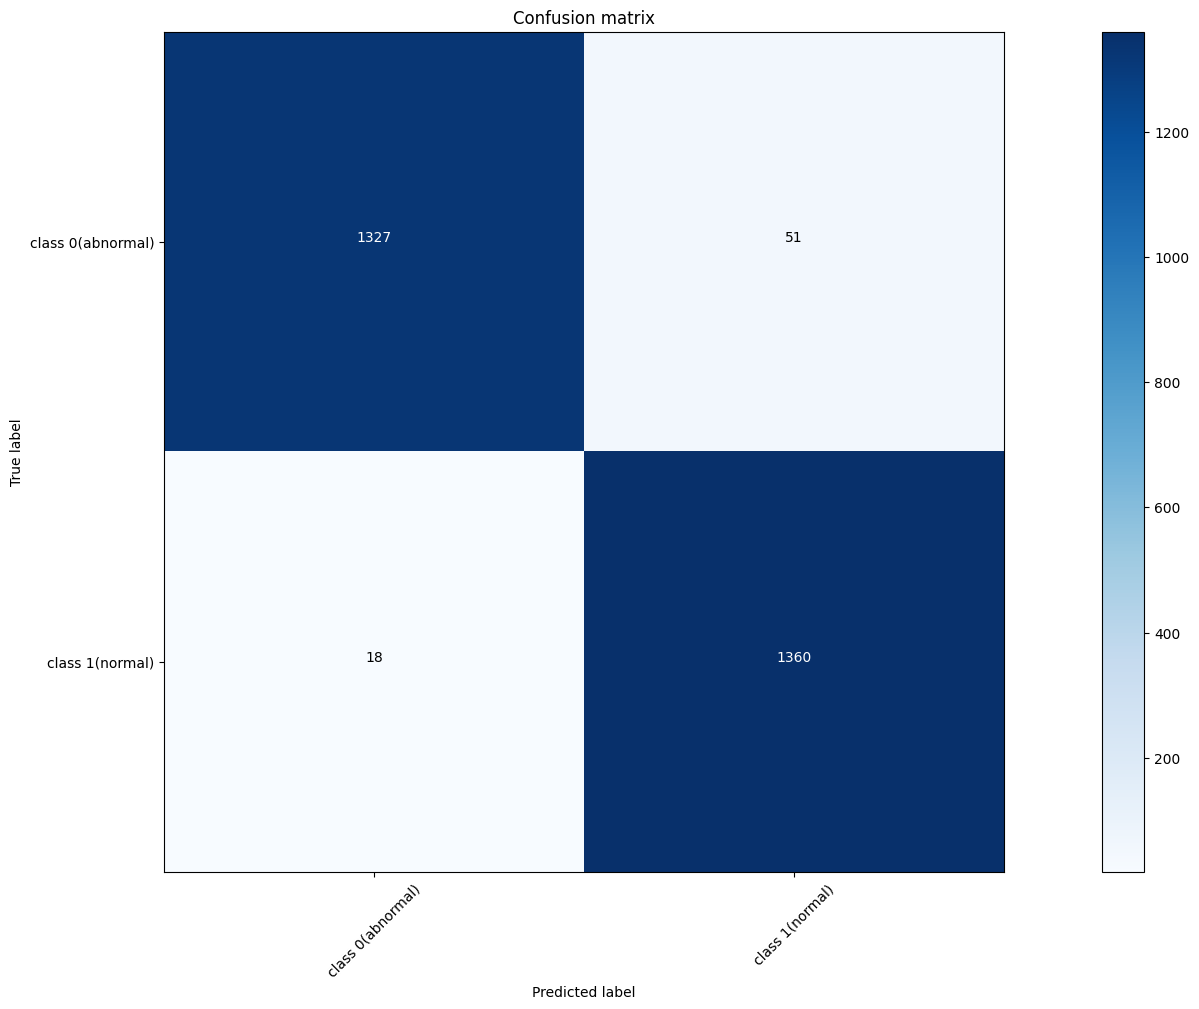

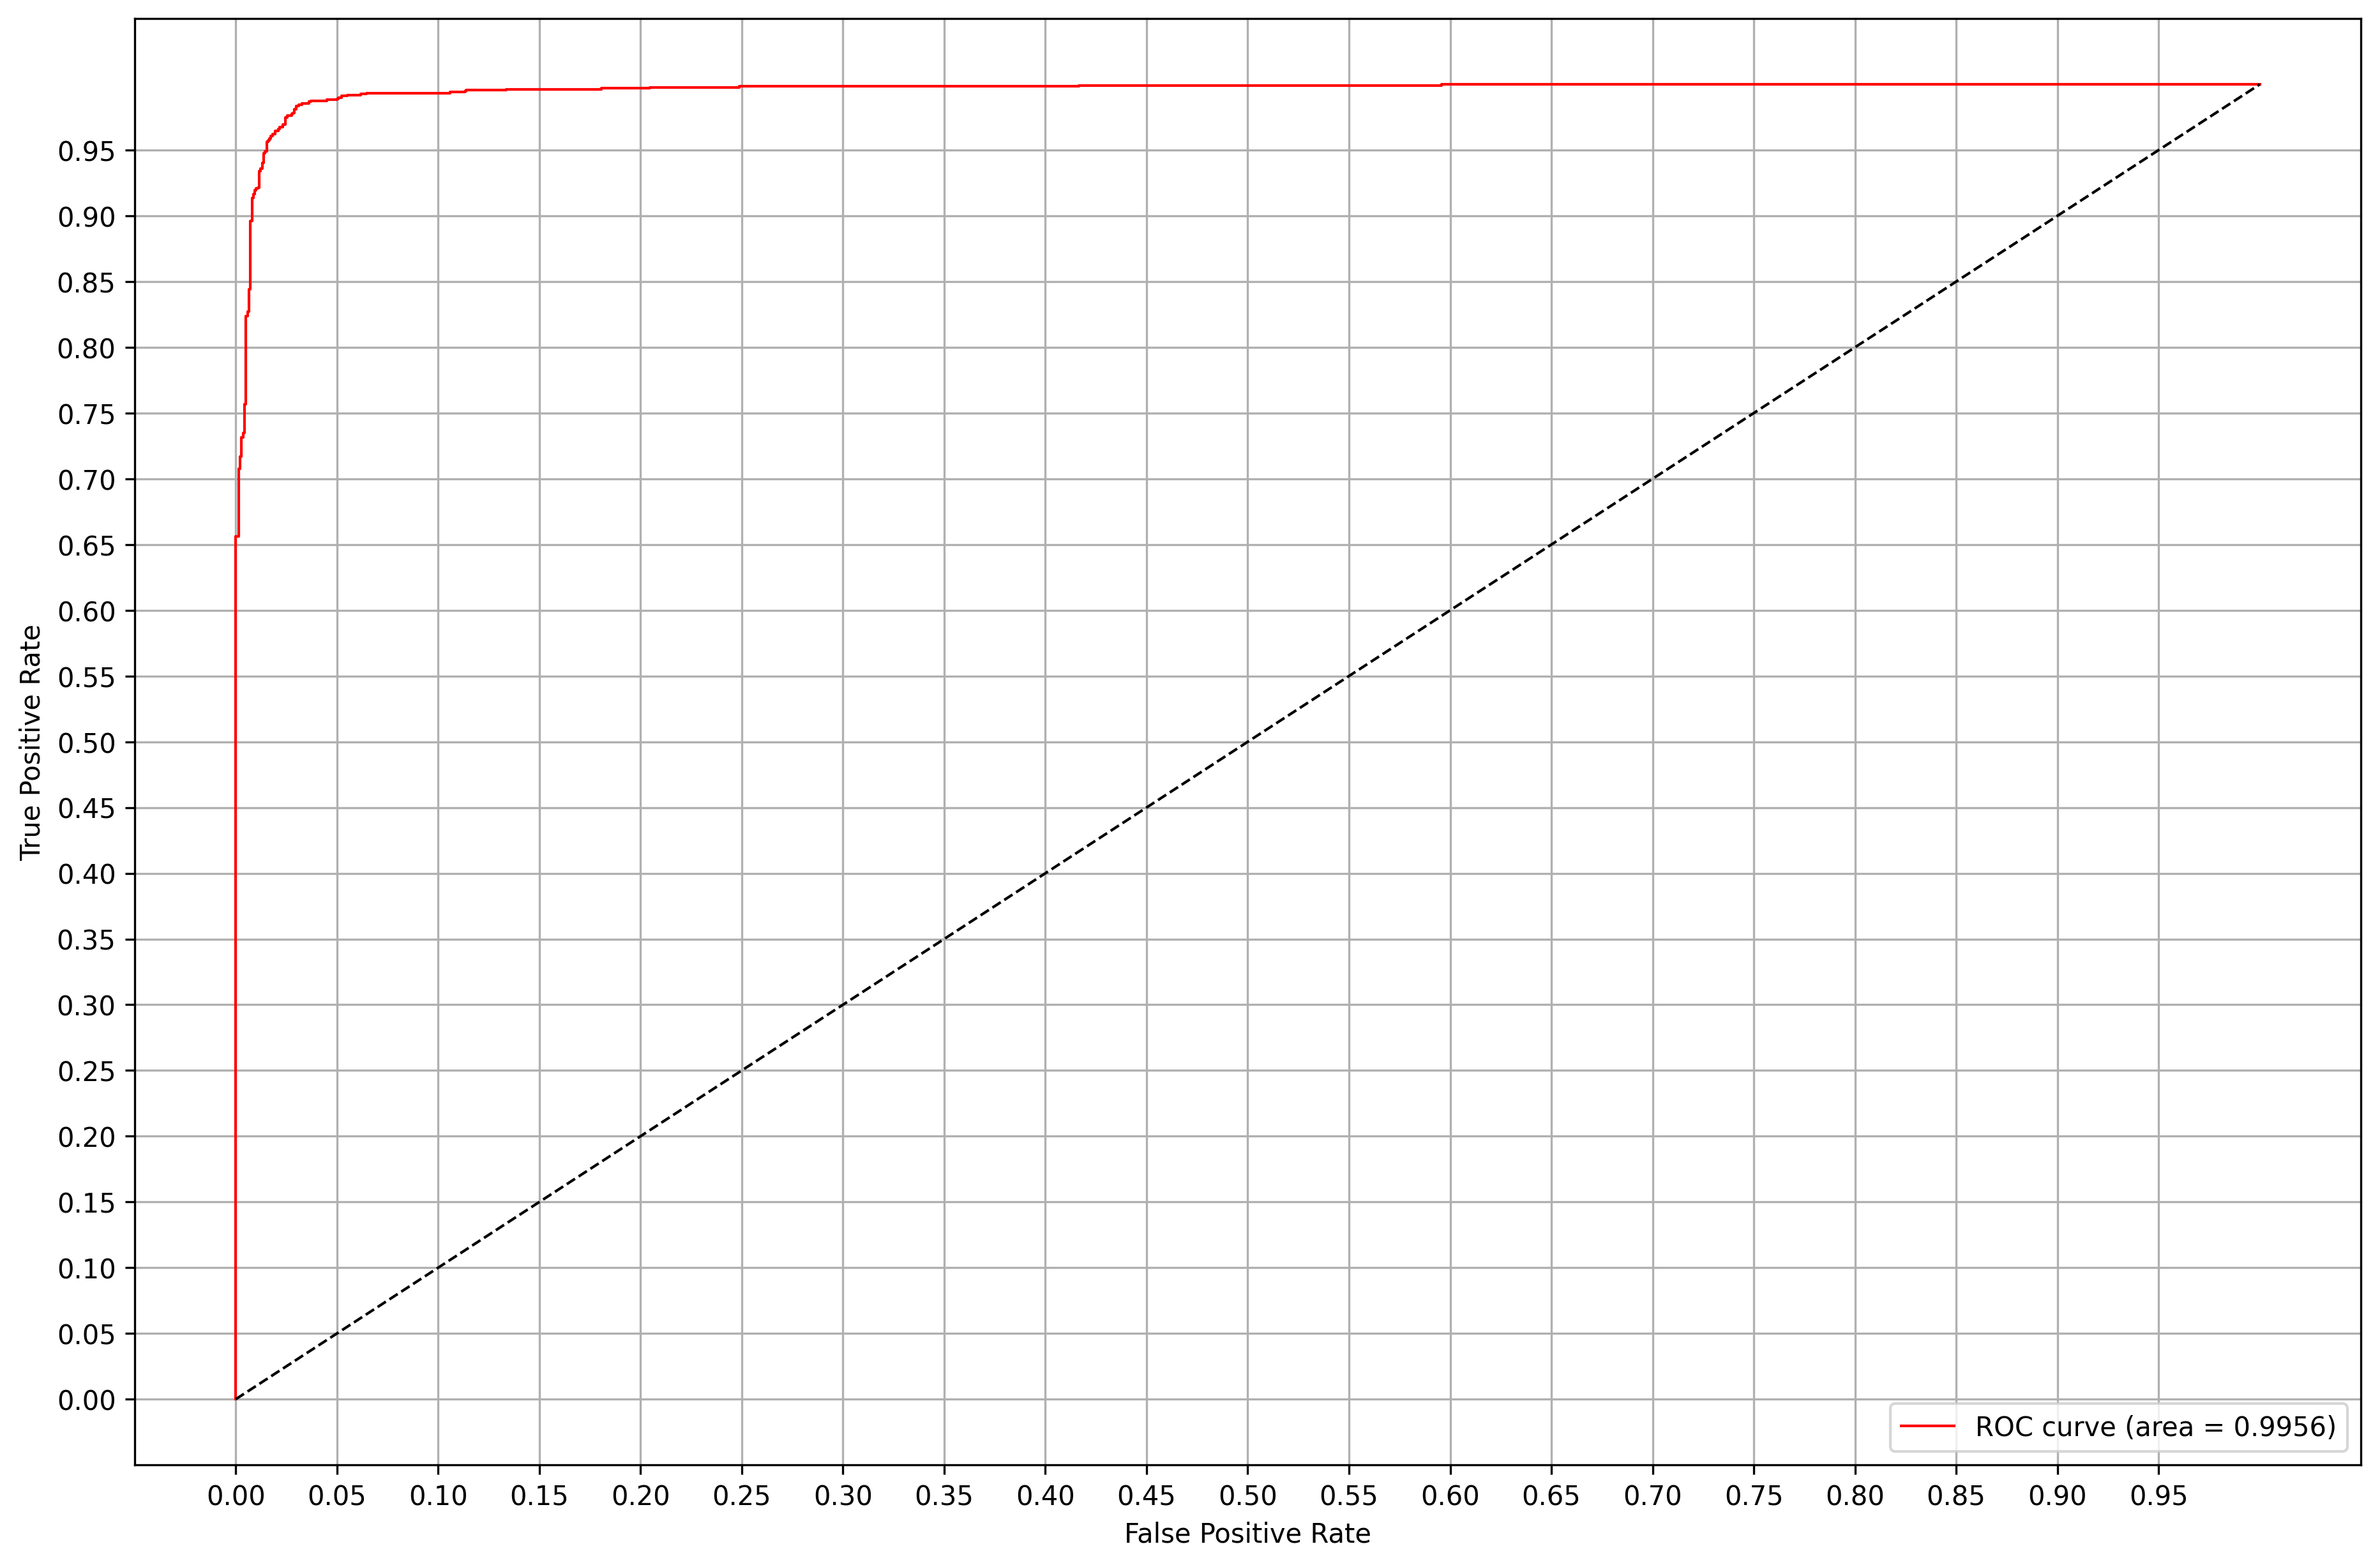

In [31]:
#%% Pair C

pair_C_ensemble_model = ensemble(pair_C, model_input)
pair_C_ensemble_model.save('weights/ensemblemodel_pairC.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
C_ensem_y_pred = pair_C_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
C_ensemble_model_accuracy = accuracy_score(Y_test,C_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair C Ensemble model is: ', C_ensemble_model_accuracy)

#evaluate mean squared error
C_ensemble_model_custom_mse = mean_squared_error(Y_test,C_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair C Ensemble model is: ', C_ensemble_model_custom_mse)

#evaluate mean squared log error
C_ensemble_model_custom_msle = mean_squared_log_error(Y_test,C_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair C Ensemble model is: ', C_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,C_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,C_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=100)
plot_confusion_matrix(cnf_matrix, classes=target_names)

plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, C_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_5')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_6')>]
The Ensemble Model is Saved
The accuracy of the Pair D_ Ensemble model is:  0.9738751814223512
The Mean Squared Error of the Pair D_ Ensemble model is:  0.026124818577648767
The Mean Squared Log Error of the Pair D_ Ensemble model is:  0.012551747823697569
                   precision    recall  f1-score   support

class 0(abnormal)     0.9816    0.9659    0.9737      1378
  class 1(normal)     0.9664    0.9819    0.9741      1378

         accuracy                         0.9739      2756
        macro avg     0.9740    0.9739    0.9739      2756
     weighted avg     0.9740    0.9739    0.9739      2756

Confusion matrix, without normalization
[[1331   47]
 [  25 1353]]


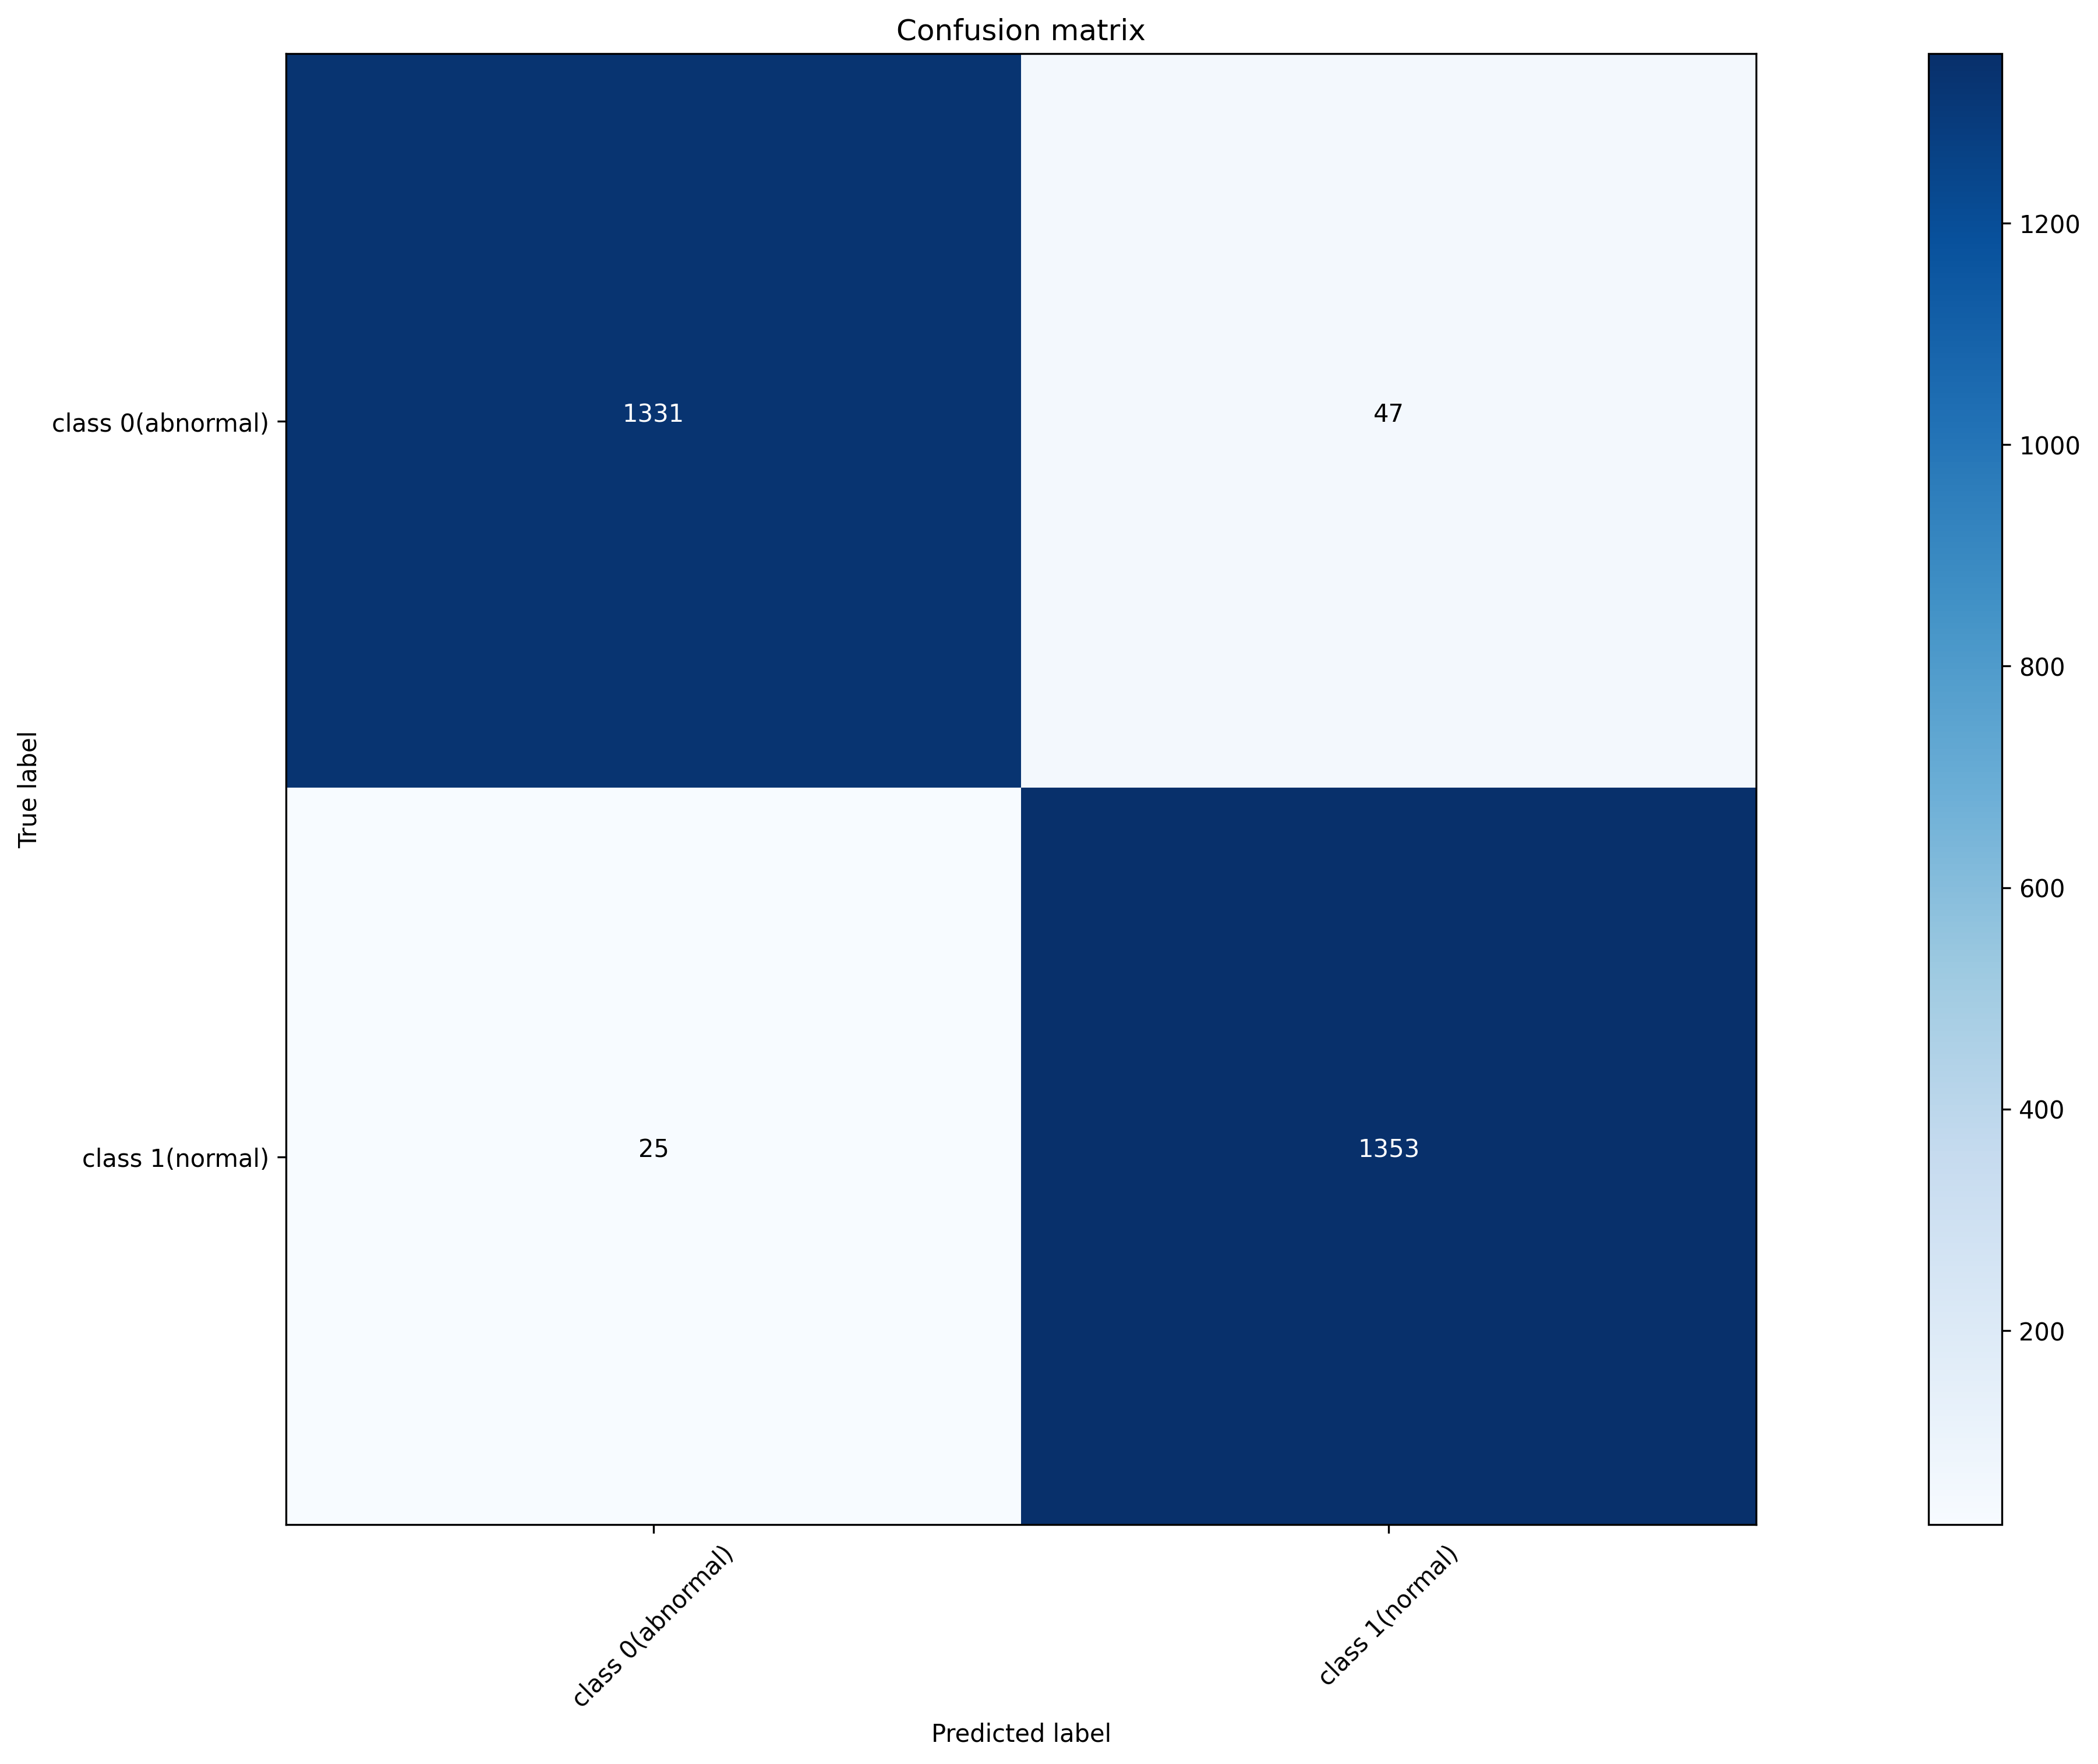

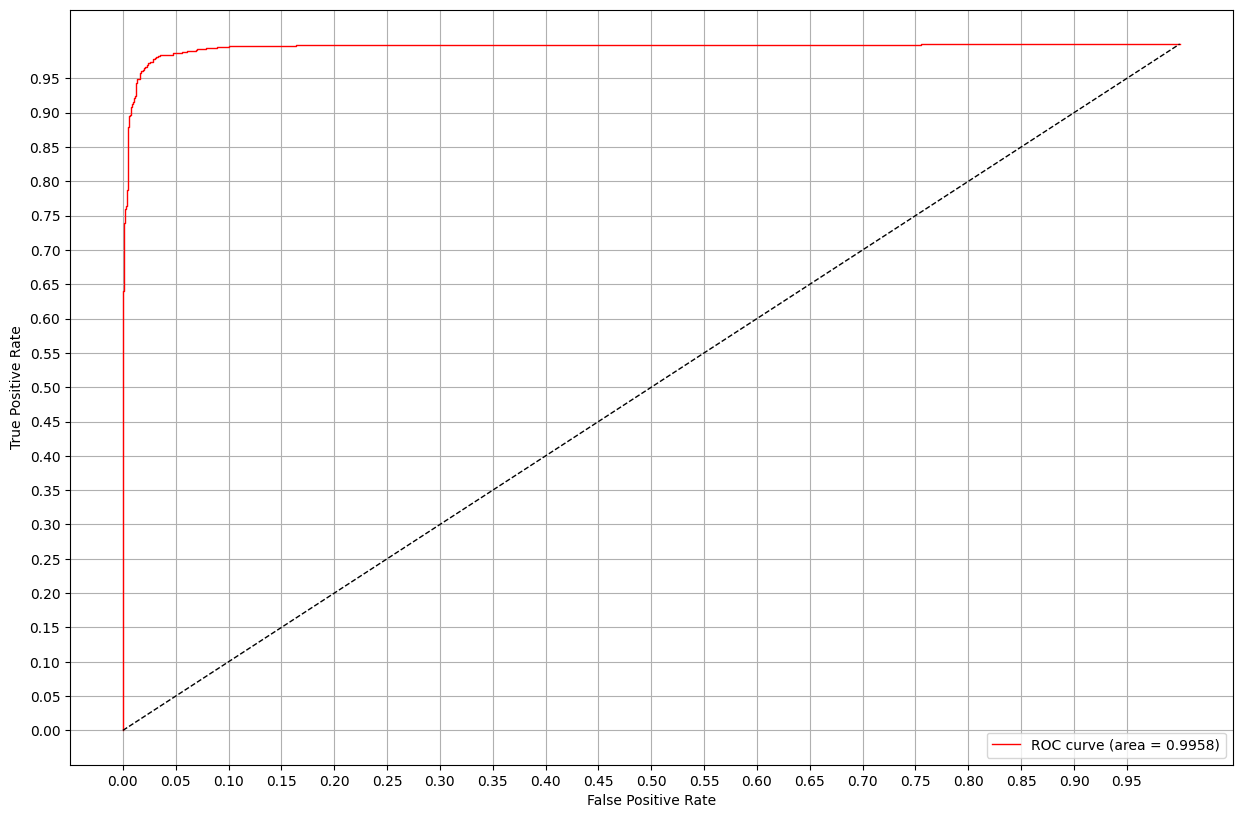

In [54]:
#%% Pair D

pair_D_ensemble_model = ensemble(pair_D, model_input)
pair_D_ensemble_model.save('weights/ensemblemodel_pairD.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
D_ensem_y_pred = pair_D_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
D_ensemble_model_accuracy = accuracy_score(Y_test,D_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair D_ Ensemble model is: ', D_ensemble_model_accuracy)

#evaluate mean squared error
D_ensemble_model_custom_mse = mean_squared_error(Y_test,D_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair D_ Ensemble model is: ', D_ensemble_model_custom_mse)

#evaluate mean squared log error
D_ensemble_model_custom_msle = mean_squared_log_error(Y_test,D_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair D_ Ensemble model is: ', D_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,D_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,D_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, D_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


In [55]:
D_ensem_y_pred

array([[9.9763e-01, 2.3735e-03],
       [9.9995e-01, 4.9466e-05],
       [9.5790e-01, 4.2096e-02],
       ...,
       [1.0477e-03, 9.9895e-01],
       [5.8683e-02, 9.4132e-01],
       [8.7517e-04, 9.9912e-01]], dtype=float32)

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_5')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_7')>]
The Ensemble Model is Saved
The accuracy of the Pair E_ Ensemble model is:  0.9793178519593614
The Mean Squared Error of the Pair E Ensemble model is:  0.020682148040638608
The Mean Squared Log Error of the Pair E Ensemble model is:  0.009936800360427241
                   precision    recall  f1-score   support

class 0(abnormal)     0.9867    0.9717    0.9792      1378
  class 1(normal)     0.9721    0.9869    0.9795      1378

         accuracy                         0.9793      2756
        macro avg     0.9794    0.9793    0.9793      2756
     weighted avg     0.9794    0.9793    0.9793      2756

Confusion matrix, without normalization
[[1339   39]
 [  18 1360]]


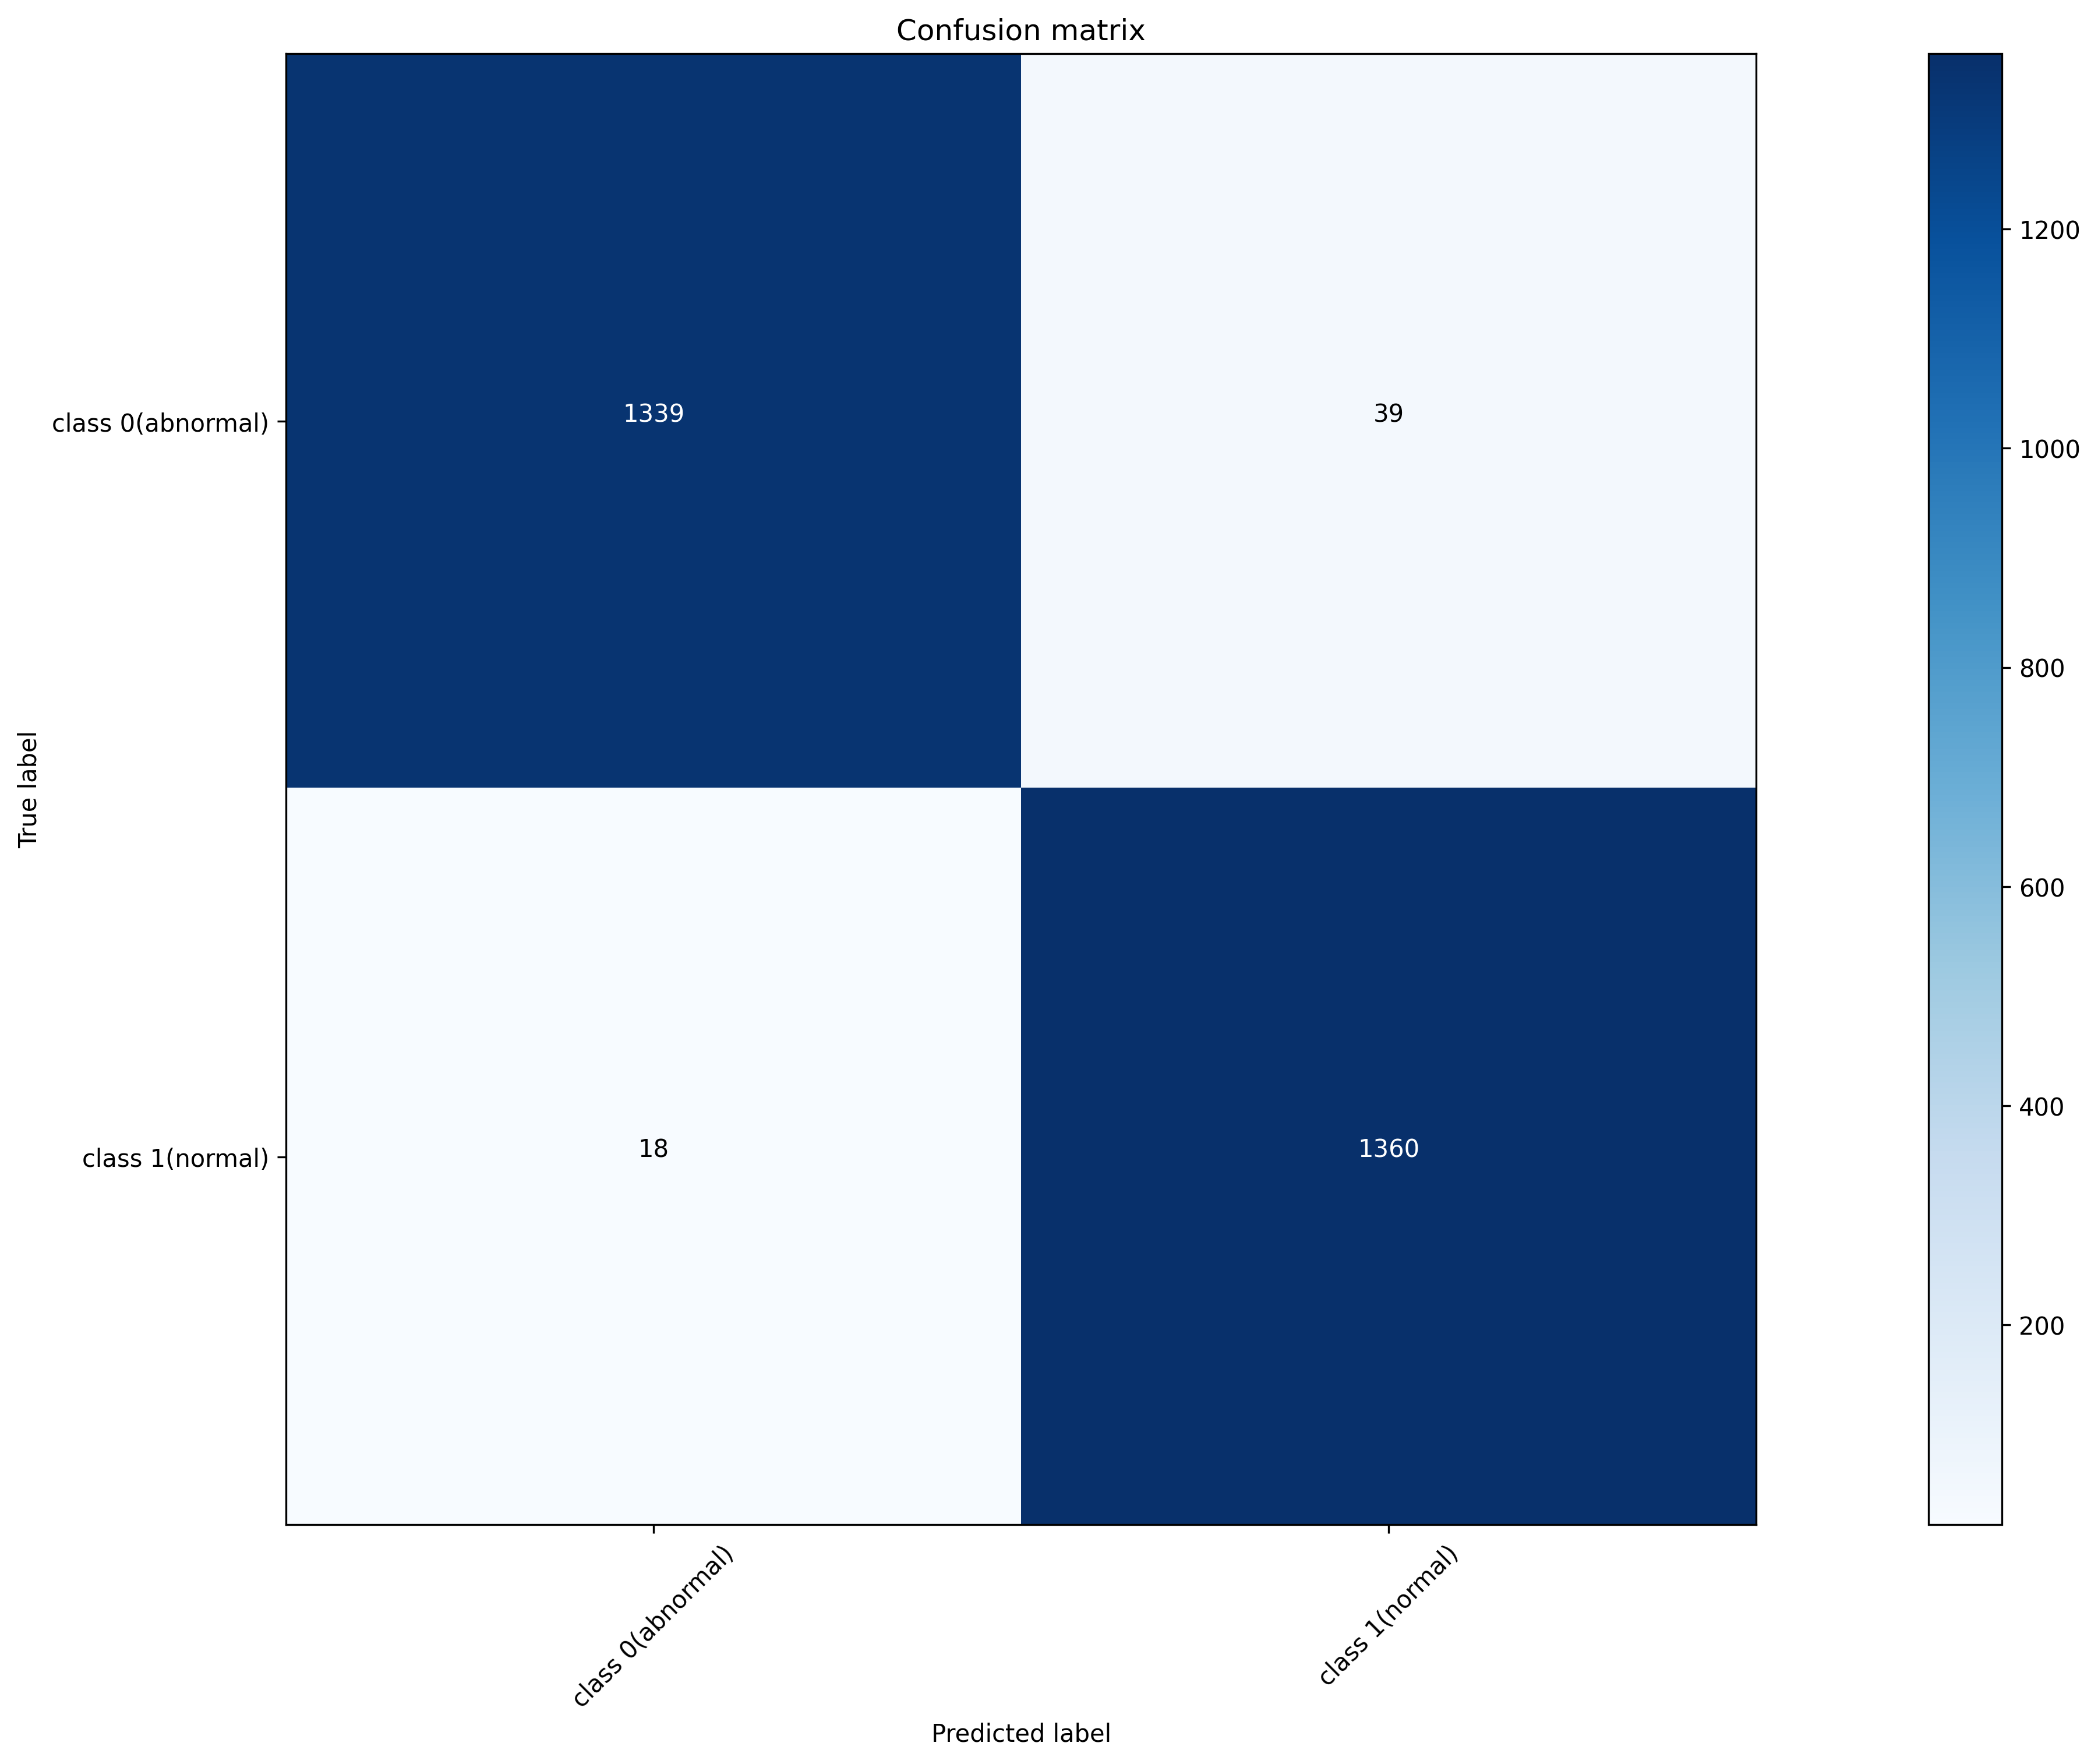

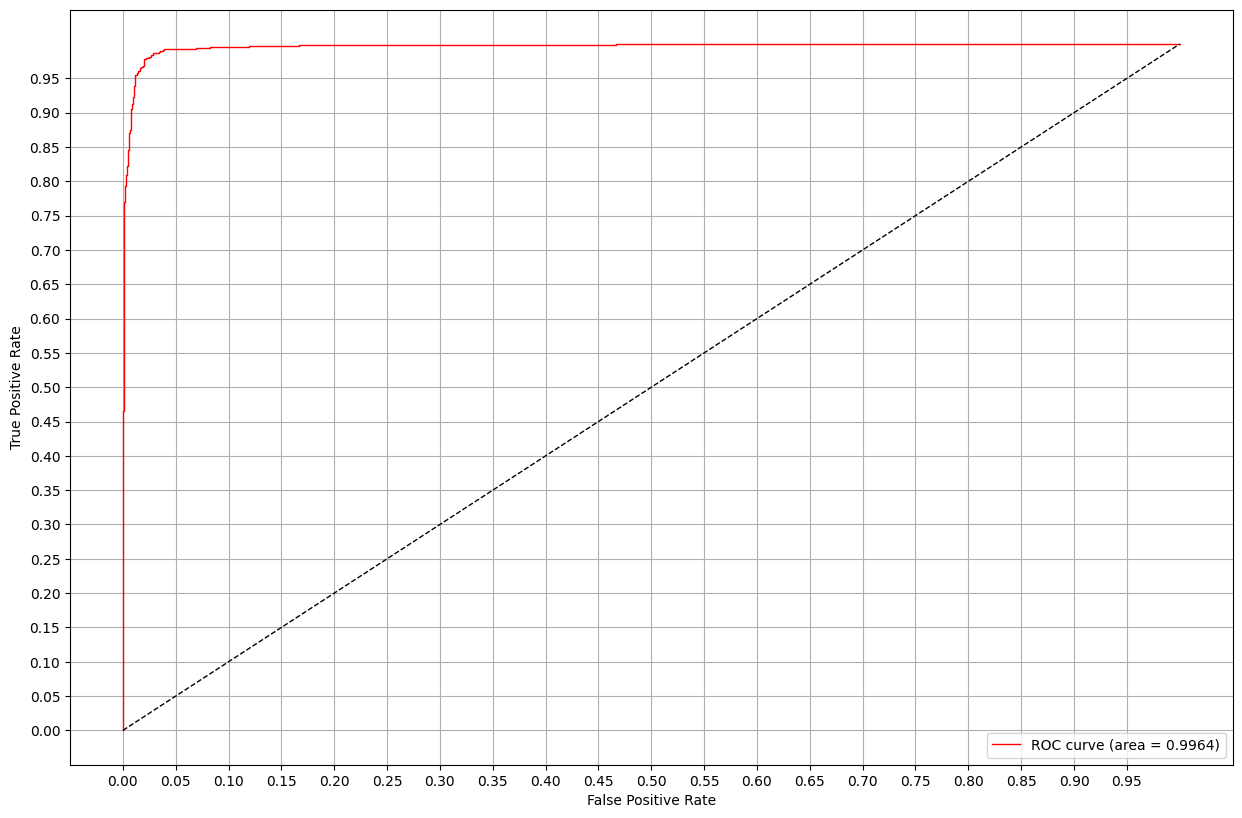

In [33]:
 #%% Pair E

pair_E_ensemble_model = ensemble(pair_E, model_input)
pair_E_ensemble_model.save('weights/ensemblemodel_pairE.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
E_ensem_y_pred = pair_E_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
E_ensemble_model_accuracy = accuracy_score(Y_test,E_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair E_ Ensemble model is: ', E_ensemble_model_accuracy)

#evaluate mean squared error
E_ensemble_model_custom_mse = mean_squared_error(Y_test,E_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair E Ensemble model is: ', E_ensemble_model_custom_mse)

#evaluate mean squared log error
E_ensemble_model_custom_msle = mean_squared_log_error(Y_test,E_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair E Ensemble model is: ', E_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,E_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,E_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, E_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_6')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_7')>]
The Ensemble Model is Saved
The accuracy of the Pair F_ Ensemble model is:  0.9764150943396226
The Mean Squared Error of the Pair F_ Ensemble model is:  0.02358490566037736
The Mean Squared Log Error of the Pair F_Ensemble model is:  0.011331439007504749
                   precision    recall  f1-score   support

class 0(abnormal)     0.9838    0.9688    0.9762      1378
  class 1(normal)     0.9693    0.9840    0.9766      1378

         accuracy                         0.9764      2756
        macro avg     0.9765    0.9764    0.9764      2756
     weighted avg     0.9765    0.9764    0.9764      2756

Confusion matrix, without normalization
[[1335   43]
 [  22 1356]]


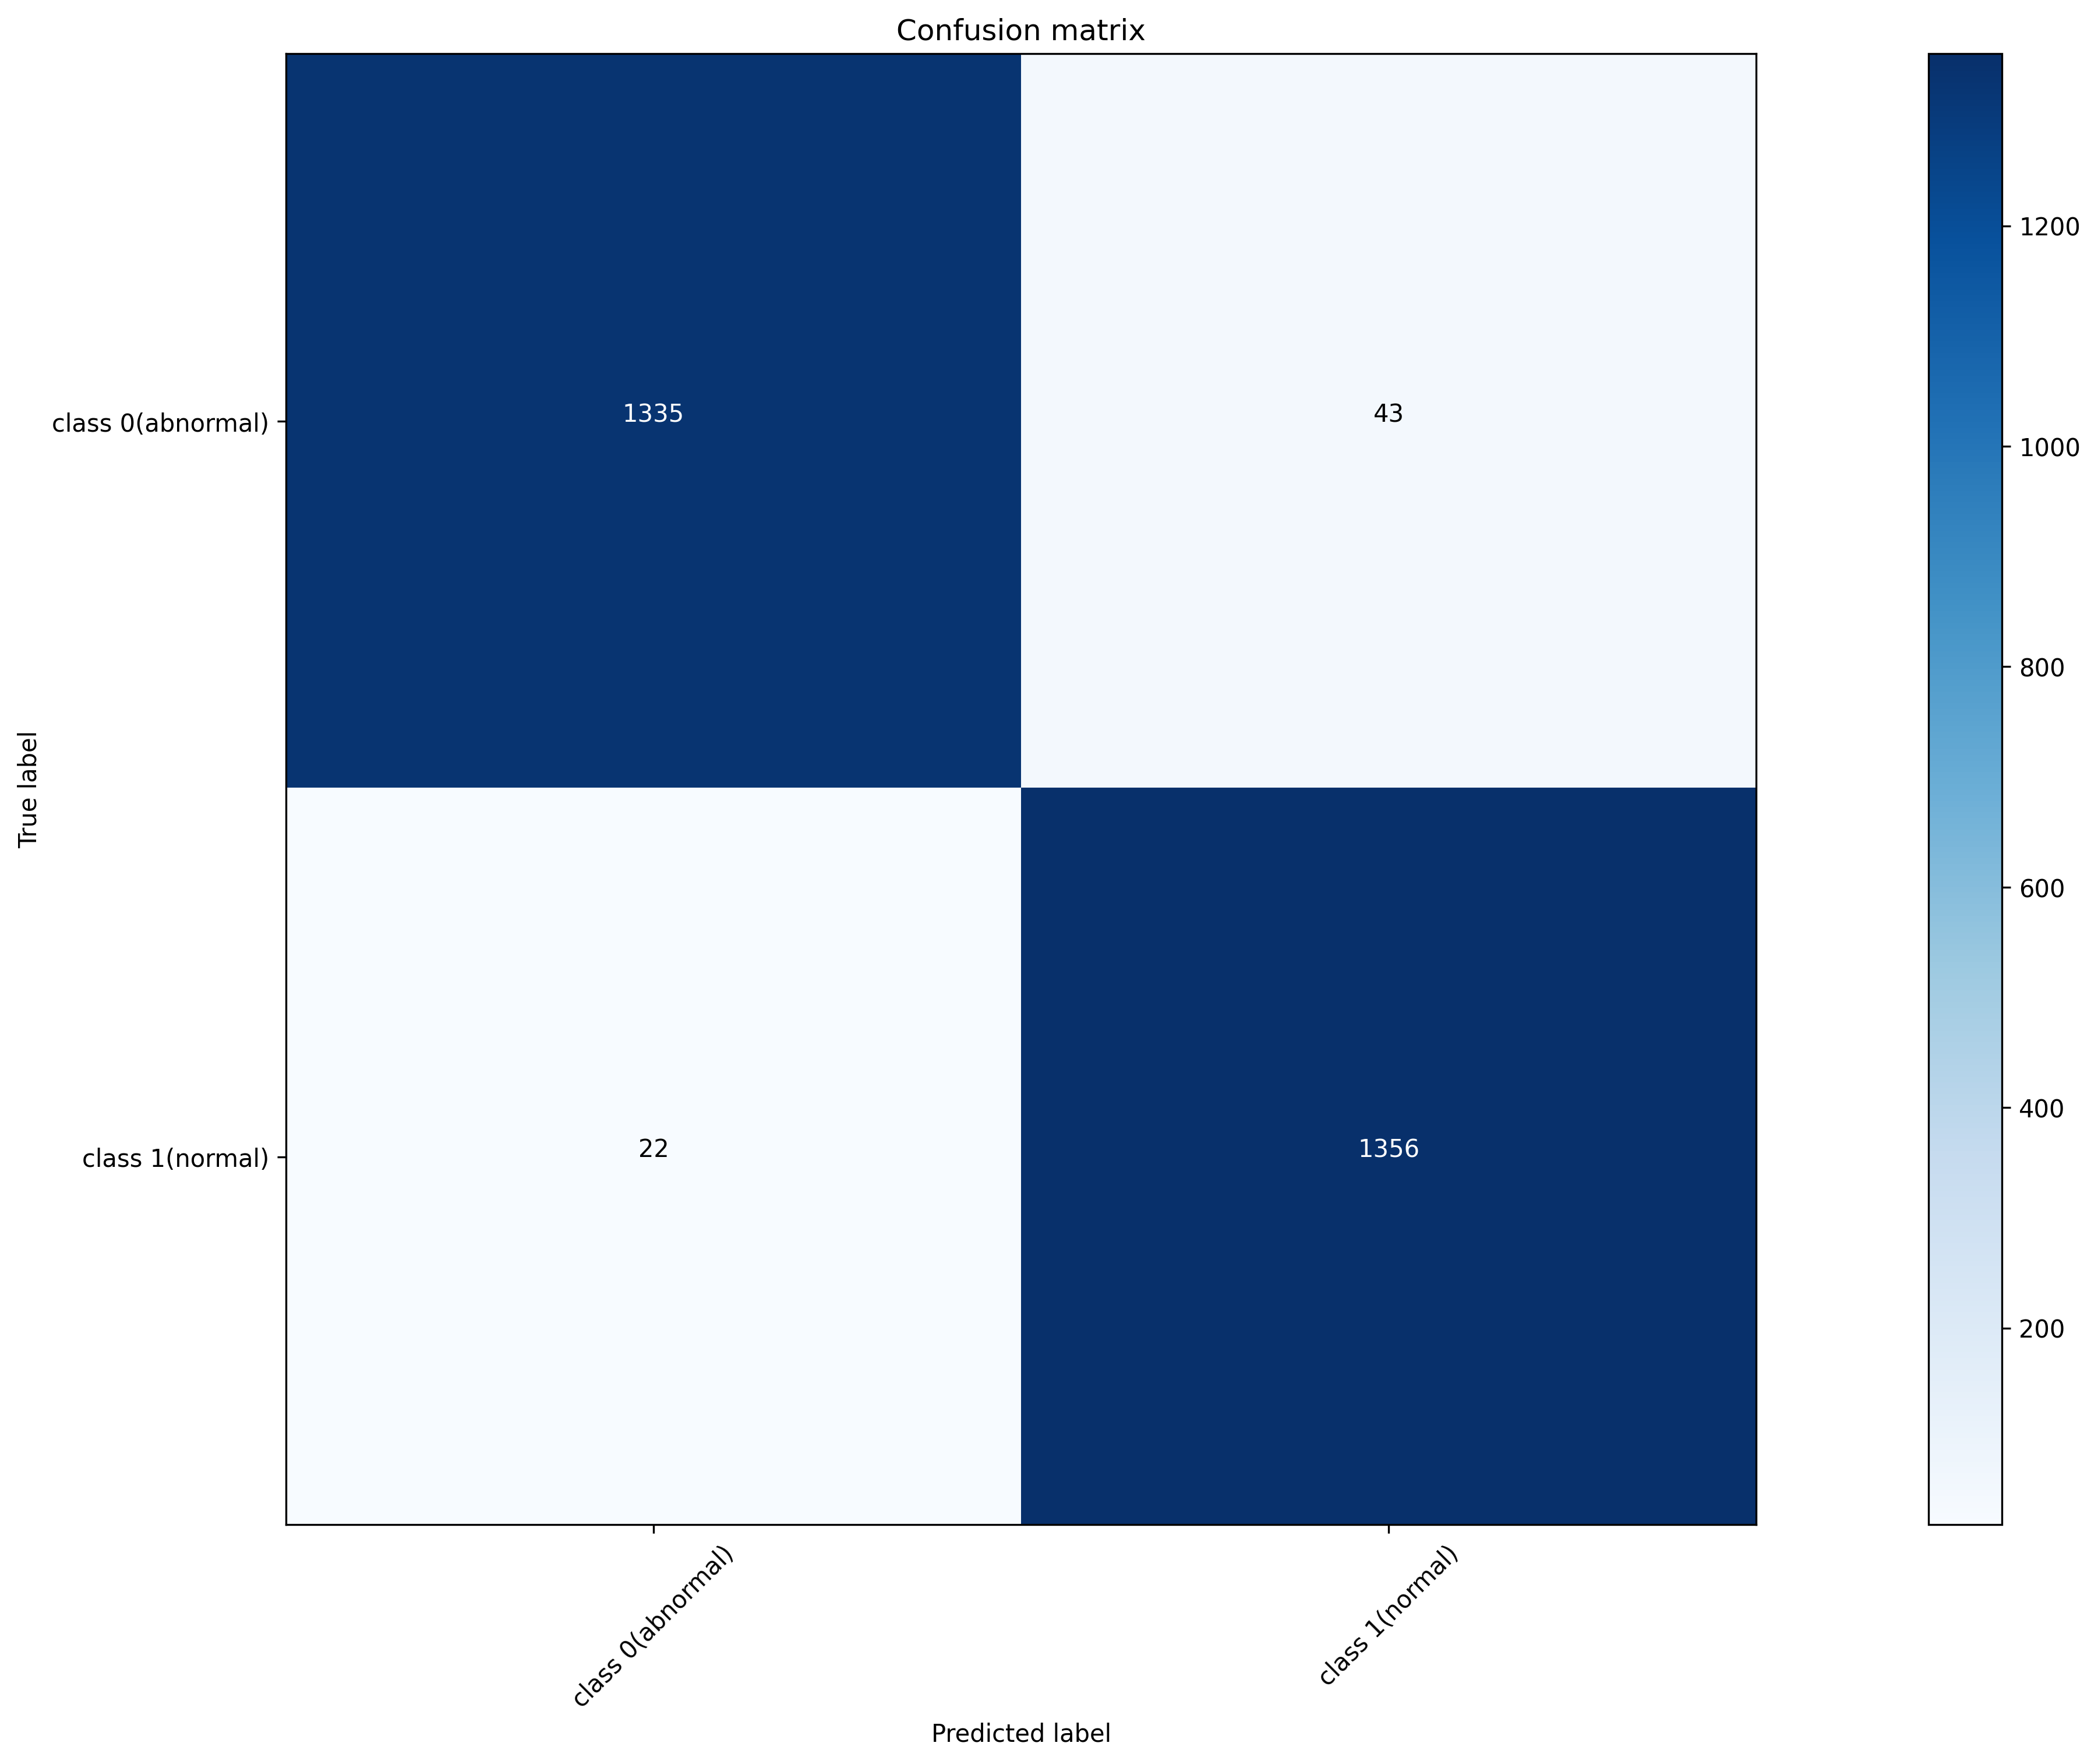

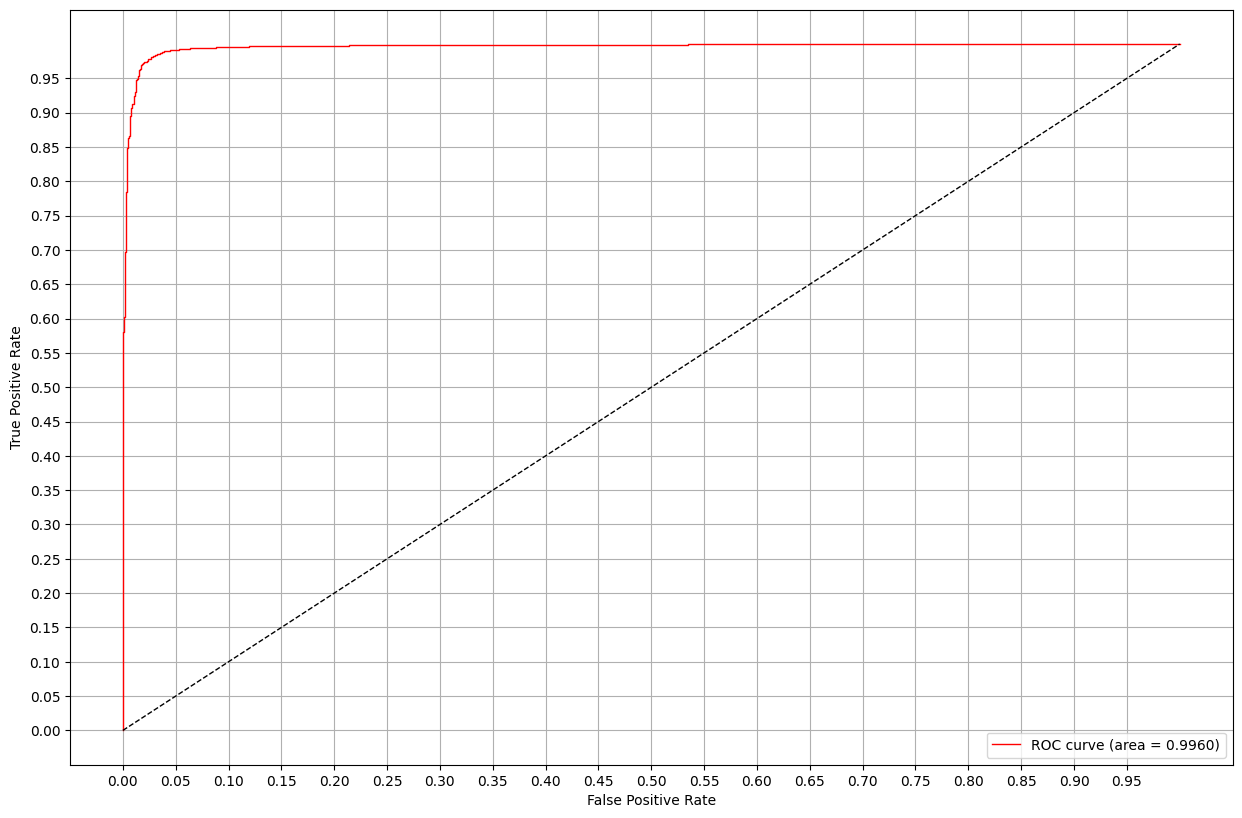

In [34]:
 #%% Pair F

pair_F_ensemble_model = ensemble(pair_F, model_input)
pair_F_ensemble_model.save('weights/ensemblemodel_pairF.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
F_ensem_y_pred = pair_F_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
F_ensemble_model_accuracy = accuracy_score(Y_test,F_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair F_ Ensemble model is: ', F_ensemble_model_accuracy)

#evaluate mean squared error
F_ensemble_model_custom_mse = mean_squared_error(Y_test,F_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair F_ Ensemble model is: ', F_ensemble_model_custom_mse)

#evaluate mean squared log error
F_ensemble_model_custom_msle = mean_squared_log_error(Y_test,F_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair F_Ensemble model is: ', F_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,F_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,F_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, F_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_5')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_6')>]
The Ensemble Model is Saved
The accuracy of the Pair G_ Ensemble model is:  0.9691582002902758
The Mean Squared Error of the Pair G_ Ensemble model is:  0.030841799709724237
The Mean Squared Log Error of the Pair G_ Ensemble model is:  0.014818035625198518
                   precision    recall  f1-score   support

class 0(abnormal)     0.9867    0.9717    0.9792      1378
  class 1(normal)     0.9721    0.9869    0.9795      1378

         accuracy                         0.9793      2756
        macro avg     0.9794    0.9793    0.9793      2756
     weighted avg     0.9794    0.9793    0.9793      2756

Confusion matrix, without normalization
[[1320   58]
 [  27 1351]]


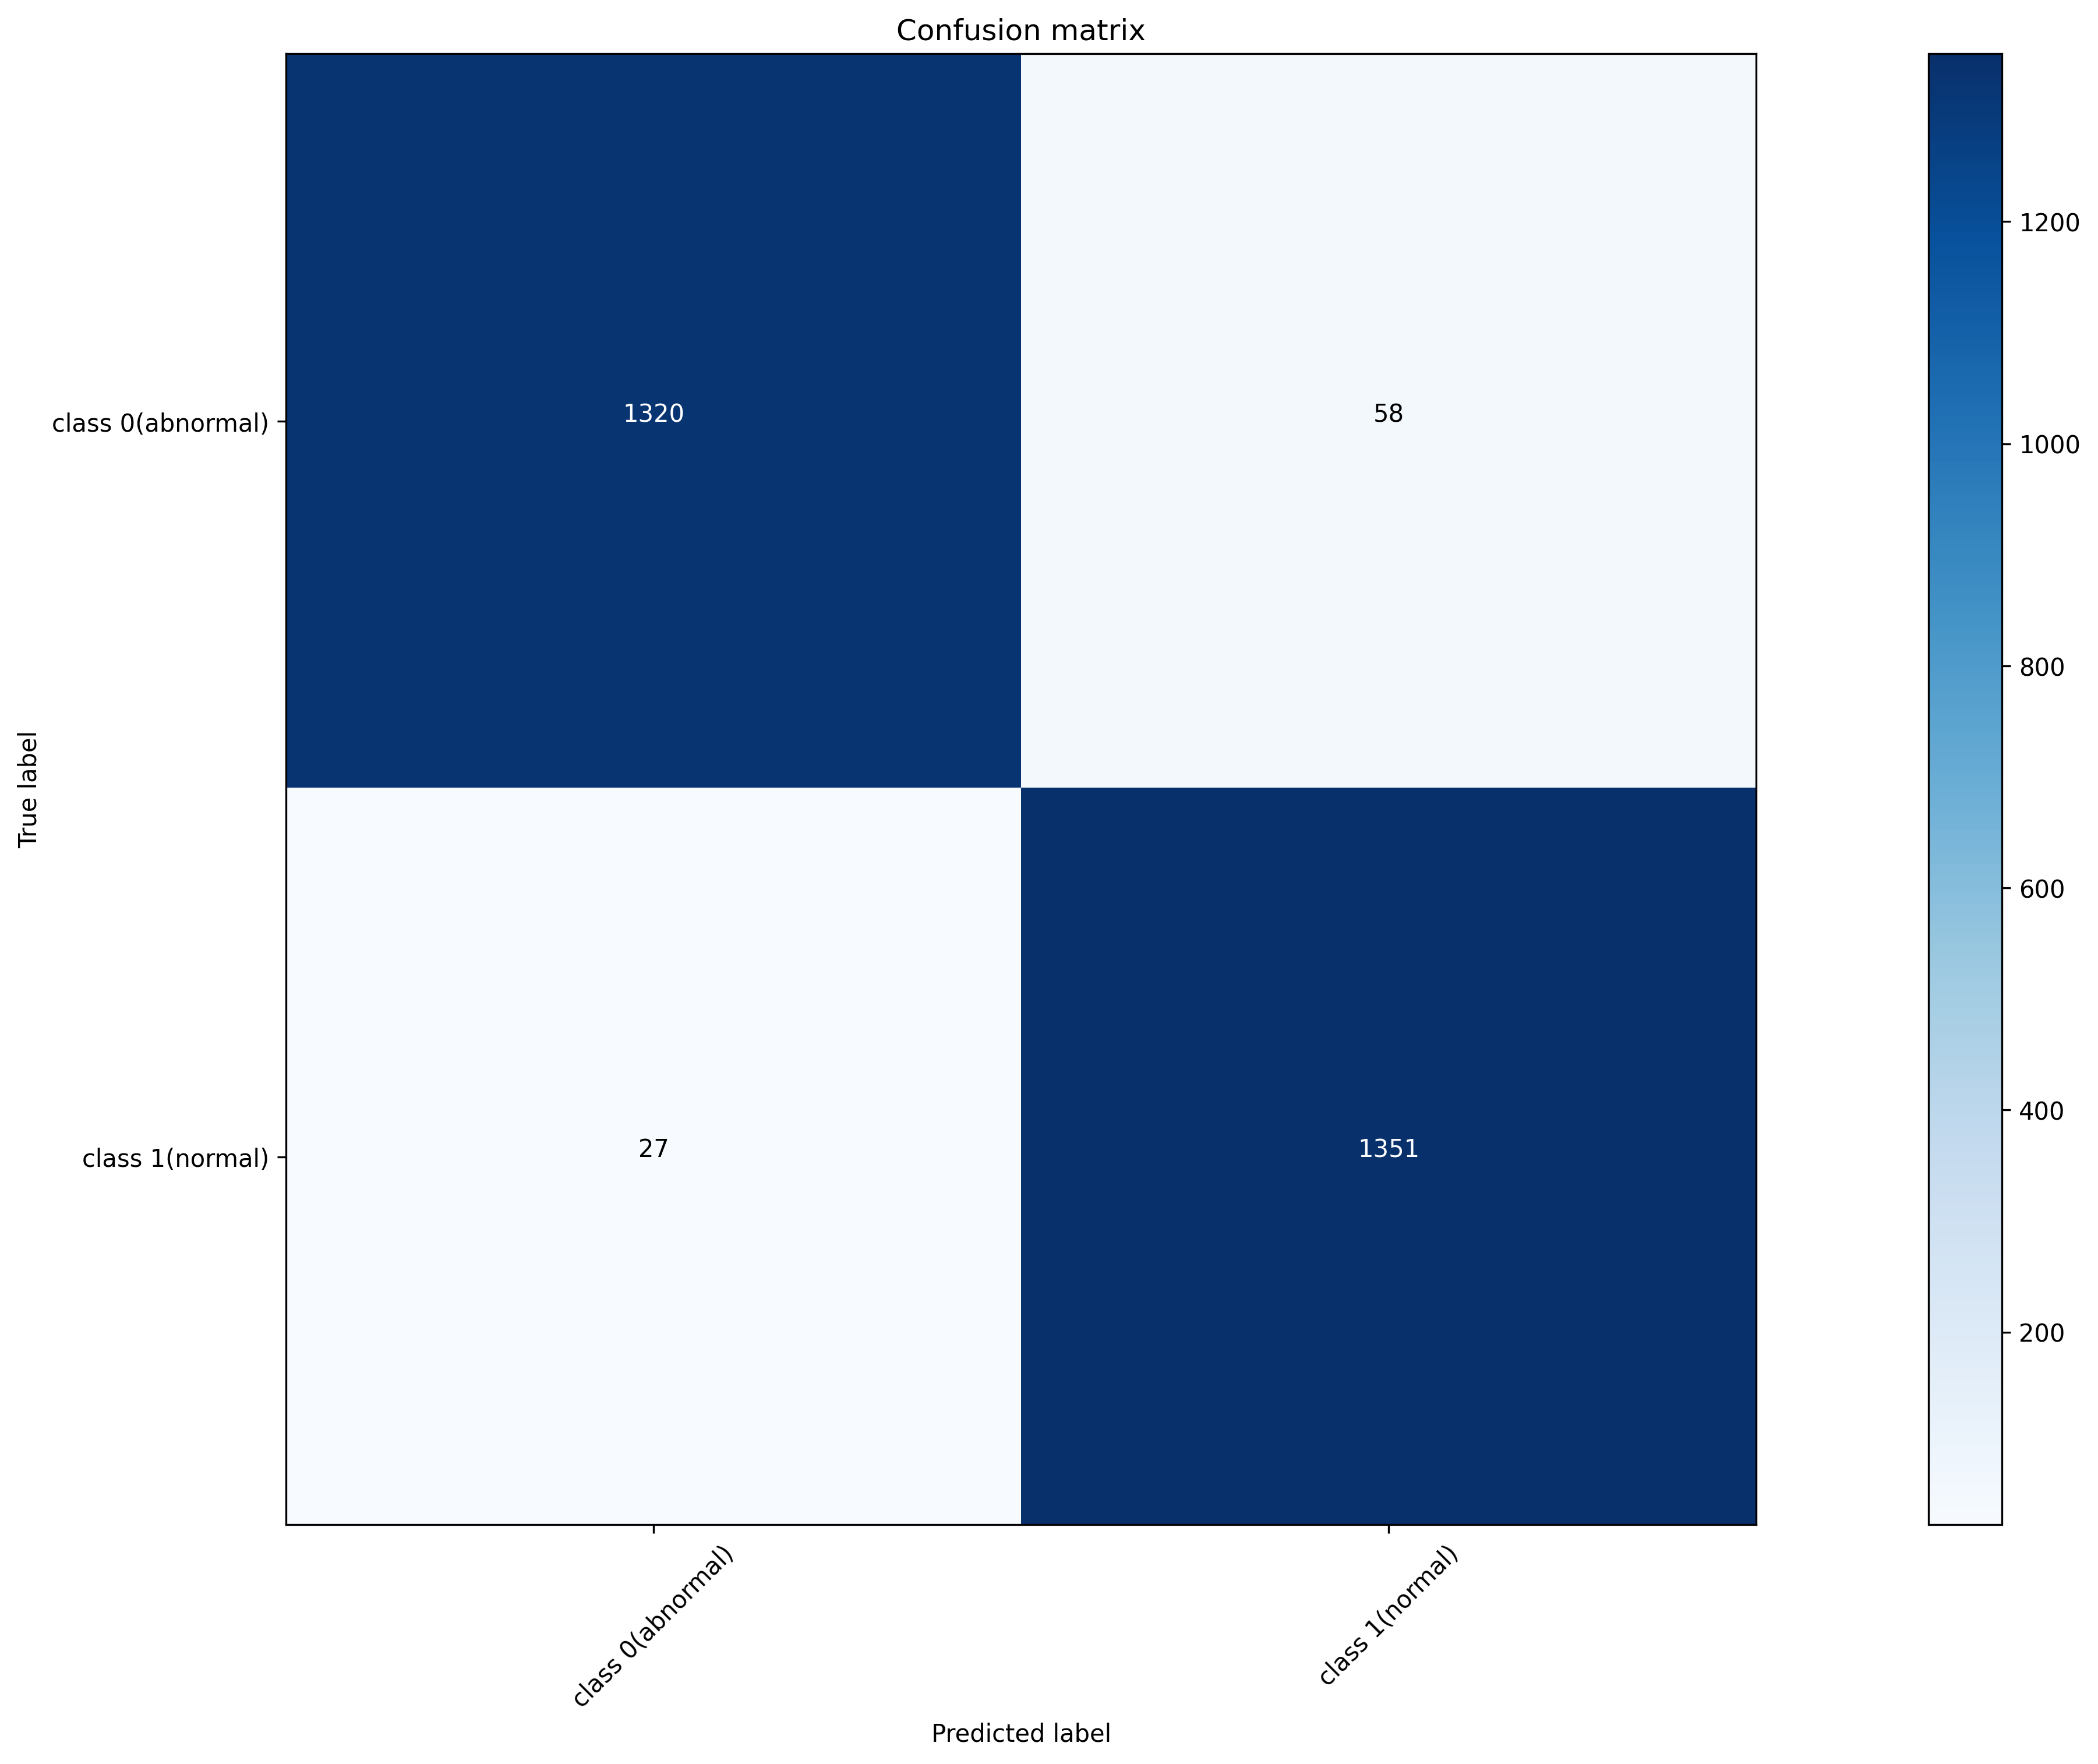

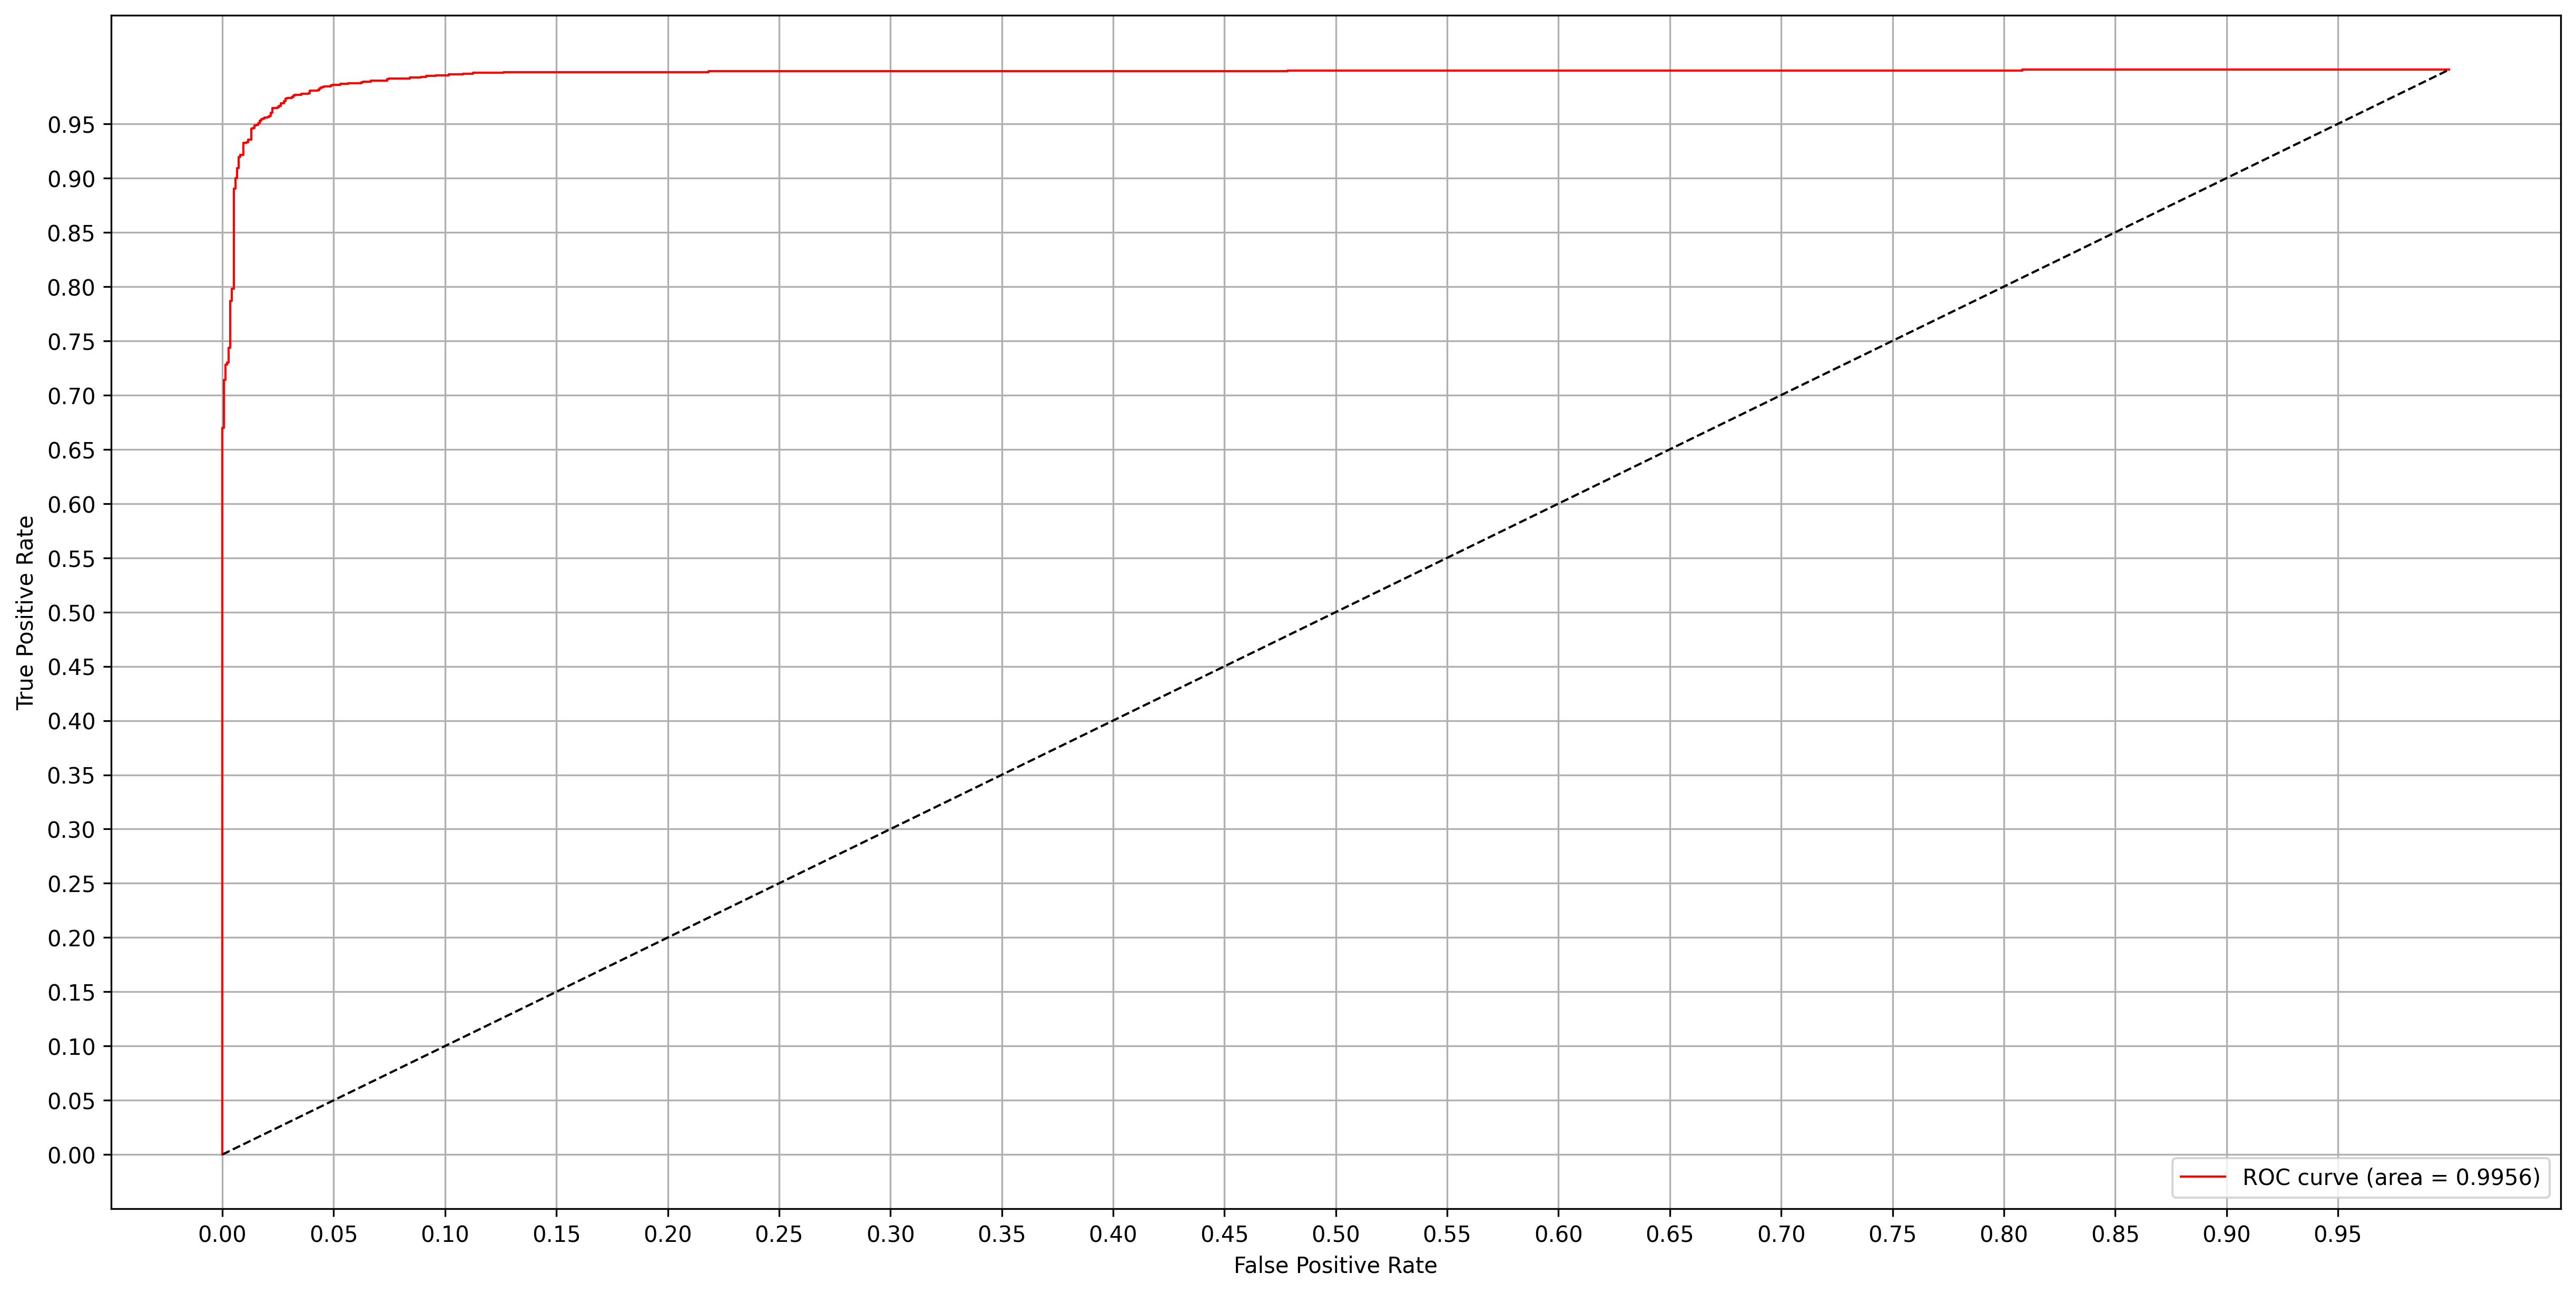

In [35]:
 #%% Pair G

pair_G_ensemble_model = ensemble(pair_G, model_input)
pair_G_ensemble_model.save('weights/ensemblemodel_pairG.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
G_ensem_y_pred = pair_G_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
G_ensemble_model_accuracy = accuracy_score(Y_test,G_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair G_ Ensemble model is: ', G_ensemble_model_accuracy)

#evaluate mean squared error
G_ensemble_model_custom_mse = mean_squared_error(Y_test,G_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair G_ Ensemble model is: ', G_ensemble_model_custom_mse)

#evaluate mean squared log error
G_ensemble_model_custom_msle = mean_squared_log_error(Y_test,G_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair G_ Ensemble model is: ', G_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,E_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,G_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, G_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'custom_dense2')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_5')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_7')>]
The Ensemble Model is Saved
The accuracy of the Pair H_ Ensemble model is:  0.9756894049346879
The Mean Squared Error of the Pair H_ Ensemble model is:  0.024310595065312045
The Mean Squared Log Error of the Pair H_ Ensemble model is:  0.011680098669274126
                   precision    recall  f1-score   support

class 0(abnormal)     0.9867    0.9717    0.9792      1378
  class 1(normal)     0.9721    0.9869    0.9795      1378

         accuracy                         0.9793      2756
        macro avg     0.9794    0.9793    0.9793      2756
     weighted avg     0.9794    0.9793    0.9793      2756

Confusion matrix, without normalization
[[1330   48]
 [  19 1359]]


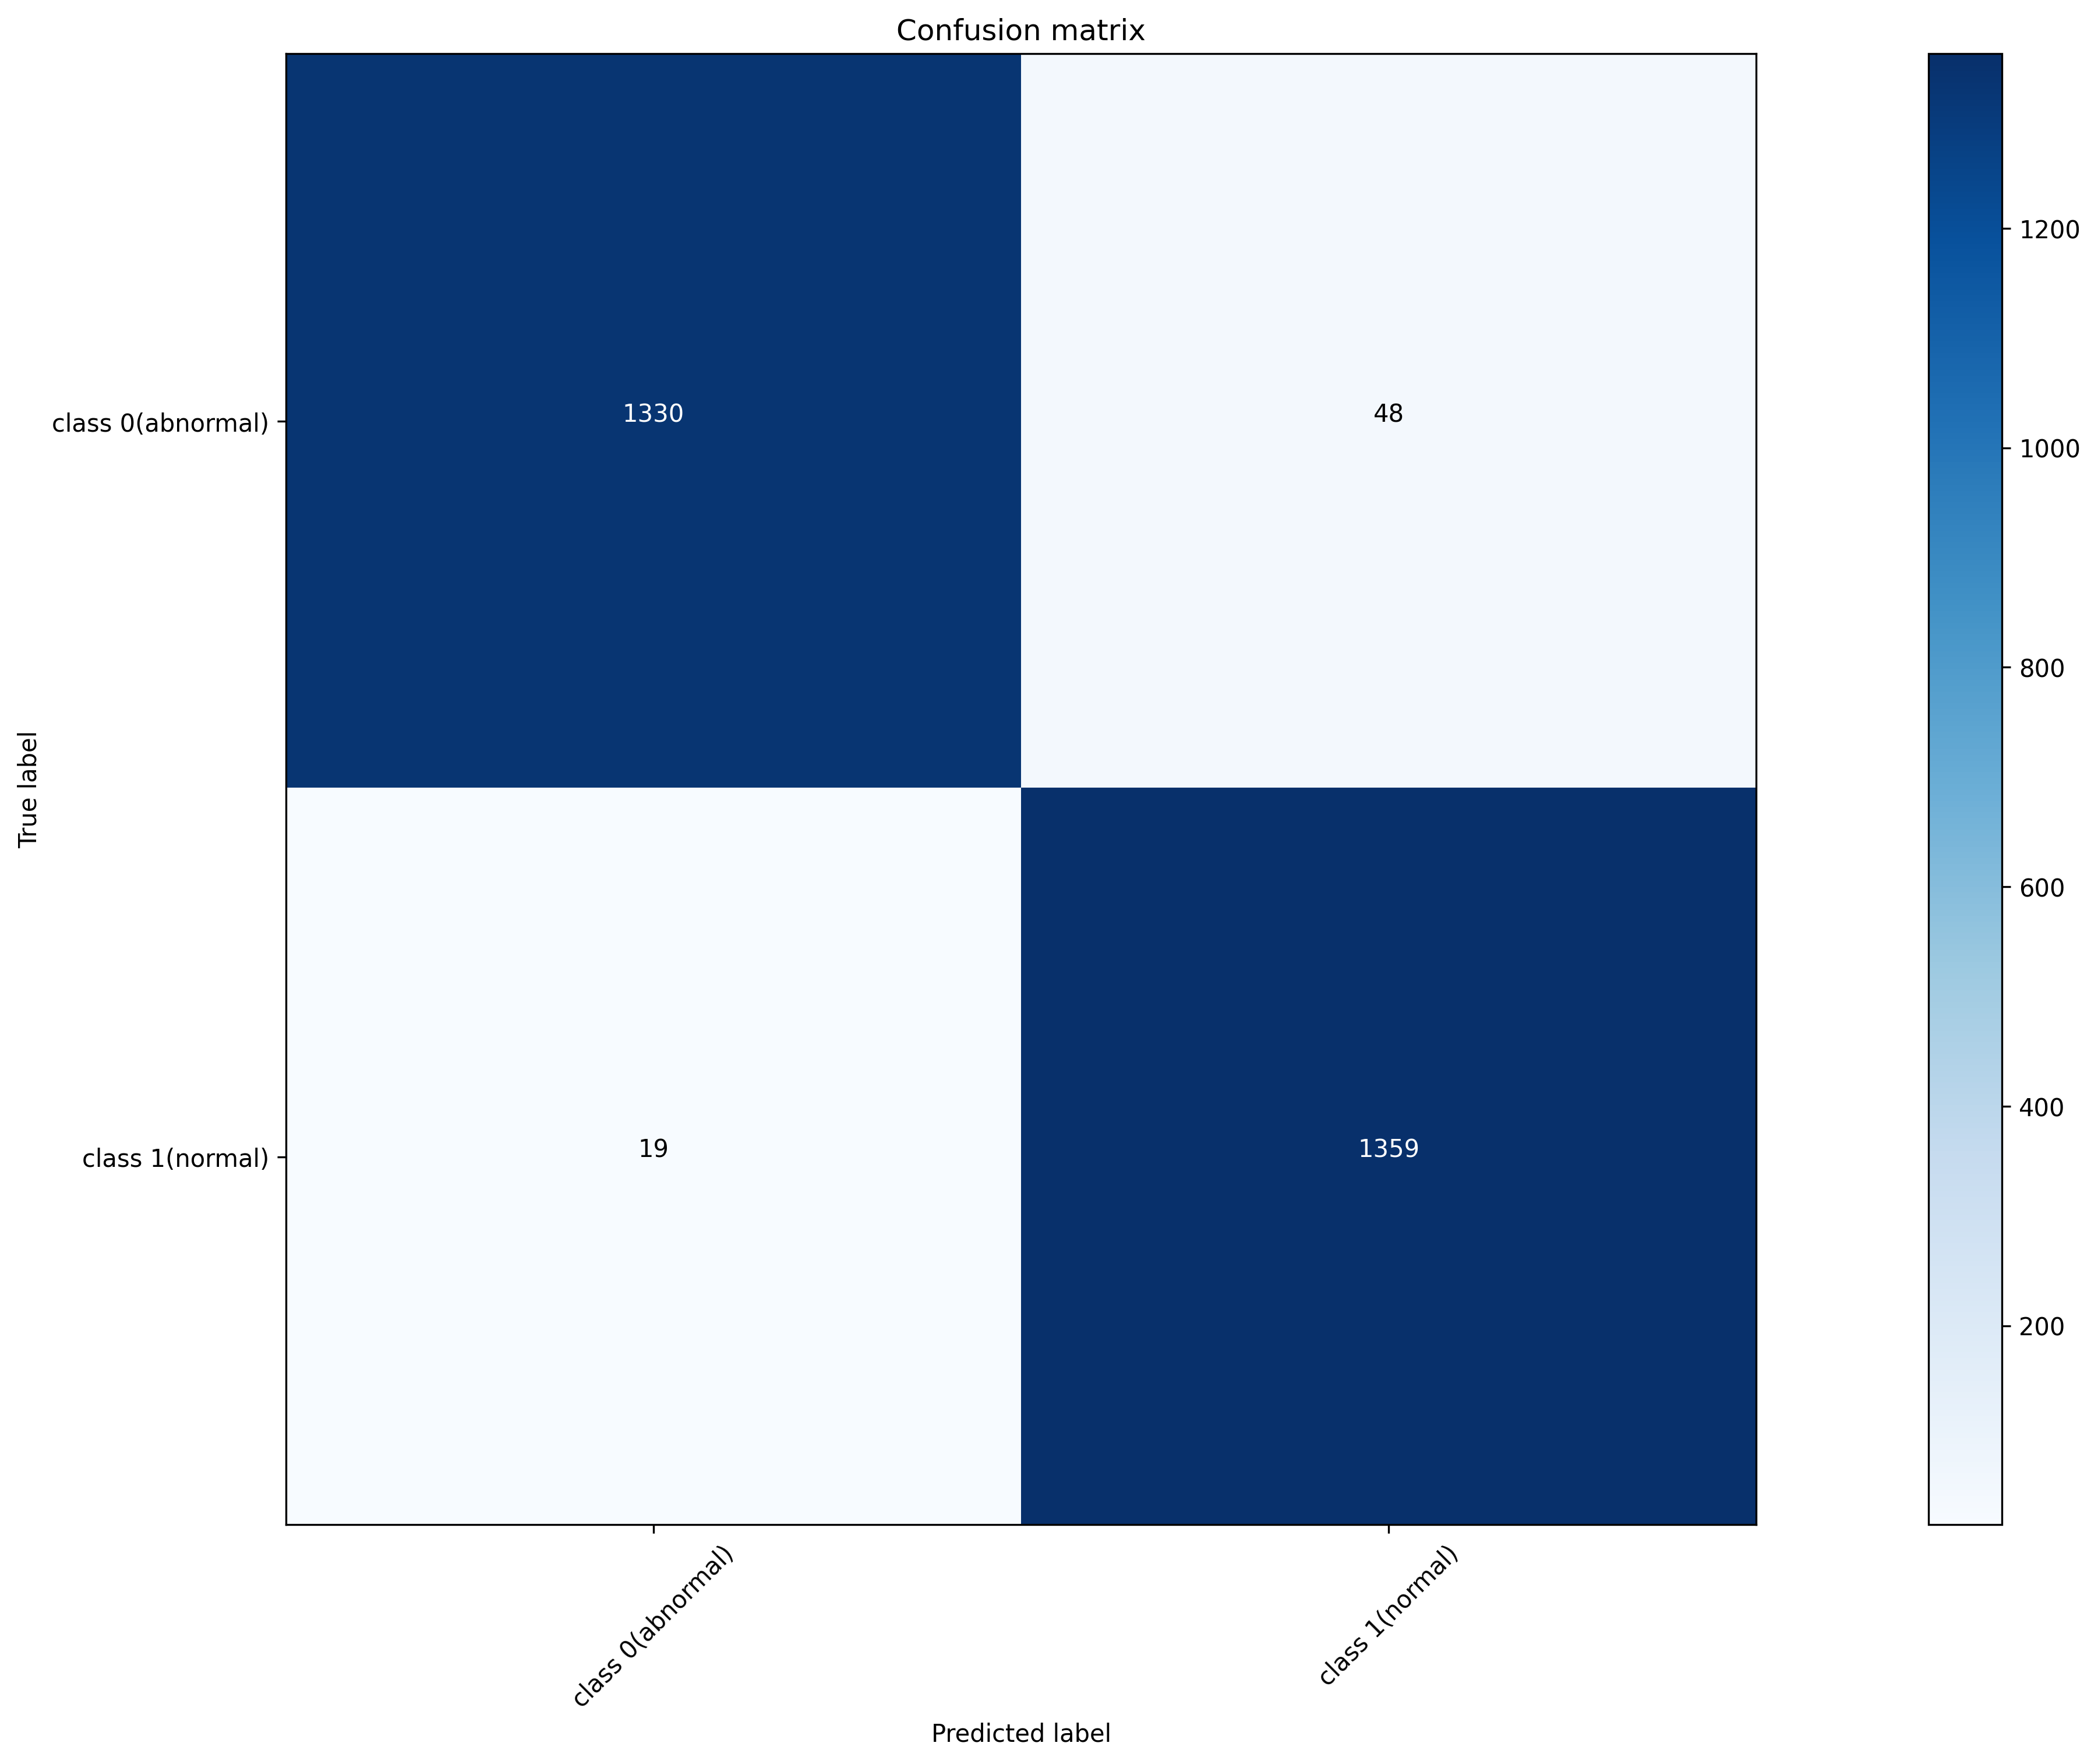

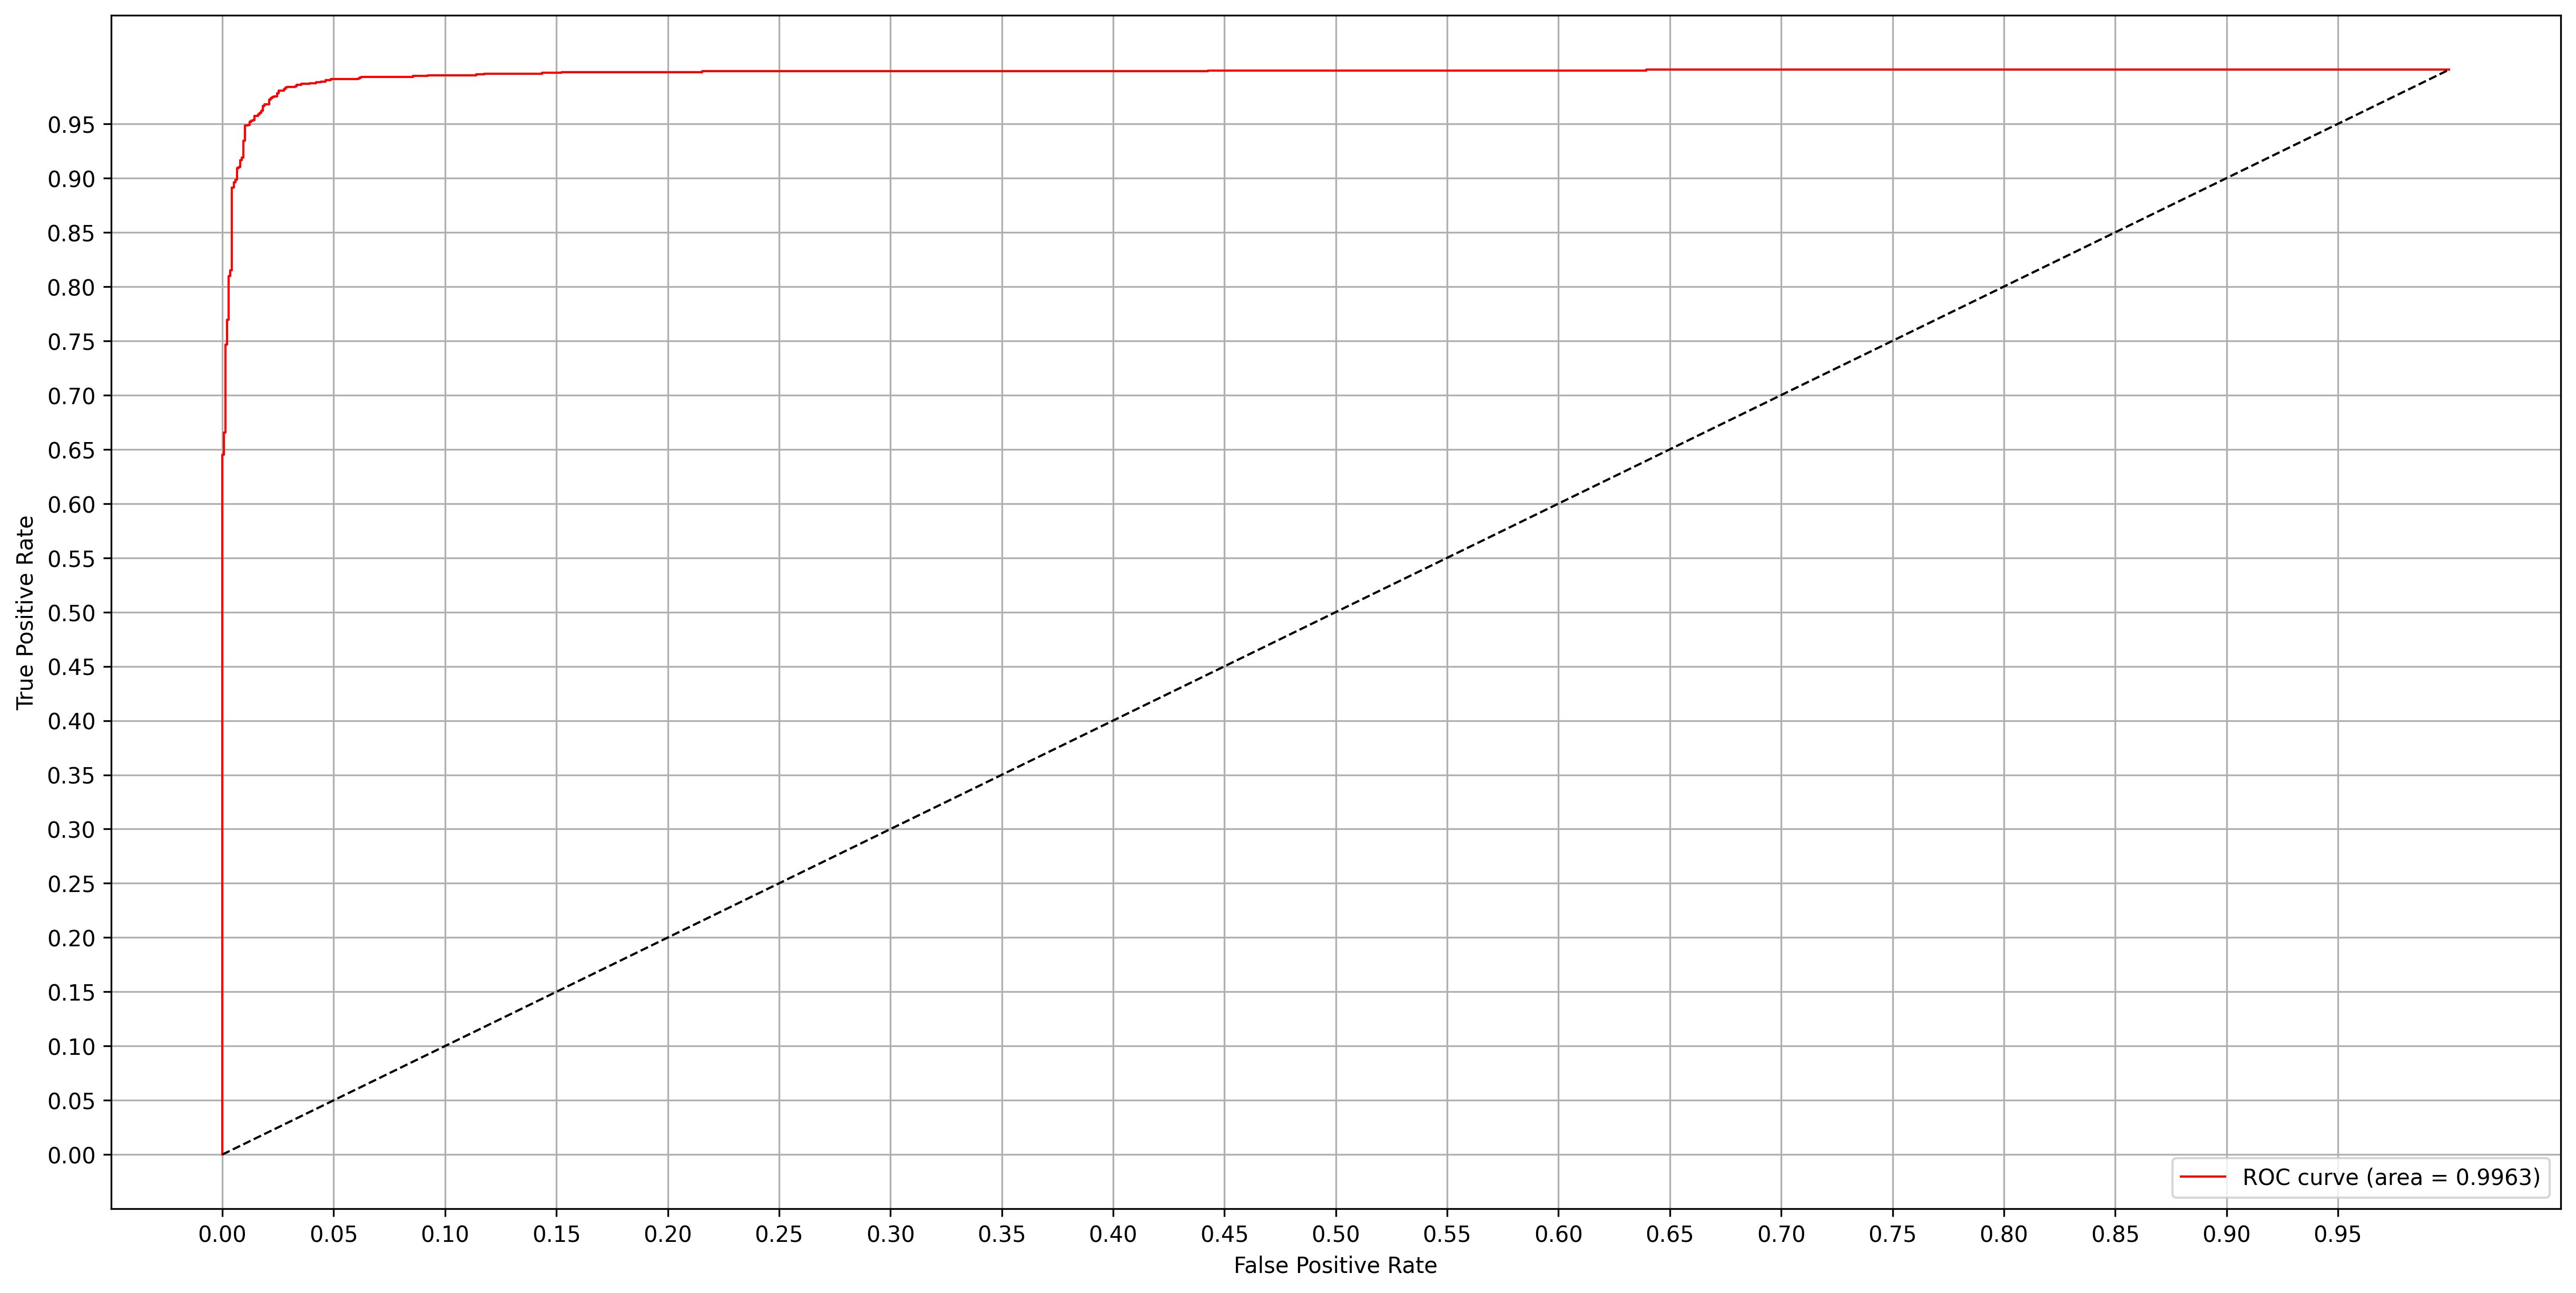

In [36]:
#%% Pair H

pair_H_ensemble_model = ensemble(pair_H, model_input)
pair_H_ensemble_model.save('weights/ensemblemodel_pairH.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
H_ensem_y_pred = pair_H_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
H_ensemble_model_accuracy = accuracy_score(Y_test,H_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair H_ Ensemble model is: ', H_ensemble_model_accuracy)

#evaluate mean squared error
H_ensemble_model_custom_mse = mean_squared_error(Y_test,H_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair H_ Ensemble model is: ', H_ensemble_model_custom_mse)

#evaluate mean squared log error
H_ensemble_model_custom_msle = mean_squared_log_error(Y_test,H_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair H_ Ensemble model is: ', H_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,E_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,H_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, H_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_5')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_6')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_7')>]
The Ensemble Model is Saved
The accuracy of the Pair I_ Ensemble model is:  0.977866473149492
The Mean Squared Error of the Pair I_ Ensemble model is:  0.022133526850507984
The Mean Squared Log Error of the Pair I_ Ensemble model is:  0.010634119683965996
                   precision    recall  f1-score   support

class 0(abnormal)     0.9853    0.9702    0.9777      1378
  class 1(normal)     0.9707    0.9855    0.9780      1378

         accuracy                         0.9779      2756
        macro avg     0.9780    0.9779    0.9779      2756
     weighted avg     0.9780    0.9779    0.9779      2756

Confusion matrix, without normalization
[[1337   41]
 [  20 1358]]


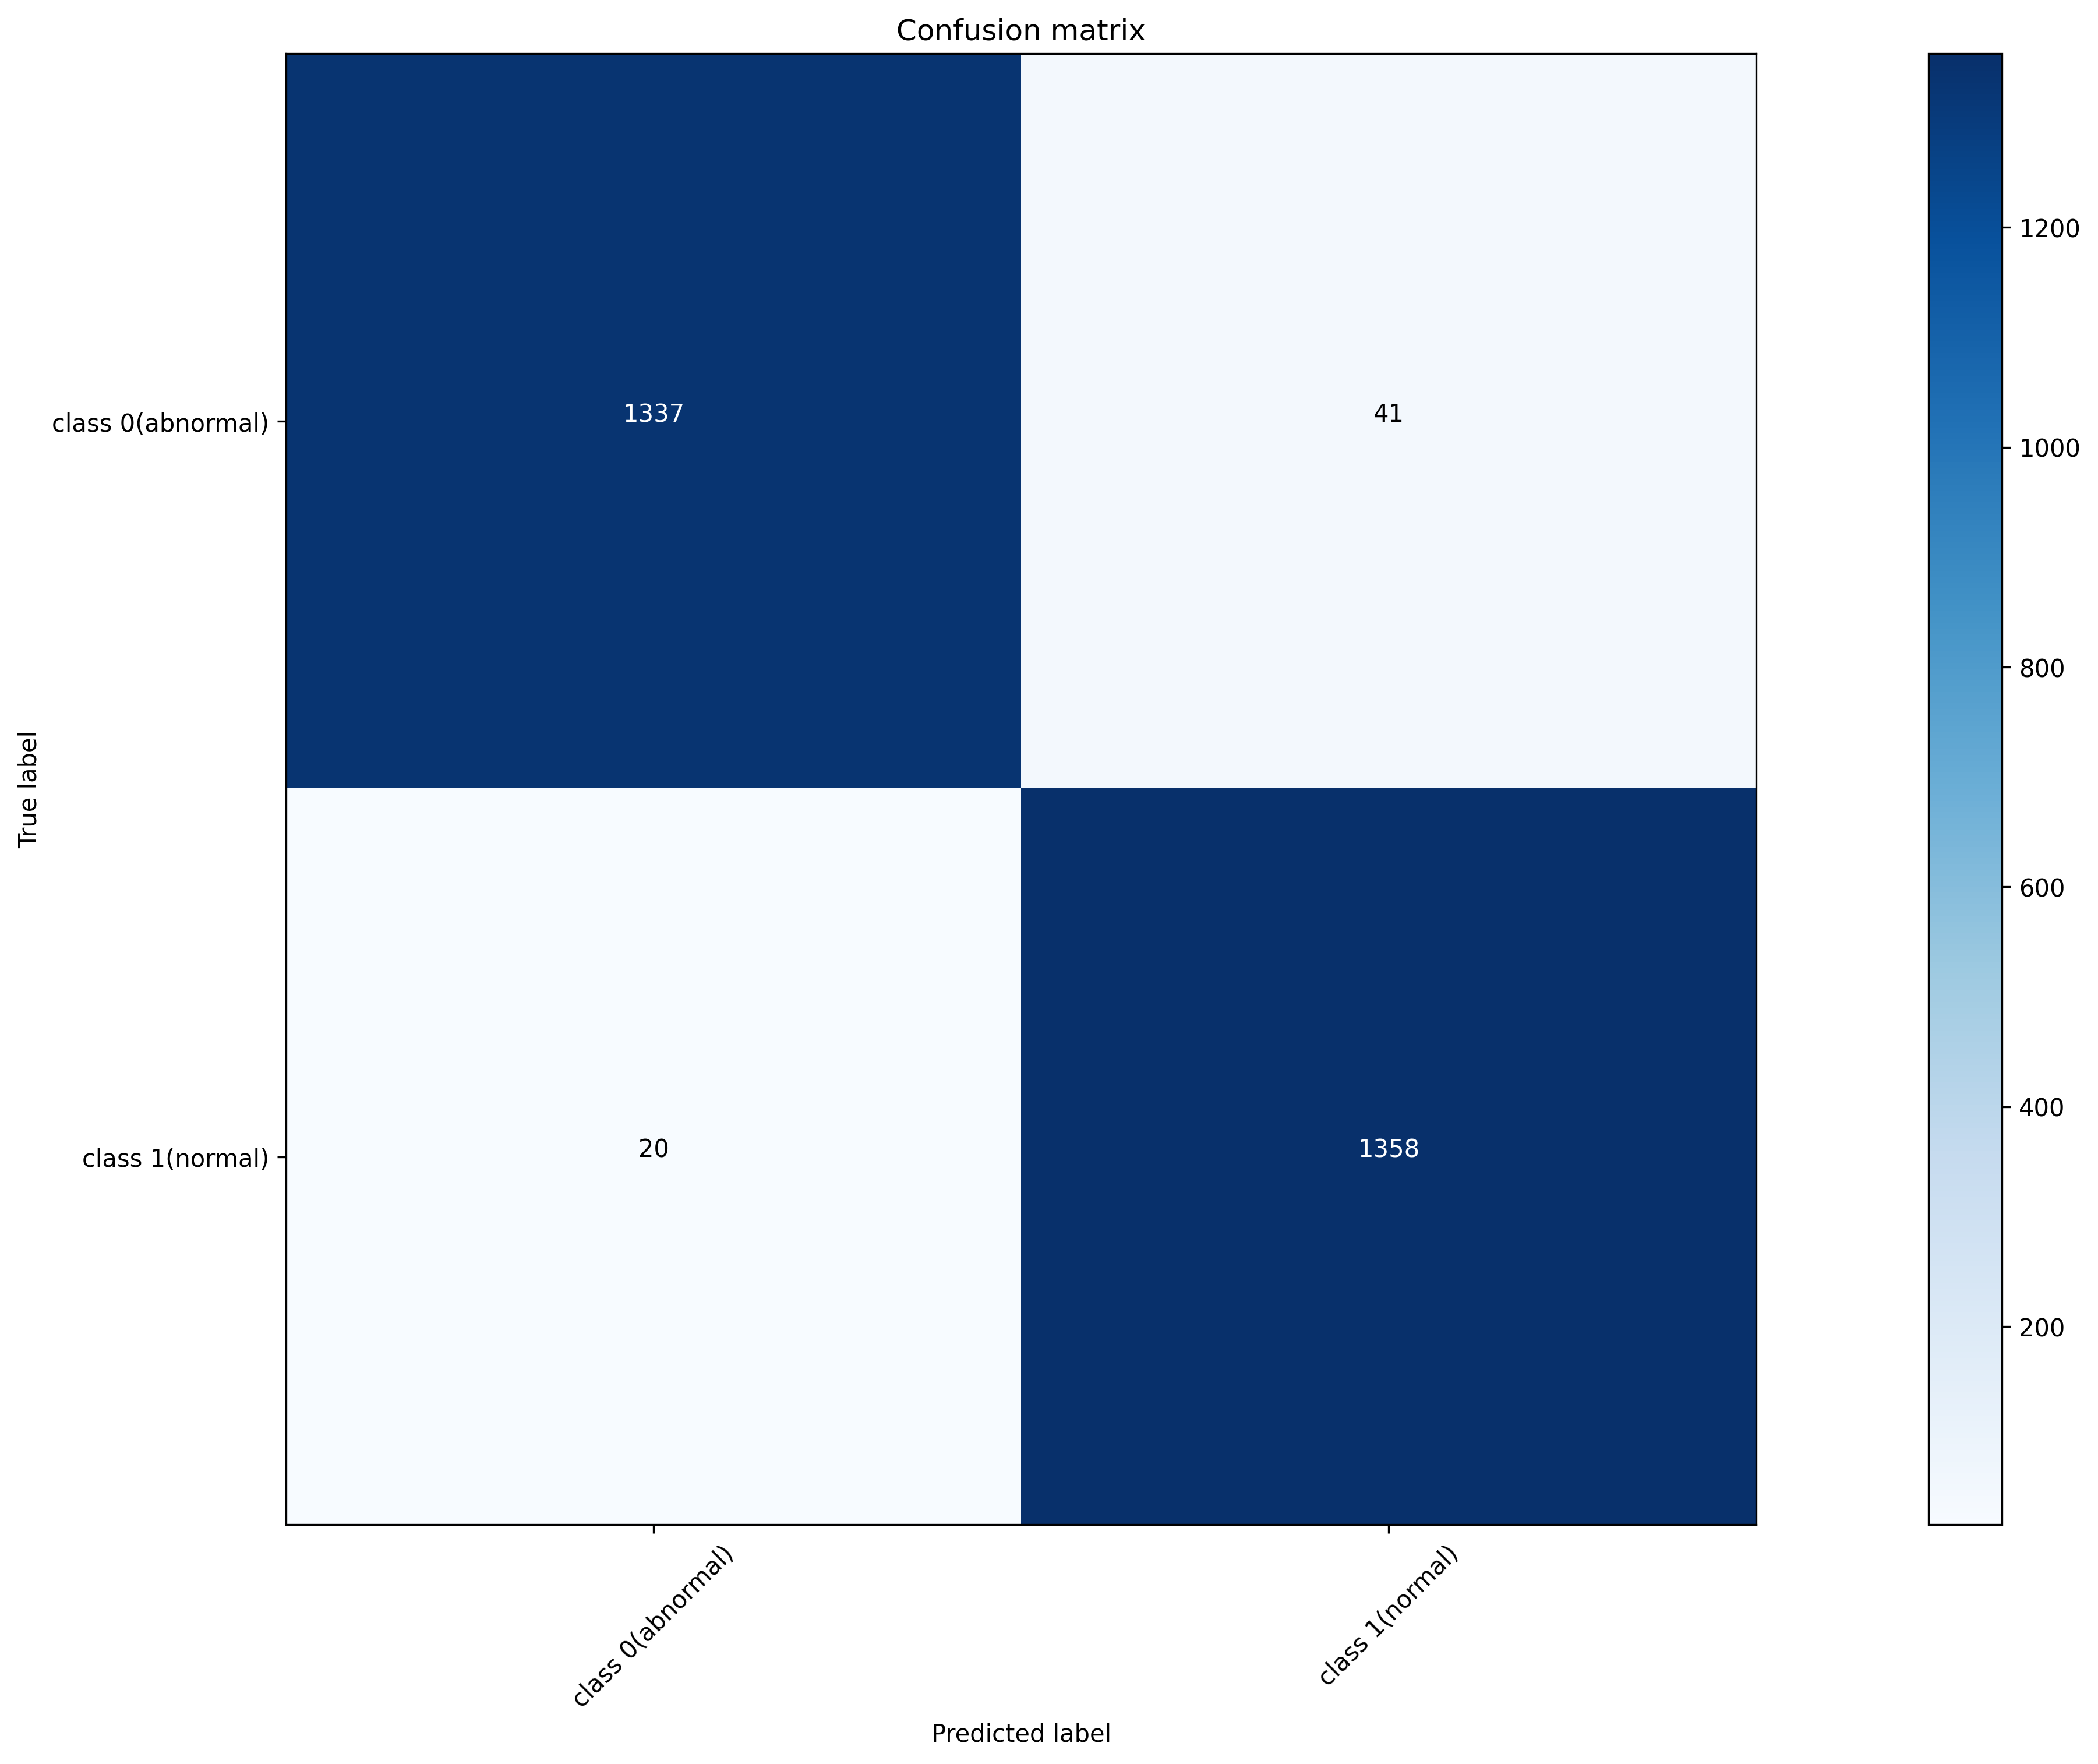

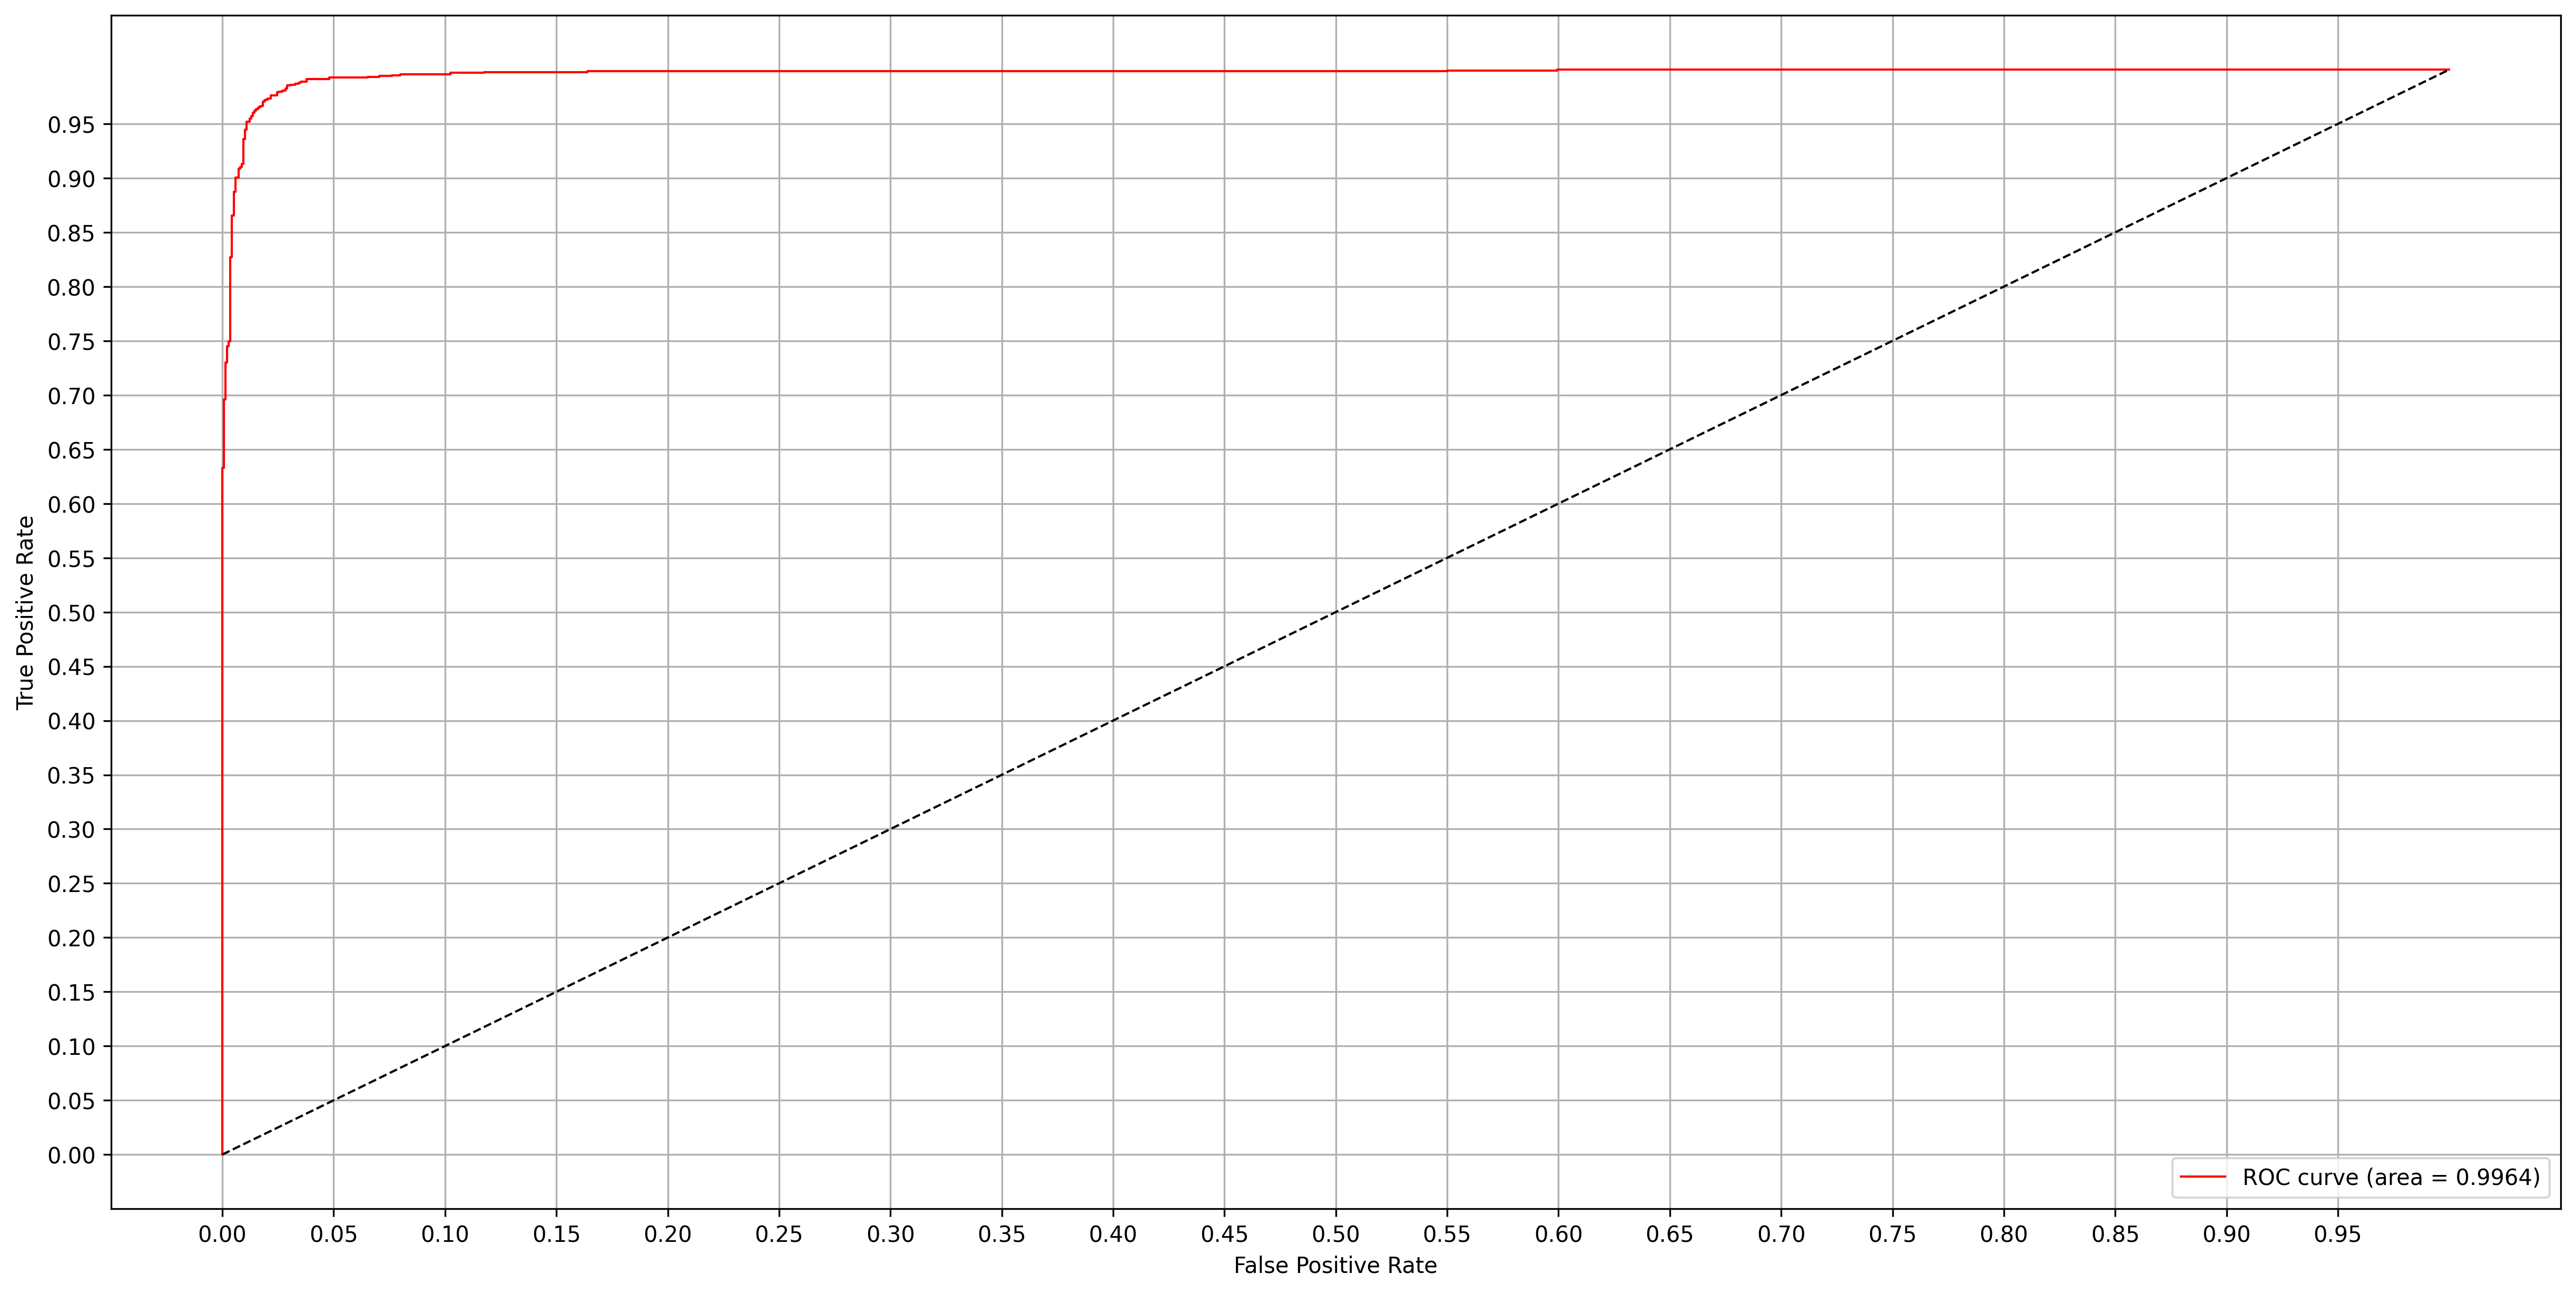

In [37]:
#%% Pair I

pair_I_ensemble_model = ensemble(pair_I, model_input)
pair_I_ensemble_model.save('weights/ensemblemodel_pairI.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
I_ensem_y_pred = pair_I_ensemble_model.predict(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
I_ensemble_model_accuracy = accuracy_score(Y_test,I_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair I_ Ensemble model is: ', I_ensemble_model_accuracy)

#evaluate mean squared error
I_ensemble_model_custom_mse = mean_squared_error(Y_test,I_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair I_ Ensemble model is: ', I_ensemble_model_custom_mse)

#evaluate mean squared log error
I_ensemble_model_custom_msle = mean_squared_log_error(Y_test,I_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair I_ Ensemble model is: ', I_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,I_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,I_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, I_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

## Testing with images taken on an OpenFlexure Microscope

In [149]:
import glob
from PIL import Image 
import cv2
import matplotlib.pyplot as plt
import os
filelist = glob.glob('Images/testing_openflexure/*.png')

directory = '../data/cell_images/train/Parasitized/'
n_pics = 30

for filename, n in zip(os.listdir(directory), range(0,n_pics)):
    if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
        filelist.append(os.path.join(directory, filename))
    else:
        continue

filelist

['Images/testing_openflexure/uninfected.png',
 'Images/testing_openflexure/possibly_infected.png',
 'Images/testing_openflexure/uninfected_noseg.png',
 'Images/testing_openflexure/uninfected2.png',
 'Images/testing_openflexure/infected3.png',
 'Images/testing_openflexure/uninfected2_noseg.png',
 'Images/testing_openflexure/infected2.png',
 'Images/testing_openflexure/infected.png',
 '../data/cell_images/train/Parasitized/C99P60ThinF_IMG_20150918_141351_cell_131.png',
 '../data/cell_images/train/Parasitized/C174P135NThinF_IMG_20151127_135554_cell_199.png',
 '../data/cell_images/train/Parasitized/C119P80ThinF_IMG_20151002_123043_cell_157.png',
 '../data/cell_images/train/Parasitized/C97P58ThinF_IMG_20150917_151437_cell_163.png',
 '../data/cell_images/train/Parasitized/C128P89ThinF_IMG_20151004_130810_cell_153.png',
 '../data/cell_images/train/Parasitized/C99P60ThinF_IMG_20150918_141129_cell_104.png',
 '../data/cell_images/train/Parasitized/C182P143NThinF_IMG_20151201_172057_cell_141.png'

In [150]:
imgs = [cv2.resize(cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGRA2BGR), (100, 100)) for fname in filelist]

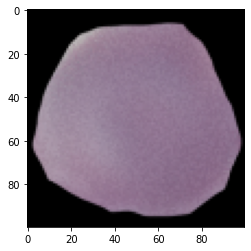

In [151]:
plt.imshow( imgs[3])

In [152]:
test_images = np.array([np.array(img) for img in imgs])

In [154]:
#%% Pair D

#pair_D_ensemble_model = ensemble(pair_D, model_input)


#evaluate accuracy
pred = vgg19_custom_model.predict(test_images, workers=1)

In [155]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [156]:
predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels


{0: 'Parasitized', 1: 'Uninfected'}

In [161]:
test_labels = [1,0,1,1,0,1,0,0] + [0] * n_pics
class_names = ['Parasitized', 'Uninfected']

In [162]:
pred

array([[0.0000e+00, 1.0000e+00],
       [1.0000e+00, 8.6512e-10],
       [1.0000e+00, 7.0944e-27],
       [7.9148e-29, 1.0000e+00],
       [1.0000e+00, 0.0000e+00],
       [1.0000e+00, 8.6050e-14],
       [1.0000e+00, 0.0000e+00],
       [1.0000e+00, 0.0000e+00],
       [1.0000e+00, 0.0000e+00],
       [3.6944e-09, 1.0000e+00],
       [1.0000e+00, 0.0000e+00],
       [1.0000e+00, 0.0000e+00],
       [1.0000e+00, 0.0000e+00],
       [1.0000e+00, 1.0747e-22],
       [1.0000e+00, 8.4001e-22],
       [9.9981e-01, 1.8629e-04],
       [8.3603e-32, 1.0000e+00],
       [1.0000e+00, 0.0000e+00],
       [1.0000e+00, 1.3740e-17],
       [1.0000e+00, 0.0000e+00],
       [1.0000e+00, 0.0000e+00],
       [1.0000e+00, 0.0000e+00],
       [1.0000e+00, 0.0000e+00],
       [1.0000e+00, 0.0000e+00],
       [1.0000e+00, 0.0000e+00],
       [1.0000e+00, 0.0000e+00],
       [1.0000e+00, 0.0000e+00],
       [1.0000e+00, 0.0000e+00],
       [1.0000e+00, 0.0000e+00],
       [1.0000e+00, 0.0000e+00],
       [1.

0 [0. 1.]


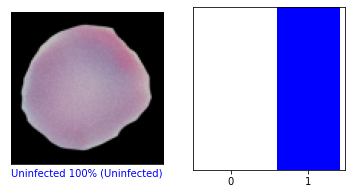

1 [1.0000e+00 8.6512e-10]


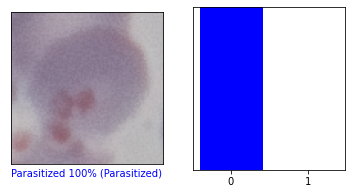

2 [1.0000e+00 7.0944e-27]


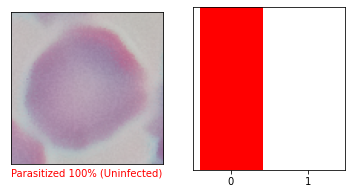

3 [7.9148e-29 1.0000e+00]


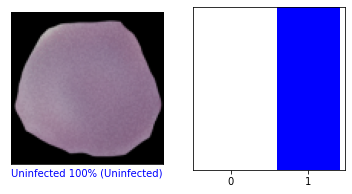

4 [1. 0.]


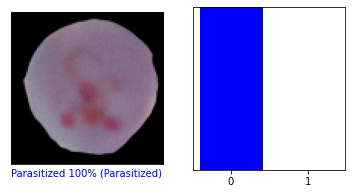

5 [1.000e+00 8.605e-14]


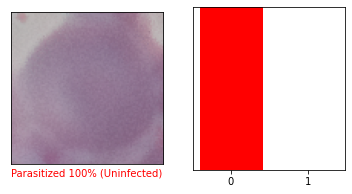

6 [1. 0.]


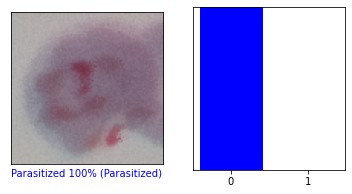

7 [1. 0.]


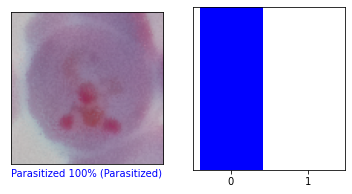

8 [1. 0.]


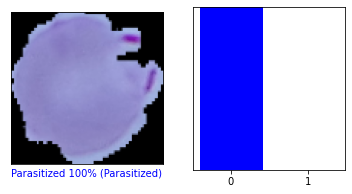

9 [3.6944e-09 1.0000e+00]


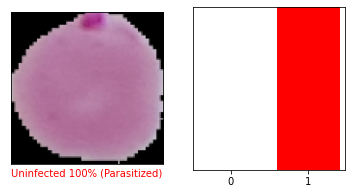

10 [1. 0.]


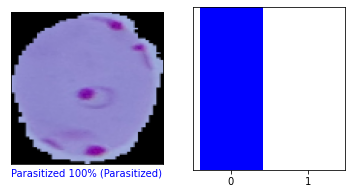

11 [1. 0.]


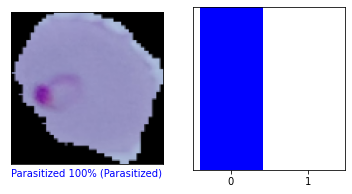

12 [1. 0.]


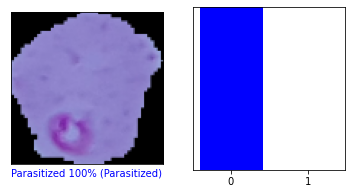

13 [1.0000e+00 1.0747e-22]


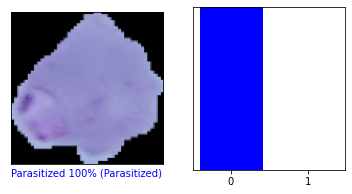

14 [1.0000e+00 8.4001e-22]


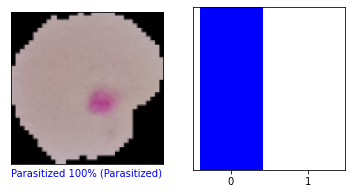

15 [9.9981e-01 1.8629e-04]


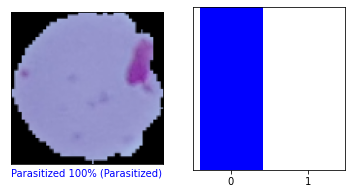

16 [8.3603e-32 1.0000e+00]


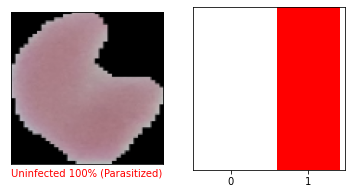

17 [1. 0.]


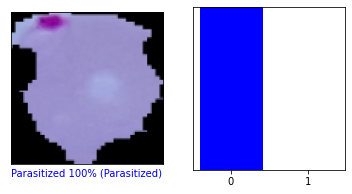

18 [1.000e+00 1.374e-17]


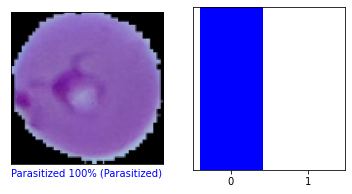

19 [1. 0.]


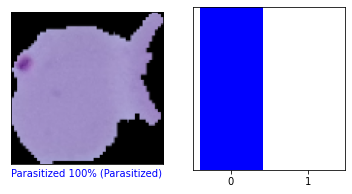

20 [1. 0.]


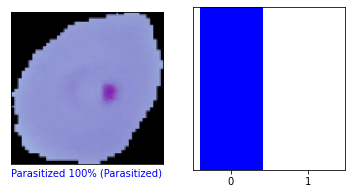

21 [1. 0.]


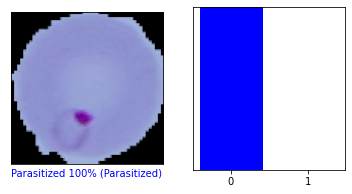

22 [1. 0.]


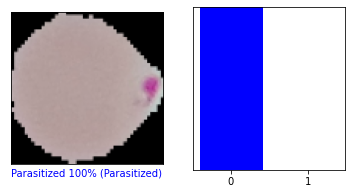

23 [1. 0.]


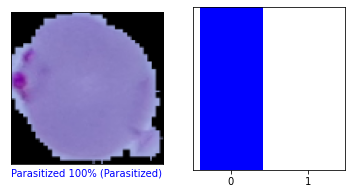

24 [1. 0.]


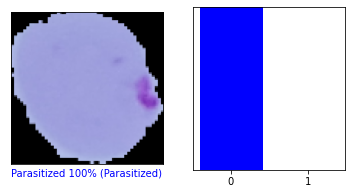

25 [1. 0.]


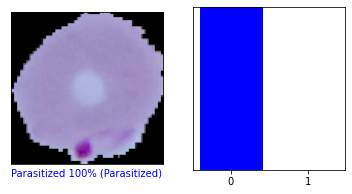

26 [1. 0.]


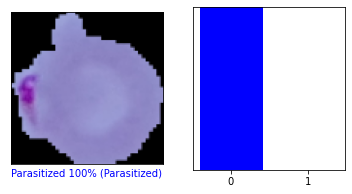

27 [1. 0.]


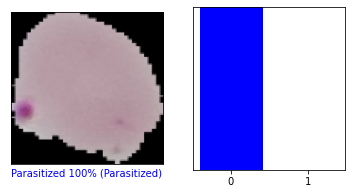

28 [1. 0.]


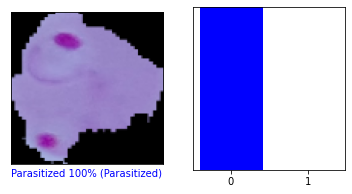

29 [1. 0.]


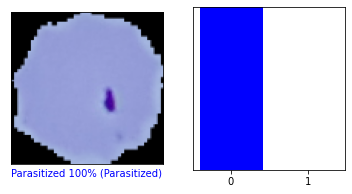

30 [1. 0.]


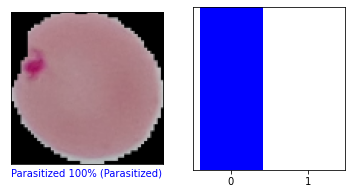

31 [1. 0.]


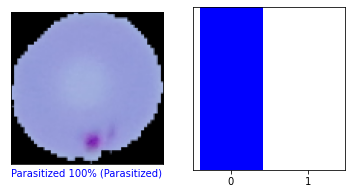

32 [1. 0.]


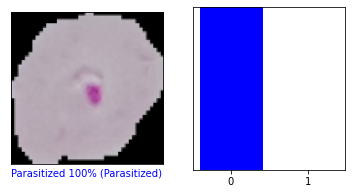

33 [1. 0.]


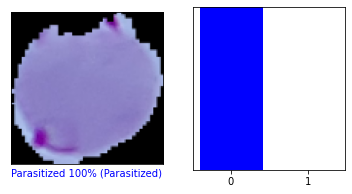

34 [1.3838e-05 9.9999e-01]


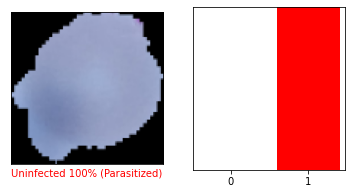

35 [1. 0.]


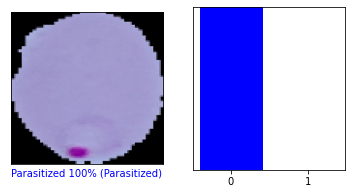

36 [1. 0.]


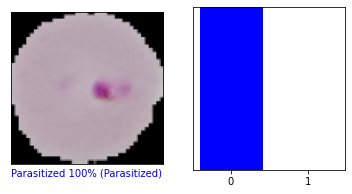

37 [1. 0.]


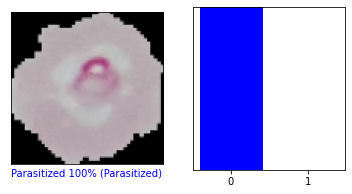

In [164]:
for i in range(0, len(filelist)):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    print(i, pred[i])
    plot_image(i, pred[i], test_labels, test_images)
    plt.subplot(1,2,2)
    plot_value_array(i, pred[i],  test_labels)
    plt.show()
